This is a notebook that will be used to compare, select, tune, and analyze the best model for multilabel classification when predicting the best Emergency Support Functions (ESF) that would accompany a given set of features as selected by a user in our Streamlit user interface. It takes inputs of:
* State
* Region
* Declaration Type
* Designated Incident Type(s)

Our model will take these inputs and select the best ESFs that are commonly used in similar situations.

In [11]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
import optuna
from functools import partial
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import seaborn as sns
import pickle
import warnings
from collected_functions import *


Set base variable values

In [12]:
random_state = 42
np.random.seed(random_state)
cv_args = {'n_splits': 5, 'shuffle': True, 'random_state': random_state}


Adjust Pandas settings to display more information before truncation.

In [13]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

Load combined MA and DDS training data

In [14]:
df = pd.read_parquet('combined_training_set_nontime.parquet')
print(df.shape)
df.head()

(6765, 22)


,incidentId,state,incidentTypeMA,region,maType,maPriority,supportFunction,agencyId,maId,declarationType,assistanceRequested,statementOfWork,femaDeclarationString,incidentType,incidentBeginDate,fipsStateCode,designatedIncidentTypes,declarationTitle,year,month,day,AR_topic
0,2024081901,CT,Severe Storm,1,FOS,High,5.0,DOI-USGS,3612EMCTDOI-USGS01,EM,USGS Field measurements of flood-water heights...,"As directed by and in coordination with FEMA, ...",EM-3612-CT,Severe Storm,2024-08-18 00:00:00+00:00,9.0,"Severe Storm,Flood,Mud/Landslide","SEVERE STORMS, FLOODING, LANDSLIDES, AND MUDSL...",2024.0,8.0,18.0,28
1,2024072801,FL,Tropical Storm,4,FOS,Normal,8.0,VA,4806DRFLVA02,DR,Activate VHA OEM to NRCC ESF-8 PHMS. This is a...,As directed by and in coordination with FEMA a...,DR-4806-FL,Tropical Storm,2024-08-01 00:00:00+00:00,12.0,"Hurricane,Tropical Storm",HURRICANE DEBBY,2024.0,8.0,1.0,23
2,2024072801,FL,Tropical Storm,4,FOS,Normal,0.0,VA,4806DRFLVA01,DR,Activate VA to NRCC. This is a re-issuance of ...,"As directed by and in coordination with FEMA, ...",DR-4806-FL,Tropical Storm,2024-08-01 00:00:00+00:00,12.0,"Hurricane,Tropical Storm",HURRICANE DEBBY,2024.0,8.0,1.0,23
3,2024072801,FL,Tropical Storm,4,FOS,Normal,4.0,USDA-FS,4806DRFLUSDA-FS01,DR,Activate USFS to the NRCC. This is a re-issuan...,"As directed by and in coordination with FEMA, ...",DR-4806-FL,Tropical Storm,2024-08-01 00:00:00+00:00,12.0,"Hurricane,Tropical Storm",HURRICANE DEBBY,2024.0,8.0,1.0,30
4,2024072801,FL,Tropical Storm,4,FOS,Normal,11.0,USDA-APH,4806DRFLUSDA-APH01,DR,"USDA liaison(s) to the NRCC, FEMA teams, or ot...","As directed by and in coordination with FEMA, ...",DR-4806-FL,Tropical Storm,2024-08-01 00:00:00+00:00,12.0,"Hurricane,Tropical Storm",HURRICANE DEBBY,2024.0,8.0,1.0,32


Transform the training data set using approach that is suitable for multiple categorical feature columns and a multilabel target. We return the transformers so that the test data set can be transformed later.

In [15]:
feature_columns = [
    'incidentId',
    'state',
    'designatedIncidentTypes',
    'declarationType',
    'region',
    'year',
]

target_column = 'supportFunction'

X_train, y_train = create_set(df, feature_columns, target_column)

print(X_train.shape, len(y_train))
print(y_train[:5])
X_train.head(5)

(464, 6) 464
0                         [7.0]
1                         [7.0]
2                         [7.0]
3    [2.0, 3.0, 7.0, 9.0, 13.0]
4        [8.0, 1.0, 10.0, 13.0]
Name: supportFunction, dtype: object


,incidentId,state,designatedIncidentTypes,declarationType,region,year
0,2013020801,CT,Severe Storm,DR,1,2013.0
1,2013020801,NH,Severe Storm,DR,1,2013.0
2,2013020801,RI,Severe Storm,DR,1,2013.0
3,2013041203,ND,Flood,EM,8,2013.0
4,2013041501,MA,Terrorist,EM,1,2013.0


In [16]:
# Split the string in designatedIncidentTypes to a list of strings.
# This cannot be done earlier due to groupby issues.
X_train['designatedIncidentTypes'] = X_train['designatedIncidentTypes'].str.split(',')


In [17]:
# Since designatedIncidentTypes is a list it must be transformed differently than the other
# feature columns.
feature_columns_transform = [
    'state',
    'declarationType',
    'region',
]

X_train_transformed, y_train_transformed, preprocessor_X, preprocessor_y = transform_x_y_train(
    X_train,
    y_train,
    feature_columns_transform,
    ['designatedIncidentTypes'],
    target_column,
    'ESF_'
)

In [18]:
#Drop year and incidentId from X_train_transformed.
X_train_transformed.drop(columns=['incidentId', 'year'], inplace=True)
print(X_train_transformed.shape)
X_train_transformed.head()

(464, 89)


,state_AK,state_AL,state_AR,state_AS,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_GU,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MP,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_PR,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY,declarationType_DR,declarationType_EM,region_1,region_2,region_3,region_4,region_5,region_6,region_7,region_8,region_9,region_10,designatedIncidentTypes_Biological,designatedIncidentTypes_Chemical,designatedIncidentTypes_Coastal Storm,designatedIncidentTypes_Dam/Levee Break,designatedIncidentTypes_Earthquake,designatedIncidentTypes_Fire,designatedIncidentTypes_Flood,designatedIncidentTypes_Hurricane,designatedIncidentTypes_Mud/Landslide,designatedIncidentTypes_Other,designatedIncidentTypes_Severe Ice Storm,designatedIncidentTypes_Severe Storm,designatedIncidentTypes_Snowstorm,designatedIncidentTypes_Straight-Line Winds,designatedIncidentTypes_Terrorist,designatedIncidentTypes_Tornado,designatedIncidentTypes_Tropical Depression,designatedIncidentTypes_Tropical Storm,designatedIncidentTypes_Typhoon,designatedIncidentTypes_Volcanic Eruption,designatedIncidentTypes_Winter Storm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
print(y_train_transformed.shape)
y_train_transformed.head()

(464, 16)


,ESF_0,ESF_1,ESF_2,ESF_3,ESF_4,ESF_5,ESF_6,ESF_7,ESF_8,ESF_9,ESF_10,ESF_11,ESF_12,ESF_13,ESF_14,ESF_15
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0,0
4,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0


Run a variety of machine learning models and base classifiers using cross validation for model selection purposes.

In [20]:
# Create base classifiers for use with other models.
base_svc = SVC(
    gamma='auto',
    decision_function_shape='ovo',
    class_weight='balanced',
    random_state=random_state,
)
base_xgb = XGBClassifier(
    max_depth=12,
    random_state=random_state,
    n_estimators=100,
    base_score=0.5,
)
base_gnb = GaussianNB()

# Use some models from skmultilearn
br_classifier_svc = BinaryRelevance(
    classifier = base_svc,
    require_dense = [True, True]
)
br_classifier_xgb = BinaryRelevance(
    classifier = base_xgb,
    require_dense = [True, True]
)
br_classifier_gnb = BinaryRelevance(
    classifier = base_gnb,
    require_dense = [True, True]
)

cc_classifier_svc = ClassifierChain(
    classifier=base_svc, 
    require_dense=[True, True],
    order = list(range(0,16)),
)
cc_classifier_xgb = ClassifierChain(
    classifier=base_xgb,
    require_dense=[True, True],
    order = list(range(0,16)),
)
cc_classifier_gnb = ClassifierChain(
    classifier=base_gnb,
    require_dense=[True, True],
    order = list(range(0,16)),
)
cc_classifier_lr = ClassifierChain(
    classifier=LogisticRegression(max_iter=300),
    require_dense=[True, True],
)

# Check performance of sklearn models that can natively handle multiclass targets.
base_rf = RandomForestClassifier(
    random_state=random_state,
    n_jobs=-1,
    max_depth=12,
    n_estimators=100,
    class_weight='balanced_subsample'
)

base_etc = ExtraTreesClassifier(
    random_state=random_state,
    max_depth=12,
    n_jobs=-1,
    class_weight='balanced_subsample',
)

# Finish with sklearn models that require a base estimator.
moc_svc = MultiOutputClassifier(estimator=base_svc)
moc_xgb = MultiOutputClassifier(estimator=base_xgb)
moc_gnb = MultiOutputClassifier(estimator=base_gnb)

ovr_svc = OneVsRestClassifier(estimator=base_svc)
ovr_xgb = OneVsRestClassifier(estimator=base_xgb)
ovr_gnb = OneVsRestClassifier(estimator=base_gnb)

clf_list = [
    br_classifier_svc,
    br_classifier_xgb,
    br_classifier_gnb,
    cc_classifier_svc,
    cc_classifier_xgb,
    cc_classifier_gnb,
    cc_classifier_lr,
    base_rf,
    base_etc,
    moc_svc,
    moc_xgb,
    moc_gnb,
    ovr_svc,
    ovr_xgb,
    ovr_gnb,
]

# Set up some scoring options that work well with multiclass results.
hamming_scorer = make_scorer(
    hamming_loss,
    greater_is_better=False, 
)

F1_Macro_Avg = make_scorer(
    f1_score,
    average='macro', 
    zero_division=1,
)

F1_Samples_Avg = make_scorer(
    f1_score,
    average='samples', 
    zero_division=1,
)

# include mAP with the understanding that some of our models output sparse arrays which
# does not work in our scoring setup using cross_validate.
mean_average_precision = make_scorer(
    average_precision_score,
    average='macro', 
)

scoring = {
    'Hamming':hamming_scorer,
    'F1_Macro_Avg':F1_Macro_Avg,
    'F1_Samples_Avg':F1_Samples_Avg,
    'mAP':mean_average_precision,
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    for clf in clf_list:
        cross_val_results = cross_validate(clf,
                                        X_train_transformed,
                                        y_train_transformed,
                                        cv=5,
                                        scoring=scoring)

        print(f'{clf}\nMean Hamming Loss: {cross_val_results['test_Hamming'].mean()}, {cross_val_results['test_Hamming'].std() }')
        print(f'\nMean F1 Macro Avg: {cross_val_results['test_F1_Macro_Avg'].mean()}, {cross_val_results['test_F1_Macro_Avg'].std() }')
        print(f'\nMean F1 Samples Avg: {cross_val_results['test_F1_Samples_Avg'].mean()}, {cross_val_results['test_F1_Samples_Avg'].std() }')
        print(f'\nMean Mean Average Precision: {cross_val_results['test_mAP'].mean()}, {cross_val_results['test_mAP'].std() }')

BinaryRelevance(classifier=SVC(class_weight='balanced',
                               decision_function_shape='ovo', gamma='auto',
                               random_state=42),
                require_dense=[True, True])
Mean Hamming Loss: -0.2927244039270687, 0.04516876466261546

Mean F1 Macro Avg: 0.4559641247526722, 0.07679530611256528

Mean F1 Samples Avg: 0.5045256741299241, 0.0304706666423988

Mean Mean Average Precision: nan, nan
BinaryRelevance(classifier=XGBClassifier(base_score=0.5, booster=None,
                                         callbacks=None, colsample_bylevel=None,
                                         colsample_bynode=None,
                                         colsample_bytree=None, device=None,
                                         early_stopping_rounds=None,
                                         enable_categorical=False,
                                         eval_metric=None, feature_types=None,
                                         featur

XGBoost appears to be our best base model based on Hamming Loss and F1 scores, though SVC does beat it on F1 scores alone. The most promising models appear to be BinaryRelevance, ClassifierChain, and OneVsRestClassifier (MultiOutputClassification had similar results and OneVsRestClassifier is more suited to this sort of task per documentation).

We can start with hyperparameter tuning of BinaryRelevance and the XGBoost base classifier. We will be using Optuna for all models to keep outcomes consistent.

In [21]:
def objective_brxgb(trial, X, y, cv_args, random_state):

    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=25),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 2, 6, log=True),
        'base_score': 0.5, 
        'random_state': random_state,
        'n_jobs': -1,
        'verbosity': 0,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }

    base_XGB = XGBClassifier(**xgb_params)
    
    clf = BinaryRelevance(
        classifier = base_XGB,
        require_dense = [True, True],
    )

    scores = []    
    cv = KFold(**cv_args)

    for train_index, val_index in cv.split(X, y):
    
        X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UndefinedMetricWarning)
            warnings.simplefilter("ignore", category=UserWarning)
            eval_scorer = combined_score(y_val, y_pred.toarray())
        scores.append(eval_scorer)

    return np.mean(scores)

objective_brxgb = partial(objective_brxgb,
                        X=X_train_transformed,
                        y=y_train_transformed,
                        cv_args=cv_args,
                        random_state=random_state,
                        )

# Maximize the score to improve results
study_brxgb = optuna.create_study(direction="maximize")

study_brxgb.optimize(objective_brxgb, n_trials=60, show_progress_bar=True)

print("Optuna Hyperparameter Tuning Complete")
print(f"Best Score (Validation): {study_brxgb.best_value:.4f}")
print("Best Parameters:")
for key, value in study_brxgb.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-28 10:40:43,025] A new study created in memory with name: no-name-0d9cead9-6aa9-468c-a5d5-343c20ba95d0
Best trial: 0. Best value: 1.2532:   2%|▏         | 1/60 [00:13<13:39, 13.89s/it]

[I 2025-11-28 10:40:56,921] Trial 0 finished with value: 1.2532030511451793 and parameters: {'n_estimators': 300, 'max_depth': 13, 'learning_rate': 0.00010329046423641169, 'subsample': 0.7699393886880765, 'colsample_bytree': 0.8581680014604598, 'scale_pos_weight': 2.4796628306663737}. Best is trial 0 with value: 1.2532030511451793.


Best trial: 1. Best value: 1.25708:   3%|▎         | 2/60 [00:24<11:35, 11.99s/it]

[I 2025-11-28 10:41:07,586] Trial 1 finished with value: 1.2570781293717226 and parameters: {'n_estimators': 200, 'max_depth': 14, 'learning_rate': 0.007782306826846582, 'subsample': 0.7757069756896052, 'colsample_bytree': 0.6595580175032718, 'scale_pos_weight': 4.590114779099356}. Best is trial 1 with value: 1.2570781293717226.


Best trial: 1. Best value: 1.25708:   5%|▌         | 3/60 [00:28<08:04,  8.51s/it]

[I 2025-11-28 10:41:11,944] Trial 2 finished with value: 1.238055106984544 and parameters: {'n_estimators': 125, 'max_depth': 6, 'learning_rate': 0.0033459215692418624, 'subsample': 0.9033038083647364, 'colsample_bytree': 0.8247035919790211, 'scale_pos_weight': 3.600515017041589}. Best is trial 1 with value: 1.2570781293717226.


Best trial: 1. Best value: 1.25708:   7%|▋         | 4/60 [00:34<06:49,  7.31s/it]

[I 2025-11-28 10:41:17,423] Trial 3 finished with value: 1.2121734507834705 and parameters: {'n_estimators': 125, 'max_depth': 10, 'learning_rate': 0.06279711674298213, 'subsample': 0.812137305319673, 'colsample_bytree': 0.610650299322458, 'scale_pos_weight': 4.154374084989678}. Best is trial 1 with value: 1.2570781293717226.


Best trial: 4. Best value: 1.26079:   8%|▊         | 5/60 [00:42<06:49,  7.44s/it]

[I 2025-11-28 10:41:25,096] Trial 4 finished with value: 1.2607856620602564 and parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.01582875348933433, 'subsample': 0.636235161141588, 'colsample_bytree': 0.8085392627658324, 'scale_pos_weight': 2.6476835346266108}. Best is trial 4 with value: 1.2607856620602564.


Best trial: 4. Best value: 1.26079:  10%|█         | 6/60 [00:48<06:19,  7.02s/it]

[I 2025-11-28 10:41:31,307] Trial 5 finished with value: 1.258449206501807 and parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.011972581838493345, 'subsample': 0.7665880061552364, 'colsample_bytree': 0.8903937778919554, 'scale_pos_weight': 4.308836056471405}. Best is trial 4 with value: 1.2607856620602564.


Best trial: 4. Best value: 1.26079:  12%|█▏        | 7/60 [00:52<05:20,  6.05s/it]

[I 2025-11-28 10:41:35,358] Trial 6 finished with value: 1.1988938290825668 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.019153983880631397, 'subsample': 0.6601299015698545, 'colsample_bytree': 0.9067749760765157, 'scale_pos_weight': 5.681937260839068}. Best is trial 4 with value: 1.2607856620602564.


Best trial: 4. Best value: 1.26079:  13%|█▎        | 8/60 [00:57<05:01,  5.80s/it]

[I 2025-11-28 10:41:40,617] Trial 7 finished with value: 1.259134434649044 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.024700709366892067, 'subsample': 0.9027627352315437, 'colsample_bytree': 0.8032274897405233, 'scale_pos_weight': 2.001760015825787}. Best is trial 4 with value: 1.2607856620602564.


Best trial: 4. Best value: 1.26079:  15%|█▌        | 9/60 [01:08<06:19,  7.44s/it]

[I 2025-11-28 10:41:51,664] Trial 8 finished with value: 1.24269388537017 and parameters: {'n_estimators': 275, 'max_depth': 10, 'learning_rate': 0.0010458964725260109, 'subsample': 0.601574258052441, 'colsample_bytree': 0.8562021104427768, 'scale_pos_weight': 2.7425544459551086}. Best is trial 4 with value: 1.2607856620602564.


Best trial: 9. Best value: 1.2691:  17%|█▋        | 10/60 [01:20<07:26,  8.93s/it]

[I 2025-11-28 10:42:03,927] Trial 9 finished with value: 1.269104829614247 and parameters: {'n_estimators': 275, 'max_depth': 15, 'learning_rate': 0.0049355480025248715, 'subsample': 0.6001434927949247, 'colsample_bytree': 0.6271048891745002, 'scale_pos_weight': 5.673438029879781}. Best is trial 9 with value: 1.269104829614247.


Best trial: 9. Best value: 1.2691:  18%|█▊        | 11/60 [01:30<07:29,  9.16s/it]

[I 2025-11-28 10:42:13,626] Trial 10 finished with value: 1.2462735256026711 and parameters: {'n_estimators': 250, 'max_depth': 12, 'learning_rate': 0.0008800505546398545, 'subsample': 0.6919205340979153, 'colsample_bytree': 0.7207206661394036, 'scale_pos_weight': 5.685893253075138}. Best is trial 9 with value: 1.269104829614247.


Best trial: 9. Best value: 1.2691:  20%|██        | 12/60 [01:39<07:10,  8.96s/it]

[I 2025-11-28 10:42:22,120] Trial 11 finished with value: 1.2156763597701932 and parameters: {'n_estimators': 225, 'max_depth': 8, 'learning_rate': 0.09883618480853378, 'subsample': 0.6186992654044089, 'colsample_bytree': 0.7540185815264586, 'scale_pos_weight': 2.8099581232696584}. Best is trial 9 with value: 1.269104829614247.


Best trial: 9. Best value: 1.2691:  22%|██▏       | 13/60 [01:42<05:36,  7.17s/it]

[I 2025-11-28 10:42:25,165] Trial 12 finished with value: 1.2378635160925189 and parameters: {'n_estimators': 50, 'max_depth': 11, 'learning_rate': 0.003090330691601058, 'subsample': 0.6837880736046389, 'colsample_bytree': 0.7218098980945333, 'scale_pos_weight': 3.2063083658287916}. Best is trial 9 with value: 1.269104829614247.


Best trial: 9. Best value: 1.2691:  23%|██▎       | 14/60 [01:49<05:28,  7.14s/it]

[I 2025-11-28 10:42:32,252] Trial 13 finished with value: 1.234928785260213 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.002883607331811789, 'subsample': 0.6479536804230586, 'colsample_bytree': 0.6652513831989023, 'scale_pos_weight': 2.1921957747340275}. Best is trial 9 with value: 1.269104829614247.


Best trial: 9. Best value: 1.2691:  25%|██▌       | 15/60 [01:59<06:05,  8.12s/it]

[I 2025-11-28 10:42:42,626] Trial 14 finished with value: 1.2150347128581673 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.03616000569277466, 'subsample': 0.7115613051828109, 'colsample_bytree': 0.7761665789106582, 'scale_pos_weight': 3.4236489429743964}. Best is trial 9 with value: 1.269104829614247.


Best trial: 9. Best value: 1.2691:  27%|██▋       | 16/60 [02:09<06:26,  8.78s/it]

[I 2025-11-28 10:42:52,934] Trial 15 finished with value: 1.2463958103280857 and parameters: {'n_estimators': 250, 'max_depth': 12, 'learning_rate': 0.0007433253070207409, 'subsample': 0.6007083684155763, 'colsample_bytree': 0.9461650042884207, 'scale_pos_weight': 4.7956891806567}. Best is trial 9 with value: 1.269104829614247.


Best trial: 9. Best value: 1.2691:  28%|██▊       | 17/60 [02:18<06:10,  8.61s/it]

[I 2025-11-28 10:43:01,158] Trial 16 finished with value: 1.2543251966593207 and parameters: {'n_estimators': 175, 'max_depth': 15, 'learning_rate': 0.007165628010015711, 'subsample': 0.8396636461527452, 'colsample_bytree': 0.6035249280524866, 'scale_pos_weight': 2.802290345523631}. Best is trial 9 with value: 1.269104829614247.


Best trial: 9. Best value: 1.2691:  30%|███       | 18/60 [02:23<05:25,  7.76s/it]

[I 2025-11-28 10:43:06,942] Trial 17 finished with value: 1.1715654749787299 and parameters: {'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.0002954920624167918, 'subsample': 0.7239518181885132, 'colsample_bytree': 0.687502138217774, 'scale_pos_weight': 3.7593347867825844}. Best is trial 9 with value: 1.269104829614247.


Best trial: 9. Best value: 1.2691:  32%|███▏      | 19/60 [02:31<05:13,  7.66s/it]

[I 2025-11-28 10:43:14,355] Trial 18 finished with value: 1.2660469194858854 and parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.005414016478118224, 'subsample': 0.6487540338180965, 'colsample_bytree': 0.771556006205605, 'scale_pos_weight': 5.10732548049395}. Best is trial 9 with value: 1.269104829614247.


Best trial: 9. Best value: 1.2691:  33%|███▎      | 20/60 [02:40<05:27,  8.18s/it]

[I 2025-11-28 10:43:23,760] Trial 19 finished with value: 1.22542457504926 and parameters: {'n_estimators': 275, 'max_depth': 7, 'learning_rate': 0.005311129777860951, 'subsample': 0.9430679227148984, 'colsample_bytree': 0.6336516740022975, 'scale_pos_weight': 4.962889259442898}. Best is trial 9 with value: 1.269104829614247.


Best trial: 9. Best value: 1.2691:  35%|███▌      | 21/60 [02:49<05:26,  8.37s/it]

[I 2025-11-28 10:43:32,575] Trial 20 finished with value: 1.2528908863892467 and parameters: {'n_estimators': 225, 'max_depth': 11, 'learning_rate': 0.001500699698007822, 'subsample': 0.6580732422729885, 'colsample_bytree': 0.7109718029464597, 'scale_pos_weight': 5.225755213205322}. Best is trial 9 with value: 1.269104829614247.


Best trial: 21. Best value: 1.26938:  37%|███▋      | 22/60 [02:56<05:04,  8.01s/it]

[I 2025-11-28 10:43:39,742] Trial 21 finished with value: 1.2693788877486405 and parameters: {'n_estimators': 175, 'max_depth': 9, 'learning_rate': 0.013688718826678551, 'subsample': 0.6431112652069297, 'colsample_bytree': 0.7658035744983263, 'scale_pos_weight': 5.652444090235182}. Best is trial 21 with value: 1.2693788877486405.


Best trial: 21. Best value: 1.26938:  38%|███▊      | 23/60 [03:03<04:39,  7.56s/it]

[I 2025-11-28 10:43:46,256] Trial 22 finished with value: 1.2650873294815272 and parameters: {'n_estimators': 175, 'max_depth': 9, 'learning_rate': 0.010683561019258849, 'subsample': 0.6321459617170452, 'colsample_bytree': 0.7585773979142816, 'scale_pos_weight': 5.899876154954687}. Best is trial 21 with value: 1.2693788877486405.


Best trial: 21. Best value: 1.26938:  40%|████      | 24/60 [03:09<04:20,  7.25s/it]

[I 2025-11-28 10:43:52,772] Trial 23 finished with value: 1.268055387446534 and parameters: {'n_estimators': 150, 'max_depth': 11, 'learning_rate': 0.004879640447115328, 'subsample': 0.6772819314841524, 'colsample_bytree': 0.7748486809480936, 'scale_pos_weight': 5.225477075089611}. Best is trial 21 with value: 1.2693788877486405.


Best trial: 21. Best value: 1.26938:  42%|████▏     | 25/60 [03:16<04:08,  7.10s/it]

[I 2025-11-28 10:43:59,516] Trial 24 finished with value: 1.246111541724739 and parameters: {'n_estimators': 150, 'max_depth': 13, 'learning_rate': 0.0016844695823996318, 'subsample': 0.7364870416857467, 'colsample_bytree': 0.7403161368788901, 'scale_pos_weight': 5.357364972499908}. Best is trial 21 with value: 1.2693788877486405.


Best trial: 21. Best value: 1.26938:  43%|████▎     | 26/60 [03:23<03:56,  6.94s/it]

[I 2025-11-28 10:44:06,108] Trial 25 finished with value: 1.2258296973556824 and parameters: {'n_estimators': 150, 'max_depth': 11, 'learning_rate': 0.041413978613928, 'subsample': 0.6731318777949261, 'colsample_bytree': 0.8393653970358954, 'scale_pos_weight': 4.063100228481091}. Best is trial 21 with value: 1.2693788877486405.


Best trial: 21. Best value: 1.26938:  45%|████▌     | 27/60 [03:26<03:19,  6.03s/it]

[I 2025-11-28 10:44:10,008] Trial 26 finished with value: 1.2571747266581972 and parameters: {'n_estimators': 75, 'max_depth': 14, 'learning_rate': 0.002137548909753048, 'subsample': 0.7098927843695, 'colsample_bytree': 0.796767661709597, 'scale_pos_weight': 4.497961803822776}. Best is trial 21 with value: 1.2693788877486405.


Best trial: 21. Best value: 1.26938:  47%|████▋     | 28/60 [03:32<03:07,  5.85s/it]

[I 2025-11-28 10:44:15,432] Trial 27 finished with value: 1.2502290615167557 and parameters: {'n_estimators': 125, 'max_depth': 12, 'learning_rate': 0.004842434891849105, 'subsample': 0.6016717866473366, 'colsample_bytree': 0.6904748893040569, 'scale_pos_weight': 5.957028013426839}. Best is trial 21 with value: 1.2693788877486405.


Best trial: 21. Best value: 1.26938:  48%|████▊     | 29/60 [03:40<03:22,  6.53s/it]

[I 2025-11-28 10:44:23,538] Trial 28 finished with value: 1.2560097762025866 and parameters: {'n_estimators': 175, 'max_depth': 14, 'learning_rate': 0.02434814761496145, 'subsample': 0.6887304144391438, 'colsample_bytree': 0.6272686285885255, 'scale_pos_weight': 5.346660995220747}. Best is trial 21 with value: 1.2693788877486405.


Best trial: 21. Best value: 1.26938:  50%|█████     | 30/60 [03:49<03:39,  7.31s/it]

[I 2025-11-28 10:44:32,674] Trial 29 finished with value: 1.243314416573621 and parameters: {'n_estimators': 225, 'max_depth': 13, 'learning_rate': 0.0002124846324534311, 'subsample': 0.6239840520854931, 'colsample_bytree': 0.6633644884495705, 'scale_pos_weight': 4.744192229505778}. Best is trial 21 with value: 1.2693788877486405.


Best trial: 21. Best value: 1.26938:  52%|█████▏    | 31/60 [04:01<04:12,  8.69s/it]

[I 2025-11-28 10:44:44,597] Trial 30 finished with value: 1.2547100677303131 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.010085206432432386, 'subsample': 0.7606312896113739, 'colsample_bytree': 0.868683386097013, 'scale_pos_weight': 3.8923025874700876}. Best is trial 21 with value: 1.2693788877486405.


Best trial: 31. Best value: 1.27469:  53%|█████▎    | 32/60 [04:09<03:53,  8.36s/it]

[I 2025-11-28 10:44:52,168] Trial 31 finished with value: 1.2746937025757243 and parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.004351076728953165, 'subsample': 0.6504342218180813, 'colsample_bytree': 0.7820018762235604, 'scale_pos_weight': 5.25420908588641}. Best is trial 31 with value: 1.2746937025757243.


Best trial: 31. Best value: 1.27469:  55%|█████▌    | 33/60 [04:14<03:20,  7.44s/it]

[I 2025-11-28 10:44:57,480] Trial 32 finished with value: 1.2424603465000406 and parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.004252837773070524, 'subsample': 0.6673540051822263, 'colsample_bytree': 0.7889369638008861, 'scale_pos_weight': 5.534814651033458}. Best is trial 31 with value: 1.2746937025757243.


Best trial: 31. Best value: 1.27469:  57%|█████▋    | 34/60 [04:23<03:23,  7.82s/it]

[I 2025-11-28 10:45:06,180] Trial 33 finished with value: 1.2470854223915666 and parameters: {'n_estimators': 275, 'max_depth': 7, 'learning_rate': 0.007426990809906285, 'subsample': 0.629658752294435, 'colsample_bytree': 0.740572436062946, 'scale_pos_weight': 4.501706144312449}. Best is trial 31 with value: 1.2746937025757243.


Best trial: 31. Best value: 1.27469:  58%|█████▊    | 35/60 [04:31<03:16,  7.85s/it]

[I 2025-11-28 10:45:14,110] Trial 34 finished with value: 1.2399296464197505 and parameters: {'n_estimators': 175, 'max_depth': 10, 'learning_rate': 0.002254146325964327, 'subsample': 0.8216883377934501, 'colsample_bytree': 0.8191767986107041, 'scale_pos_weight': 4.978220570075014}. Best is trial 31 with value: 1.2746937025757243.


Best trial: 31. Best value: 1.27469:  60%|██████    | 36/60 [04:37<02:58,  7.42s/it]

[I 2025-11-28 10:45:20,521] Trial 35 finished with value: 1.2524585979268053 and parameters: {'n_estimators': 125, 'max_depth': 9, 'learning_rate': 0.015597890596647197, 'subsample': 0.7018328758135478, 'colsample_bytree': 0.8386289268813447, 'scale_pos_weight': 5.527721211674401}. Best is trial 31 with value: 1.2746937025757243.


Best trial: 31. Best value: 1.27469:  62%|██████▏   | 37/60 [04:42<02:31,  6.57s/it]

[I 2025-11-28 10:45:25,111] Trial 36 finished with value: 1.253721049007824 and parameters: {'n_estimators': 100, 'max_depth': 13, 'learning_rate': 0.00647078168542376, 'subsample': 0.7323045331555074, 'colsample_bytree': 0.6943199578079311, 'scale_pos_weight': 5.972616163709689}. Best is trial 31 with value: 1.2746937025757243.


Best trial: 31. Best value: 1.27469:  63%|██████▎   | 38/60 [04:49<02:28,  6.77s/it]

[I 2025-11-28 10:45:32,348] Trial 37 finished with value: 1.2648204901259203 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.010761081951050782, 'subsample': 0.6429934437699458, 'colsample_bytree': 0.7797785885640789, 'scale_pos_weight': 4.276685662940144}. Best is trial 31 with value: 1.2746937025757243.


Best trial: 31. Best value: 1.27469:  65%|██████▌   | 39/60 [04:59<02:40,  7.65s/it]

[I 2025-11-28 10:45:42,042] Trial 38 finished with value: 1.2553438342497067 and parameters: {'n_estimators': 225, 'max_depth': 11, 'learning_rate': 0.014424864756610119, 'subsample': 0.7952903935014448, 'colsample_bytree': 0.8223733506146479, 'scale_pos_weight': 4.691770583018271}. Best is trial 31 with value: 1.2746937025757243.


Best trial: 31. Best value: 1.27469:  67%|██████▋   | 40/60 [05:05<02:27,  7.37s/it]

[I 2025-11-28 10:45:48,755] Trial 39 finished with value: 1.2611251951518703 and parameters: {'n_estimators': 150, 'max_depth': 15, 'learning_rate': 0.0036791401436235766, 'subsample': 0.6177015921963558, 'colsample_bytree': 0.7430197610189474, 'scale_pos_weight': 5.116587338575008}. Best is trial 31 with value: 1.2746937025757243.


Best trial: 31. Best value: 1.27469:  68%|██████▊   | 41/60 [05:13<02:23,  7.55s/it]

[I 2025-11-28 10:45:56,725] Trial 40 finished with value: 1.194559879773744 and parameters: {'n_estimators': 175, 'max_depth': 6, 'learning_rate': 0.00043547793127571565, 'subsample': 0.6730748050299622, 'colsample_bytree': 0.9106603595711878, 'scale_pos_weight': 5.527811014177072}. Best is trial 31 with value: 1.2746937025757243.


Best trial: 31. Best value: 1.27469:  70%|███████   | 42/60 [05:22<02:22,  7.94s/it]

[I 2025-11-28 10:46:05,588] Trial 41 finished with value: 1.2682566373422184 and parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.005558581016547848, 'subsample': 0.6505239510292565, 'colsample_bytree': 0.7621798365191002, 'scale_pos_weight': 5.150969590514872}. Best is trial 31 with value: 1.2746937025757243.


Best trial: 31. Best value: 1.27469:  72%|███████▏  | 43/60 [05:30<02:17,  8.09s/it]

[I 2025-11-28 10:46:14,023] Trial 42 finished with value: 1.2568014577841244 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.0026437576286579096, 'subsample': 0.6580866825455112, 'colsample_bytree': 0.7649035151213304, 'scale_pos_weight': 4.884470387851862}. Best is trial 31 with value: 1.2746937025757243.


Best trial: 31. Best value: 1.27469:  73%|███████▎  | 44/60 [05:39<02:11,  8.23s/it]

[I 2025-11-28 10:46:22,565] Trial 43 finished with value: 1.2597848687111592 and parameters: {'n_estimators': 175, 'max_depth': 9, 'learning_rate': 0.00375335352145387, 'subsample': 0.6183412052148654, 'colsample_bytree': 0.8057149977161316, 'scale_pos_weight': 5.75894796862093}. Best is trial 31 with value: 1.2746937025757243.


Best trial: 31. Best value: 1.27469:  75%|███████▌  | 45/60 [05:50<02:16,  9.12s/it]

[I 2025-11-28 10:46:33,776] Trial 44 finished with value: 1.236836141564676 and parameters: {'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.009320760808445168, 'subsample': 0.6409559373057625, 'colsample_bytree': 0.7273286997791168, 'scale_pos_weight': 5.3001075860615385}. Best is trial 31 with value: 1.2746937025757243.


Best trial: 31. Best value: 1.27469:  77%|███████▋  | 46/60 [06:02<02:20, 10.04s/it]

[I 2025-11-28 10:46:45,965] Trial 45 finished with value: 1.2559328959570657 and parameters: {'n_estimators': 225, 'max_depth': 10, 'learning_rate': 0.02121641911873862, 'subsample': 0.6803114706293883, 'colsample_bytree': 0.7902814977088375, 'scale_pos_weight': 4.318962320122786}. Best is trial 31 with value: 1.2746937025757243.


Best trial: 31. Best value: 1.27469:  78%|███████▊  | 47/60 [06:10<02:01,  9.33s/it]

[I 2025-11-28 10:46:53,633] Trial 46 finished with value: 1.2235527800888133 and parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.0012994217956158168, 'subsample': 0.7510848514628974, 'colsample_bytree': 0.7494038283365946, 'scale_pos_weight': 4.563320695141643}. Best is trial 31 with value: 1.2746937025757243.


Best trial: 31. Best value: 1.27469:  80%|████████  | 48/60 [06:16<01:38,  8.18s/it]

[I 2025-11-28 10:46:59,124] Trial 47 finished with value: 1.256297672723996 and parameters: {'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.0065647633369719394, 'subsample': 0.6175040069201518, 'colsample_bytree': 0.7076043914026746, 'scale_pos_weight': 3.1201190001190637}. Best is trial 31 with value: 1.2746937025757243.


Best trial: 31. Best value: 1.27469:  82%|████████▏ | 49/60 [06:27<01:39,  9.07s/it]

[I 2025-11-28 10:47:10,289] Trial 48 finished with value: 1.255488859409177 and parameters: {'n_estimators': 200, 'max_depth': 11, 'learning_rate': 0.038986289380949495, 'subsample': 0.6515026047457289, 'colsample_bytree': 0.6396006777978457, 'scale_pos_weight': 5.638451810283004}. Best is trial 31 with value: 1.2746937025757243.


Best trial: 31. Best value: 1.27469:  83%|████████▎ | 50/60 [06:43<01:53, 11.30s/it]

[I 2025-11-28 10:47:26,791] Trial 49 finished with value: 1.2474711726311443 and parameters: {'n_estimators': 275, 'max_depth': 12, 'learning_rate': 0.013155563040370686, 'subsample': 0.601037323822538, 'colsample_bytree': 0.8458769762354001, 'scale_pos_weight': 5.04132237549748}. Best is trial 31 with value: 1.2746937025757243.


Best trial: 31. Best value: 1.27469:  85%|████████▌ | 51/60 [06:52<01:35, 10.58s/it]

[I 2025-11-28 10:47:35,683] Trial 50 finished with value: 1.254516362777705 and parameters: {'n_estimators': 225, 'max_depth': 8, 'learning_rate': 0.029105154203998274, 'subsample': 0.8624709903950679, 'colsample_bytree': 0.8691159028529775, 'scale_pos_weight': 5.322436170793907}. Best is trial 31 with value: 1.2746937025757243.


Best trial: 31. Best value: 1.27469:  87%|████████▋ | 52/60 [07:02<01:23, 10.50s/it]

[I 2025-11-28 10:47:45,989] Trial 51 finished with value: 1.2563375071949694 and parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.005169845315132834, 'subsample': 0.641233045462085, 'colsample_bytree': 0.7712815808621104, 'scale_pos_weight': 5.151871020931118}. Best is trial 31 with value: 1.2746937025757243.


Best trial: 31. Best value: 1.27469:  88%|████████▊ | 53/60 [07:13<01:12, 10.37s/it]

[I 2025-11-28 10:47:56,060] Trial 52 finished with value: 1.2475999598283718 and parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.008307950510890222, 'subsample': 0.6979024342020413, 'colsample_bytree': 0.7773495244730475, 'scale_pos_weight': 2.30919529824205}. Best is trial 31 with value: 1.2746937025757243.


Best trial: 31. Best value: 1.27469:  90%|█████████ | 54/60 [07:22<01:00, 10.16s/it]

[I 2025-11-28 10:48:05,717] Trial 53 finished with value: 1.2642492259748566 and parameters: {'n_estimators': 175, 'max_depth': 10, 'learning_rate': 0.005678464113943844, 'subsample': 0.6633574001625284, 'colsample_bytree': 0.8123863069050706, 'scale_pos_weight': 4.86017157854381}. Best is trial 31 with value: 1.2746937025757243.


Best trial: 31. Best value: 1.27469:  92%|█████████▏| 55/60 [07:31<00:48,  9.80s/it]

[I 2025-11-28 10:48:14,681] Trial 54 finished with value: 1.2517263433655708 and parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.0031632057690926304, 'subsample': 0.6514610406460652, 'colsample_bytree': 0.76039074974551, 'scale_pos_weight': 5.7621353255089165}. Best is trial 31 with value: 1.2746937025757243.


Best trial: 31. Best value: 1.27469:  93%|█████████▎| 56/60 [07:39<00:36,  9.19s/it]

[I 2025-11-28 10:48:22,460] Trial 55 finished with value: 1.1892736895453764 and parameters: {'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.00430580476072858, 'subsample': 0.6314382975779108, 'colsample_bytree': 0.7255252012902473, 'scale_pos_weight': 5.476979737599457}. Best is trial 31 with value: 1.2746937025757243.


Best trial: 31. Best value: 1.27469:  95%|█████████▌| 57/60 [07:46<00:25,  8.43s/it]

[I 2025-11-28 10:48:29,127] Trial 56 finished with value: 1.2264985612000505 and parameters: {'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.0021826726097985655, 'subsample': 0.6871960936409154, 'colsample_bytree': 0.6755129867630353, 'scale_pos_weight': 5.13356482998234}. Best is trial 31 with value: 1.2746937025757243.


Best trial: 31. Best value: 1.27469:  97%|█████████▋| 58/60 [07:59<00:19,  9.98s/it]

[I 2025-11-28 10:48:42,716] Trial 57 finished with value: 1.248078086936265 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.002688653882989903, 'subsample': 0.6092120611700653, 'colsample_bytree': 0.7831370084499332, 'scale_pos_weight': 5.9993148774276115}. Best is trial 31 with value: 1.2746937025757243.


Best trial: 31. Best value: 1.27469:  98%|█████████▊| 59/60 [08:06<00:08,  8.91s/it]

[I 2025-11-28 10:48:49,123] Trial 58 finished with value: 1.2652901516651838 and parameters: {'n_estimators': 125, 'max_depth': 11, 'learning_rate': 0.019338928930978064, 'subsample': 0.6736766065415039, 'colsample_bytree': 0.798318992545499, 'scale_pos_weight': 4.120198146973345}. Best is trial 31 with value: 1.2746937025757243.


Best trial: 31. Best value: 1.27469: 100%|██████████| 60/60 [08:13<00:00,  8.23s/it]

[I 2025-11-28 10:48:56,961] Trial 59 finished with value: 1.217295508268376 and parameters: {'n_estimators': 175, 'max_depth': 8, 'learning_rate': 0.0017039492929149405, 'subsample': 0.7163595510863167, 'colsample_bytree': 0.6471926960621174, 'scale_pos_weight': 4.735275719286192}. Best is trial 31 with value: 1.2746937025757243.
Optuna Hyperparameter Tuning Complete
Best Score (Validation): 1.2747
Best Parameters:
  n_estimators: 200
  max_depth: 9
  learning_rate: 0.004351076728953165
  subsample: 0.6504342218180813
  colsample_bytree: 0.7820018762235604
  scale_pos_weight: 5.25420908588641


In [22]:
study_brxgb_best_params = study_brxgb.best_params

study_brxgb_best_params_xgb = {
    'n_estimators': study_brxgb_best_params['n_estimators'],
    'max_depth': study_brxgb_best_params['max_depth'],
    'learning_rate': study_brxgb_best_params['learning_rate'],
    'subsample': study_brxgb_best_params['subsample'],
    'colsample_bytree' : study_brxgb_best_params['colsample_bytree'],
    'scale_pos_weight': study_brxgb_best_params['scale_pos_weight'],
    'base_score': 0.5,
    'random_state': random_state,
    'verbosity': 0,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'use_label_encoder': False
}

study_brxgb_base_xgb = XGBClassifier(**study_brxgb_best_params_xgb)
study_brxgb_tuned = BinaryRelevance(
    classifier = study_brxgb_base_xgb,
    require_dense = [True, True]
)

study_brxgb_tuned.fit(X_train_transformed, y_train_transformed)

y_pred_training_br = study_brxgb_tuned.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_br.toarray())

display_error_heatmap(y_train_transformed, y_pred_training_br)

display_label_cardinality_error(y_train_transformed, y_pred_training_br.toarray())

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      0      0      0      0      0      0      0      1      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      1      0      0      0      1      0      1   
4      0      1      0      0      0      0      0      0      1      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       1       0       0  
4       1       0       0       1       0       0  

Predicted Multi-Label Targets:
[[0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [1 1 1 1 0 0 0 1 1 0 1 1 0 1 0 0]
 [0 1 0 1 0 0 0 1 1 0 1 1 0 1 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


We see some rows with many false positives in the error heatmap, and we see that many of our predictions include too many labels and others too few.

The ClassifierChain we started with used a base order for the labels. We can try to improve the outcome using correlation-based ordering, which was an approach that we found while searching for recommendations for improving ClassifierChain outcomes.

In [23]:
# Make sure we have a type that works for our needs.
if isinstance(y_train_transformed, np.ndarray):
    Y_df = pd.DataFrame(y_train_transformed, columns=list(range(y_train_transformed.shape[1])))
else:
    Y_df = y_train_transformed.copy()
    Y_df.columns = list(range(Y_df.shape[1]))

# Assign label orders via correlation measures
correlation_matrix = Y_df.corr() 
num_labels = correlation_matrix.shape[0]
label_indices = list(range(num_labels))

total_correlations = correlation_matrix.abs().sum(axis=1)
start_label = total_correlations.idxmax()
ordered_labels = [start_label]
remaining_labels = set(label_indices) - {start_label}

while remaining_labels:
    best_next_label = -1
    max_avg_corr = -1

    for candidate_label in remaining_labels:
        # Calculate the absolute correlation between the candidate and all chosen labels
        corrs_with_chosen = correlation_matrix.loc[candidate_label, ordered_labels].abs()
        
        # Calculate the average (or sum) of these correlations
        avg_corr = corrs_with_chosen.mean() 

        if avg_corr > max_avg_corr:
            max_avg_corr = avg_corr
            best_next_label = candidate_label

    # Add the best label to the order and remove it from the remaining set
    if best_next_label != -1:
        ordered_labels.append(best_next_label)
        remaining_labels.remove(best_next_label)
    else:
        # Should not happen if the correlation matrix is correctly defined
        break

# The final result is the desired order for the ClassifierChain
final_chain_order = ordered_labels
print(f"Optimal ClassifierChain Order: {final_chain_order}")

Optimal ClassifierChain Order: [np.int64(1), 12, 10, 11, 2, 4, 6, 5, 8, 9, 13, 3, 0, 14, 15, 7]


We will use this label order in our tuning instance.

In [24]:
def objective_ccxgb(trial, X, y, cv_args, final_chain_order, random_state):

    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=25),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 2, 6, log=True),
        'base_score': 0.5, 
        'random_state': random_state,
        'n_jobs': -1,
        'verbosity': 0,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }
        
    base_XGB = XGBClassifier(**xgb_params)
    
    clf = ClassifierChain(
        classifier = base_XGB,
        require_dense = [True, True],
        order = final_chain_order,
    )

    scores = []    
    cv = KFold(**cv_args)

    for train_index, val_index in cv.split(X, y):
    
        X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UndefinedMetricWarning)
            warnings.simplefilter("ignore", category=UserWarning)
            eval_scorer = combined_score(y_val, y_pred.toarray())
        scores.append(eval_scorer)

    return np.mean(scores)

objective_ccxgb = partial(objective_ccxgb,
                        X=X_train_transformed,
                        y=y_train_transformed,
                        cv_args=cv_args,
                        final_chain_order=final_chain_order,
                        random_state=random_state
                        )

# 3. Create and Run the Optuna Study
study_ccxgb = optuna.create_study(direction="maximize") # Maximize the F1 score

study_ccxgb.optimize(objective_ccxgb, n_trials=60, show_progress_bar=True)

# --- Final Results ---
print("Optuna Hyperparameter Tuning Complete")
print(f"Best Score (Validation): {study_ccxgb.best_value:.4f}")
print("Best Parameters:")
for key, value in study_ccxgb.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-28 10:49:00,249] A new study created in memory with name: no-name-1b3dbbe8-60dc-48f3-b844-f0b08d87ab3f
Best trial: 0. Best value: 0.623453:   2%|▏         | 1/60 [00:06<06:21,  6.46s/it]

[I 2025-11-28 10:49:06,712] Trial 0 finished with value: 0.6234526367700879 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.0998099096264169, 'subsample': 0.7407460524582026, 'colsample_bytree': 0.6216027020511344, 'scale_pos_weight': 3.183382309076071}. Best is trial 0 with value: 0.6234526367700879.


Best trial: 1. Best value: 0.665364:   3%|▎         | 2/60 [00:11<05:39,  5.85s/it]

[I 2025-11-28 10:49:12,128] Trial 1 finished with value: 0.6653643335643191 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.0008159095177920129, 'subsample': 0.7757893233544766, 'colsample_bytree': 0.7943274133146424, 'scale_pos_weight': 5.894389427006518}. Best is trial 1 with value: 0.6653643335643191.


Best trial: 1. Best value: 0.665364:   5%|▌         | 3/60 [00:17<05:33,  5.84s/it]

[I 2025-11-28 10:49:17,966] Trial 2 finished with value: 0.6097434435169793 and parameters: {'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.06227023768189491, 'subsample': 0.8255262522051621, 'colsample_bytree': 0.6647159867382916, 'scale_pos_weight': 2.310620244603613}. Best is trial 1 with value: 0.6653643335643191.


Best trial: 1. Best value: 0.665364:   7%|▋         | 4/60 [00:30<08:02,  8.61s/it]

[I 2025-11-28 10:49:30,829] Trial 3 finished with value: 0.6261552330437282 and parameters: {'n_estimators': 225, 'max_depth': 13, 'learning_rate': 0.025896022094773846, 'subsample': 0.8775292935466039, 'colsample_bytree': 0.8519753544248317, 'scale_pos_weight': 2.7477720368369996}. Best is trial 1 with value: 0.6653643335643191.


Best trial: 1. Best value: 0.665364:   8%|▊         | 5/60 [00:34<06:16,  6.84s/it]

[I 2025-11-28 10:49:34,532] Trial 4 finished with value: 0.5635648779954504 and parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.016171364011858556, 'subsample': 0.6474621769252058, 'colsample_bytree': 0.7946574797722434, 'scale_pos_weight': 2.0710208518902578}. Best is trial 1 with value: 0.6653643335643191.


Best trial: 1. Best value: 0.665364:  10%|█         | 6/60 [00:44<07:14,  8.04s/it]

[I 2025-11-28 10:49:44,891] Trial 5 finished with value: 0.5919320510005432 and parameters: {'n_estimators': 225, 'max_depth': 8, 'learning_rate': 0.033000522676863875, 'subsample': 0.662390564105616, 'colsample_bytree': 0.8500060031062513, 'scale_pos_weight': 2.4592919880037183}. Best is trial 1 with value: 0.6653643335643191.


Best trial: 1. Best value: 0.665364:  12%|█▏        | 7/60 [00:56<08:09,  9.24s/it]

[I 2025-11-28 10:49:56,620] Trial 6 finished with value: 0.5970197438083067 and parameters: {'n_estimators': 275, 'max_depth': 7, 'learning_rate': 0.052848649215060925, 'subsample': 0.9458150855494571, 'colsample_bytree': 0.7954347984832135, 'scale_pos_weight': 2.2483790760609006}. Best is trial 1 with value: 0.6653643335643191.


Best trial: 1. Best value: 0.665364:  13%|█▎        | 8/60 [01:02<07:02,  8.12s/it]

[I 2025-11-28 10:50:02,342] Trial 7 finished with value: 0.5745344001603778 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.0005316242004507102, 'subsample': 0.8933587610221382, 'colsample_bytree': 0.7999938840967128, 'scale_pos_weight': 2.3837821839777265}. Best is trial 1 with value: 0.6653643335643191.


Best trial: 1. Best value: 0.665364:  15%|█▌        | 9/60 [01:04<05:21,  6.30s/it]

[I 2025-11-28 10:50:04,635] Trial 8 finished with value: 0.5622237643796184 and parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.0008943820361427247, 'subsample': 0.6283200185199245, 'colsample_bytree': 0.6725657889336771, 'scale_pos_weight': 2.1754038768897677}. Best is trial 1 with value: 0.6653643335643191.


Best trial: 1. Best value: 0.665364:  17%|█▋        | 10/60 [01:08<04:48,  5.77s/it]

[I 2025-11-28 10:50:09,221] Trial 9 finished with value: 0.6451956416825484 and parameters: {'n_estimators': 75, 'max_depth': 10, 'learning_rate': 0.01021801363069816, 'subsample': 0.9304241844395893, 'colsample_bytree': 0.9225939369537575, 'scale_pos_weight': 3.4813232097875195}. Best is trial 1 with value: 0.6653643335643191.


Best trial: 1. Best value: 0.665364:  18%|█▊        | 11/60 [01:15<04:53,  5.98s/it]

[I 2025-11-28 10:50:15,690] Trial 10 finished with value: 0.6572394412746752 and parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.00010695982943787174, 'subsample': 0.7501276875894783, 'colsample_bytree': 0.7094497197317767, 'scale_pos_weight': 5.461854392317914}. Best is trial 1 with value: 0.6653643335643191.


Best trial: 1. Best value: 0.665364:  20%|██        | 12/60 [01:22<04:56,  6.17s/it]

[I 2025-11-28 10:50:22,283] Trial 11 finished with value: 0.659808722786889 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.00010045560697727663, 'subsample': 0.7488768917385028, 'colsample_bytree': 0.7308295660729092, 'scale_pos_weight': 5.678607868661165}. Best is trial 1 with value: 0.6653643335643191.


Best trial: 12. Best value: 0.665569:  22%|██▏       | 13/60 [01:28<04:53,  6.25s/it]

[I 2025-11-28 10:50:28,711] Trial 12 finished with value: 0.6655693458146944 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.00010306976104559758, 'subsample': 0.7991690756071298, 'colsample_bytree': 0.7431774284585393, 'scale_pos_weight': 5.864684675846635}. Best is trial 12 with value: 0.6655693458146944.


Best trial: 12. Best value: 0.665569:  23%|██▎       | 14/60 [01:35<05:00,  6.54s/it]

[I 2025-11-28 10:50:35,911] Trial 13 finished with value: 0.6494590264108394 and parameters: {'n_estimators': 125, 'max_depth': 9, 'learning_rate': 0.0004803896696233175, 'subsample': 0.8053278359719733, 'colsample_bytree': 0.7406058929139212, 'scale_pos_weight': 4.491947424346763}. Best is trial 12 with value: 0.6655693458146944.


Best trial: 12. Best value: 0.665569:  25%|██▌       | 15/60 [01:41<04:47,  6.40s/it]

[I 2025-11-28 10:50:41,985] Trial 14 finished with value: 0.6467745132184151 and parameters: {'n_estimators': 175, 'max_depth': 4, 'learning_rate': 0.0019306094694359322, 'subsample': 0.7095619012758889, 'colsample_bytree': 0.8632989059754103, 'scale_pos_weight': 4.700951670467322}. Best is trial 12 with value: 0.6655693458146944.


Best trial: 12. Best value: 0.665569:  27%|██▋       | 16/60 [01:47<04:35,  6.25s/it]

[I 2025-11-28 10:50:47,896] Trial 15 finished with value: 0.6654936164650425 and parameters: {'n_estimators': 125, 'max_depth': 6, 'learning_rate': 0.0049955166641131804, 'subsample': 0.8147997067498003, 'colsample_bytree': 0.7476418585884635, 'scale_pos_weight': 4.5316485803594375}. Best is trial 12 with value: 0.6655693458146944.


Best trial: 16. Best value: 0.669259:  28%|██▊       | 17/60 [01:59<05:44,  8.02s/it]

[I 2025-11-28 10:51:00,031] Trial 16 finished with value: 0.669258850456565 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.005599356576321904, 'subsample': 0.8476906197437698, 'colsample_bytree': 0.6909584588926994, 'scale_pos_weight': 4.291339104903891}. Best is trial 16 with value: 0.669258850456565.


Best trial: 17. Best value: 0.671454:  30%|███       | 18/60 [02:11<06:20,  9.05s/it]

[I 2025-11-28 10:51:11,488] Trial 17 finished with value: 0.671453686191761 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.003256552678283571, 'subsample': 0.8760403414149371, 'colsample_bytree': 0.6026307349393116, 'scale_pos_weight': 3.8887447440267247}. Best is trial 17 with value: 0.671453686191761.


Best trial: 17. Best value: 0.671454:  32%|███▏      | 19/60 [02:21<06:19,  9.27s/it]

[I 2025-11-28 10:51:21,252] Trial 18 finished with value: 0.6659810034579957 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.004234062259525561, 'subsample': 0.8497680962895902, 'colsample_bytree': 0.6025483706652441, 'scale_pos_weight': 3.940151180534801}. Best is trial 17 with value: 0.671453686191761.


Best trial: 17. Best value: 0.671454:  33%|███▎      | 20/60 [02:31<06:27,  9.70s/it]

[I 2025-11-28 10:51:31,957] Trial 19 finished with value: 0.6644966706222049 and parameters: {'n_estimators': 275, 'max_depth': 5, 'learning_rate': 0.008300398184930375, 'subsample': 0.9000027661374466, 'colsample_bytree': 0.6468112228923837, 'scale_pos_weight': 3.787210552595212}. Best is trial 17 with value: 0.671453686191761.


Best trial: 17. Best value: 0.671454:  35%|███▌      | 21/60 [02:46<07:18, 11.25s/it]

[I 2025-11-28 10:51:46,830] Trial 20 finished with value: 0.6143621859710908 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.002129608488003455, 'subsample': 0.8452906669595969, 'colsample_bytree': 0.6875512586876049, 'scale_pos_weight': 2.983779385638802}. Best is trial 17 with value: 0.671453686191761.


Best trial: 17. Best value: 0.671454:  37%|███▋      | 22/60 [02:56<06:53, 10.89s/it]

[I 2025-11-28 10:51:56,873] Trial 21 finished with value: 0.655250978428968 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.0034262833516110016, 'subsample': 0.8520543921606933, 'colsample_bytree': 0.6188089297119003, 'scale_pos_weight': 3.9455458691679923}. Best is trial 17 with value: 0.671453686191761.


Best trial: 22. Best value: 0.673795:  38%|███▊      | 23/60 [03:06<06:29, 10.54s/it]

[I 2025-11-28 10:52:06,586] Trial 22 finished with value: 0.6737953608409548 and parameters: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.0051698732650125815, 'subsample': 0.8614579467132355, 'colsample_bytree': 0.6026104077390734, 'scale_pos_weight': 4.013612558718457}. Best is trial 22 with value: 0.6737953608409548.


Best trial: 23. Best value: 0.68544:  40%|████      | 24/60 [03:15<06:03, 10.09s/it] 

[I 2025-11-28 10:52:15,640] Trial 23 finished with value: 0.6854396942767729 and parameters: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.006531598988836508, 'subsample': 0.9123931400090335, 'colsample_bytree': 0.6392613692876783, 'scale_pos_weight': 5.113249631243105}. Best is trial 23 with value: 0.6854396942767729.


Best trial: 23. Best value: 0.68544:  42%|████▏     | 25/60 [03:24<05:46,  9.89s/it]

[I 2025-11-28 10:52:25,066] Trial 24 finished with value: 0.6778132053573728 and parameters: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.0017219352640029382, 'subsample': 0.9191673066853829, 'colsample_bytree': 0.6437996486533105, 'scale_pos_weight': 5.023922164178646}. Best is trial 23 with value: 0.6854396942767729.


Best trial: 25. Best value: 0.686513:  43%|████▎     | 26/60 [03:35<05:49, 10.28s/it]

[I 2025-11-28 10:52:36,244] Trial 25 finished with value: 0.6865129433037614 and parameters: {'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.001393506514042017, 'subsample': 0.9141019563567133, 'colsample_bytree': 0.6461057707821478, 'scale_pos_weight': 5.126310100022407}. Best is trial 25 with value: 0.6865129433037614.


Best trial: 25. Best value: 0.686513:  45%|████▌     | 27/60 [03:46<05:41, 10.36s/it]

[I 2025-11-28 10:52:46,785] Trial 26 finished with value: 0.6858365683483043 and parameters: {'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.0015059060716189569, 'subsample': 0.9223685658430846, 'colsample_bytree': 0.632863030859911, 'scale_pos_weight': 5.456320010596229}. Best is trial 25 with value: 0.6865129433037614.


Best trial: 25. Best value: 0.686513:  47%|████▋     | 28/60 [03:58<05:44, 10.77s/it]

[I 2025-11-28 10:52:58,517] Trial 27 finished with value: 0.6792784629921302 and parameters: {'n_estimators': 225, 'max_depth': 9, 'learning_rate': 0.0003082059740649894, 'subsample': 0.9103322453730376, 'colsample_bytree': 0.6450392187428826, 'scale_pos_weight': 5.07475619619875}. Best is trial 25 with value: 0.6865129433037614.


Best trial: 25. Best value: 0.686513:  48%|████▊     | 29/60 [04:09<05:37, 10.90s/it]

[I 2025-11-28 10:53:09,721] Trial 28 finished with value: 0.6819562921802294 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.001310121949262199, 'subsample': 0.9438017368773972, 'colsample_bytree': 0.7050034633011143, 'scale_pos_weight': 5.036655887253837}. Best is trial 25 with value: 0.6865129433037614.


Best trial: 25. Best value: 0.686513:  50%|█████     | 30/60 [04:20<05:30, 11.01s/it]

[I 2025-11-28 10:53:20,989] Trial 29 finished with value: 0.681711324198175 and parameters: {'n_estimators': 200, 'max_depth': 11, 'learning_rate': 0.00024121664611675723, 'subsample': 0.8902899965530827, 'colsample_bytree': 0.6269032220097966, 'scale_pos_weight': 5.314461452255616}. Best is trial 25 with value: 0.6865129433037614.


Best trial: 25. Best value: 0.686513:  52%|█████▏    | 31/60 [04:32<05:28, 11.33s/it]

[I 2025-11-28 10:53:33,074] Trial 30 finished with value: 0.6466321678818169 and parameters: {'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.009565879688306352, 'subsample': 0.919502712640488, 'colsample_bytree': 0.6666348835687469, 'scale_pos_weight': 3.364513849034679}. Best is trial 25 with value: 0.6865129433037614.


Best trial: 25. Best value: 0.686513:  53%|█████▎    | 32/60 [04:42<05:00, 10.73s/it]

[I 2025-11-28 10:53:42,404] Trial 31 finished with value: 0.6727703975587591 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.0010465302471614573, 'subsample': 0.9485962661265303, 'colsample_bytree': 0.710210310361559, 'scale_pos_weight': 4.947184005566742}. Best is trial 25 with value: 0.6865129433037614.


Best trial: 25. Best value: 0.686513:  55%|█████▌    | 33/60 [04:55<05:11, 11.52s/it]

[I 2025-11-28 10:53:55,772] Trial 32 finished with value: 0.676186836735813 and parameters: {'n_estimators': 275, 'max_depth': 8, 'learning_rate': 0.0013260890876827273, 'subsample': 0.9348837827294456, 'colsample_bytree': 0.6270576787752119, 'scale_pos_weight': 5.4115102544170455}. Best is trial 25 with value: 0.6865129433037614.


Best trial: 33. Best value: 0.692742:  57%|█████▋    | 34/60 [05:04<04:41, 10.81s/it]

[I 2025-11-28 10:54:04,922] Trial 33 finished with value: 0.6927416462858892 and parameters: {'n_estimators': 225, 'max_depth': 8, 'learning_rate': 0.0005836013244872417, 'subsample': 0.9021564934134519, 'colsample_bytree': 0.6890771117620139, 'scale_pos_weight': 5.999980409020866}. Best is trial 33 with value: 0.6927416462858892.


Best trial: 33. Best value: 0.692742:  58%|█████▊    | 35/60 [05:13<04:13, 10.14s/it]

[I 2025-11-28 10:54:13,492] Trial 34 finished with value: 0.6834807342249813 and parameters: {'n_estimators': 225, 'max_depth': 9, 'learning_rate': 0.0006576467761341519, 'subsample': 0.8852459739385568, 'colsample_bytree': 0.6505523785786289, 'scale_pos_weight': 5.973674660842196}. Best is trial 33 with value: 0.6927416462858892.


Best trial: 33. Best value: 0.692742:  60%|██████    | 36/60 [05:22<03:58,  9.92s/it]

[I 2025-11-28 10:54:22,917] Trial 35 finished with value: 0.6881508067803511 and parameters: {'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.0003439075204374641, 'subsample': 0.9079371229562321, 'colsample_bytree': 0.6691466388455788, 'scale_pos_weight': 5.475585829471376}. Best is trial 33 with value: 0.6927416462858892.


Best trial: 33. Best value: 0.692742:  62%|██████▏   | 37/60 [05:30<03:36,  9.40s/it]

[I 2025-11-28 10:54:31,099] Trial 36 finished with value: 0.6656303576021363 and parameters: {'n_estimators': 225, 'max_depth': 8, 'learning_rate': 0.00030589209675483054, 'subsample': 0.7792456079507529, 'colsample_bytree': 0.7685662336849142, 'scale_pos_weight': 5.492582841103122}. Best is trial 33 with value: 0.6927416462858892.


Best trial: 33. Best value: 0.692742:  63%|██████▎   | 38/60 [05:43<03:46, 10.29s/it]

[I 2025-11-28 10:54:43,466] Trial 37 finished with value: 0.66330886276643 and parameters: {'n_estimators': 275, 'max_depth': 13, 'learning_rate': 0.00019878629522801652, 'subsample': 0.8734358637961918, 'colsample_bytree': 0.67975470145121, 'scale_pos_weight': 4.727638038296972}. Best is trial 33 with value: 0.6927416462858892.


Best trial: 33. Best value: 0.692742:  65%|██████▌   | 39/60 [05:50<03:19,  9.48s/it]

[I 2025-11-28 10:54:51,055] Trial 38 finished with value: 0.6665707327556908 and parameters: {'n_estimators': 175, 'max_depth': 11, 'learning_rate': 0.0004192708526596814, 'subsample': 0.9074519470425165, 'colsample_bytree': 0.7210405554917225, 'scale_pos_weight': 5.998095281631216}. Best is trial 33 with value: 0.6927416462858892.


Best trial: 33. Best value: 0.692742:  67%|██████▋   | 40/60 [05:59<03:07,  9.38s/it]

[I 2025-11-28 10:55:00,194] Trial 39 finished with value: 0.6735945522094633 and parameters: {'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.00016598312000934667, 'subsample': 0.7019113420848572, 'colsample_bytree': 0.6556187346610786, 'scale_pos_weight': 5.677227109160589}. Best is trial 33 with value: 0.6927416462858892.


Best trial: 33. Best value: 0.692742:  68%|██████▊   | 41/60 [06:09<02:57,  9.33s/it]

[I 2025-11-28 10:55:09,408] Trial 40 finished with value: 0.6489165522539807 and parameters: {'n_estimators': 225, 'max_depth': 10, 'learning_rate': 0.0008250395453793318, 'subsample': 0.8221284200226018, 'colsample_bytree': 0.6676118215548275, 'scale_pos_weight': 4.227720597844922}. Best is trial 33 with value: 0.6927416462858892.


Best trial: 33. Best value: 0.692742:  70%|███████   | 42/60 [06:17<02:44,  9.14s/it]

[I 2025-11-28 10:55:18,103] Trial 41 finished with value: 0.6524153266383677 and parameters: {'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.01799945216201108, 'subsample': 0.9234304757492454, 'colsample_bytree': 0.6239809134774088, 'scale_pos_weight': 5.223166541747061}. Best is trial 33 with value: 0.6927416462858892.


Best trial: 33. Best value: 0.692742:  72%|███████▏  | 43/60 [06:28<02:45,  9.73s/it]

[I 2025-11-28 10:55:29,198] Trial 42 finished with value: 0.5880500408611116 and parameters: {'n_estimators': 275, 'max_depth': 9, 'learning_rate': 0.0024629350100361775, 'subsample': 0.9003902374832102, 'colsample_bytree': 0.6935137893420923, 'scale_pos_weight': 2.600614251487348}. Best is trial 33 with value: 0.6927416462858892.


Best trial: 33. Best value: 0.692742:  73%|███████▎  | 44/60 [06:40<02:45, 10.32s/it]

[I 2025-11-28 10:55:40,905] Trial 43 finished with value: 0.6649554239891304 and parameters: {'n_estimators': 250, 'max_depth': 15, 'learning_rate': 0.0006596342665570059, 'subsample': 0.8718659877015904, 'colsample_bytree': 0.6355046031672743, 'scale_pos_weight': 4.729739834027058}. Best is trial 33 with value: 0.6927416462858892.


Best trial: 33. Best value: 0.692742:  75%|███████▌  | 45/60 [06:48<02:22,  9.48s/it]

[I 2025-11-28 10:55:48,436] Trial 44 finished with value: 0.67600882833028 and parameters: {'n_estimators': 225, 'max_depth': 6, 'learning_rate': 0.0012996318478072694, 'subsample': 0.9288103828893007, 'colsample_bytree': 0.6610033043416574, 'scale_pos_weight': 5.6100905806345045}. Best is trial 33 with value: 0.6927416462858892.


Best trial: 33. Best value: 0.692742:  77%|███████▋  | 46/60 [06:58<02:16,  9.75s/it]

[I 2025-11-28 10:55:58,805] Trial 45 finished with value: 0.6532936763891534 and parameters: {'n_estimators': 275, 'max_depth': 8, 'learning_rate': 0.00039452609627083486, 'subsample': 0.89234619089309, 'colsample_bytree': 0.8216284472621268, 'scale_pos_weight': 5.3201890606038695}. Best is trial 33 with value: 0.6927416462858892.


Best trial: 33. Best value: 0.692742:  78%|███████▊  | 47/60 [07:07<02:01,  9.37s/it]

[I 2025-11-28 10:56:07,279] Trial 46 finished with value: 0.67794575387606 and parameters: {'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.0007331338625225712, 'subsample': 0.9492201491856596, 'colsample_bytree': 0.6782564114445947, 'scale_pos_weight': 5.726594720651983}. Best is trial 33 with value: 0.6927416462858892.


Best trial: 33. Best value: 0.692742:  80%|████████  | 48/60 [07:13<01:42,  8.50s/it]

[I 2025-11-28 10:56:13,769] Trial 47 finished with value: 0.6718375129665842 and parameters: {'n_estimators': 175, 'max_depth': 7, 'learning_rate': 0.014859615124610702, 'subsample': 0.9160472823188848, 'colsample_bytree': 0.914785530515971, 'scale_pos_weight': 4.941930307651662}. Best is trial 33 with value: 0.6927416462858892.


Best trial: 33. Best value: 0.692742:  82%|████████▏ | 49/60 [07:22<01:36,  8.75s/it]

[I 2025-11-28 10:56:23,100] Trial 48 finished with value: 0.650072879018655 and parameters: {'n_estimators': 225, 'max_depth': 9, 'learning_rate': 0.007332469557268346, 'subsample': 0.834597099795623, 'colsample_bytree': 0.6217935282279154, 'scale_pos_weight': 4.411633295412428}. Best is trial 33 with value: 0.6927416462858892.


Best trial: 33. Best value: 0.692742:  83%|████████▎ | 50/60 [07:30<01:22,  8.27s/it]

[I 2025-11-28 10:56:30,262] Trial 49 finished with value: 0.6444288650931973 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.042836377995652715, 'subsample': 0.8638213448836345, 'colsample_bytree': 0.760127387249923, 'scale_pos_weight': 4.678460904753675}. Best is trial 33 with value: 0.6927416462858892.


Best trial: 33. Best value: 0.692742:  85%|████████▌ | 51/60 [07:40<01:20,  8.98s/it]

[I 2025-11-28 10:56:40,871] Trial 50 finished with value: 0.6045351227099784 and parameters: {'n_estimators': 275, 'max_depth': 10, 'learning_rate': 0.08590859253467262, 'subsample': 0.9338066161591017, 'colsample_bytree': 0.7268235931004371, 'scale_pos_weight': 5.197355738276964}. Best is trial 33 with value: 0.6927416462858892.


Best trial: 51. Best value: 0.692782:  87%|████████▋ | 52/60 [07:49<01:11,  8.93s/it]

[I 2025-11-28 10:56:49,710] Trial 51 finished with value: 0.6927820653848388 and parameters: {'n_estimators': 225, 'max_depth': 9, 'learning_rate': 0.0006379073026979607, 'subsample': 0.8816188790373339, 'colsample_bytree': 0.6546552734762547, 'scale_pos_weight': 5.89806211347682}. Best is trial 51 with value: 0.6927820653848388.


Best trial: 51. Best value: 0.692782:  88%|████████▊ | 53/60 [07:59<01:05,  9.41s/it]

[I 2025-11-28 10:57:00,238] Trial 52 finished with value: 0.6830529953772675 and parameters: {'n_estimators': 225, 'max_depth': 8, 'learning_rate': 0.0010379574528665448, 'subsample': 0.9045429069440327, 'colsample_bytree': 0.6343227503754993, 'scale_pos_weight': 5.762137298459914}. Best is trial 51 with value: 0.6927820653848388.


Best trial: 51. Best value: 0.692782:  90%|█████████ | 54/60 [08:13<01:03, 10.64s/it]

[I 2025-11-28 10:57:13,726] Trial 53 finished with value: 0.688806344967689 and parameters: {'n_estimators': 250, 'max_depth': 11, 'learning_rate': 0.0005353724927094365, 'subsample': 0.8836033540593081, 'colsample_bytree': 0.6610388427033295, 'scale_pos_weight': 5.929850938763639}. Best is trial 51 with value: 0.6927820653848388.


Best trial: 51. Best value: 0.692782:  92%|█████████▏| 55/60 [08:26<00:57, 11.44s/it]

[I 2025-11-28 10:57:27,029] Trial 54 finished with value: 0.6602317294160935 and parameters: {'n_estimators': 250, 'max_depth': 11, 'learning_rate': 0.0005946669144227726, 'subsample': 0.8835945060799132, 'colsample_bytree': 0.6968926108433365, 'scale_pos_weight': 5.540952936591617}. Best is trial 51 with value: 0.6927820653848388.


Best trial: 55. Best value: 0.693144:  93%|█████████▎| 56/60 [08:36<00:43, 10.93s/it]

[I 2025-11-28 10:57:36,783] Trial 55 finished with value: 0.6931435483587542 and parameters: {'n_estimators': 225, 'max_depth': 12, 'learning_rate': 0.0004730875725140301, 'subsample': 0.8673868293238025, 'colsample_bytree': 0.6619940264412808, 'scale_pos_weight': 5.881086832307299}. Best is trial 55 with value: 0.6931435483587542.


Best trial: 55. Best value: 0.693144:  95%|█████████▌| 57/60 [08:45<00:30, 10.31s/it]

[I 2025-11-28 10:57:45,647] Trial 56 finished with value: 0.6772417245654321 and parameters: {'n_estimators': 200, 'max_depth': 13, 'learning_rate': 0.0003050185774955394, 'subsample': 0.8302732604470929, 'colsample_bytree': 0.6789255964803206, 'scale_pos_weight': 5.98375341634793}. Best is trial 55 with value: 0.6931435483587542.


Best trial: 55. Best value: 0.693144:  97%|█████████▋| 58/60 [08:53<00:19,  9.52s/it]

[I 2025-11-28 10:57:53,323] Trial 57 finished with value: 0.6762139844096713 and parameters: {'n_estimators': 175, 'max_depth': 14, 'learning_rate': 0.00050009521253011, 'subsample': 0.8647635772529683, 'colsample_bytree': 0.6608429710405199, 'scale_pos_weight': 5.743174799121043}. Best is trial 55 with value: 0.6931435483587542.


Best trial: 55. Best value: 0.693144:  98%|█████████▊| 59/60 [09:02<00:09,  9.53s/it]

[I 2025-11-28 10:58:02,863] Trial 58 finished with value: 0.6857221916337704 and parameters: {'n_estimators': 225, 'max_depth': 12, 'learning_rate': 0.00016518508460296817, 'subsample': 0.8827632922980059, 'colsample_bytree': 0.6123209197559465, 'scale_pos_weight': 5.783412395204408}. Best is trial 55 with value: 0.6931435483587542.


Best trial: 55. Best value: 0.693144: 100%|██████████| 60/60 [09:13<00:00,  9.22s/it]

[I 2025-11-28 10:58:13,632] Trial 59 finished with value: 0.6237884460676726 and parameters: {'n_estimators': 275, 'max_depth': 12, 'learning_rate': 0.0004010923019632101, 'subsample': 0.6126089143528699, 'colsample_bytree': 0.7129713050458166, 'scale_pos_weight': 3.0277680612633824}. Best is trial 55 with value: 0.6931435483587542.
Optuna Hyperparameter Tuning Complete
Best Score (Validation): 0.6931
Best Parameters:
  n_estimators: 225
  max_depth: 12
  learning_rate: 0.0004730875725140301
  subsample: 0.8673868293238025
  colsample_bytree: 0.6619940264412808
  scale_pos_weight: 5.881086832307299


In [25]:
study_ccxgb_best_params = study_ccxgb.best_params

study_ccxgb_best_params_xgb = {
    'n_estimators': study_ccxgb_best_params['n_estimators'],
    'max_depth': study_ccxgb_best_params['max_depth'],
    'learning_rate': study_ccxgb_best_params['learning_rate'],
    'subsample': study_ccxgb_best_params['subsample'],
    'colsample_bytree' : study_ccxgb_best_params['colsample_bytree'],
    'scale_pos_weight': study_ccxgb_best_params['scale_pos_weight'],
    'base_score': 0.5,
    'random_state': random_state,
    'verbosity': 0,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'use_label_encoder': False
}

study_ccxgb_bbase_xgb = XGBClassifier(**study_ccxgb_best_params_xgb)
study_ccxgb_tuned = ClassifierChain(
    classifier = study_ccxgb_bbase_xgb,
    require_dense = [True, True],
    order=final_chain_order,
)

study_ccxgb_tuned.fit(X_train_transformed, y_train_transformed)

y_pred_training_cc = study_ccxgb_tuned.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_cc.toarray())

display_error_heatmap(y_train_transformed, y_pred_training_cc.toarray())

display_label_cardinality_error(y_train_transformed, y_pred_training_cc.toarray())

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      0      0      0      0      0      0      0      1      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      1      0      0      0      1      0      1   
4      0      1      0      0      0      0      0      0      1      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       1       0       0  
4       1       0       0       1       0       0  

Predicted Multi-Label Targets:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



It's certainly more aggressive in the number of labels it predicts than the first model, whic explains the high number of false positives in the error heatmap. There also seem to be pockets of results based on some predicted label cardinality rows with no entries.

We will try one instance using the standard order for comparison.

In [26]:
def objective_ccxgb2(trial, X, y, cv_args, final_chain_order, random_state):

    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=25),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 2, 6, log=True),
        'base_score': 0.5, 
        'random_state': random_state,
        'n_jobs': -1,
        'verbosity': 0,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }
        
    base_XGB = XGBClassifier(**xgb_params)
    
    clf = ClassifierChain(
        classifier = base_XGB,
        require_dense = [True, True],
        order = final_chain_order,
    )

    scores = []    
    cv = KFold(**cv_args)

    for train_index, val_index in cv.split(X, y):
    
        X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UndefinedMetricWarning)
            warnings.simplefilter("ignore", category=UserWarning)
            eval_scorer = combined_score(y_val, y_pred.toarray())
        scores.append(eval_scorer)

    return np.mean(scores)

objective_ccxgb2 = partial(objective_ccxgb2,
                        X=X_train_transformed,
                        y=y_train_transformed,
                        cv_args=cv_args,
                        final_chain_order=list(range(0,16)),
                        random_state=random_state
                        )

study_ccxgb2 = optuna.create_study(direction="maximize")

study_ccxgb2.optimize(objective_ccxgb2, n_trials=60, show_progress_bar=True)

# --- Final Results ---
print("Optuna Hyperparameter Tuning Complete")
print(f"Best Score (Validation): {study_ccxgb2.best_value:.4f}")
print("Best Parameters:")
for key, value in study_ccxgb2.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-28 10:58:16,025] A new study created in memory with name: no-name-943d739b-2c21-4c10-9a44-f096b7b3c179
Best trial: 0. Best value: 1.21163:   2%|▏         | 1/60 [00:13<13:19, 13.56s/it]

[I 2025-11-28 10:58:29,582] Trial 0 finished with value: 1.2116342303588292 and parameters: {'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.020236861299477178, 'subsample': 0.682798703867383, 'colsample_bytree': 0.6288144040764216, 'scale_pos_weight': 4.949775461404625}. Best is trial 0 with value: 1.2116342303588292.


Best trial: 0. Best value: 1.21163:   3%|▎         | 2/60 [00:21<10:08, 10.50s/it]

[I 2025-11-28 10:58:37,942] Trial 1 finished with value: 1.1308464559712301 and parameters: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.0005636022162444388, 'subsample': 0.9335279918769257, 'colsample_bytree': 0.9452113530091804, 'scale_pos_weight': 3.4006879760210422}. Best is trial 0 with value: 1.2116342303588292.


Best trial: 2. Best value: 1.2284:   5%|▌         | 3/60 [00:25<07:02,  7.41s/it] 

[I 2025-11-28 10:58:41,681] Trial 2 finished with value: 1.2283995571206208 and parameters: {'n_estimators': 75, 'max_depth': 13, 'learning_rate': 0.011533691201641631, 'subsample': 0.8287040189749425, 'colsample_bytree': 0.8995438983648136, 'scale_pos_weight': 3.0534144736000775}. Best is trial 2 with value: 1.2283995571206208.


Best trial: 3. Best value: 1.27402:   7%|▋         | 4/60 [00:35<07:58,  8.54s/it]

[I 2025-11-28 10:58:51,949] Trial 3 finished with value: 1.274018118228024 and parameters: {'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.0008685447140895666, 'subsample': 0.8479938228909714, 'colsample_bytree': 0.7140676700719926, 'scale_pos_weight': 2.2956470889439533}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:   8%|▊         | 5/60 [00:45<08:17,  9.05s/it]

[I 2025-11-28 10:59:01,901] Trial 4 finished with value: 1.1195133206968602 and parameters: {'n_estimators': 250, 'max_depth': 13, 'learning_rate': 0.0991091839508083, 'subsample': 0.7630600131505223, 'colsample_bytree': 0.7769639839585991, 'scale_pos_weight': 3.131602944092225}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  10%|█         | 6/60 [00:56<08:34,  9.53s/it]

[I 2025-11-28 10:59:12,368] Trial 5 finished with value: 1.240965648453321 and parameters: {'n_estimators': 275, 'max_depth': 10, 'learning_rate': 0.00224276588250693, 'subsample': 0.6789123096403075, 'colsample_bytree': 0.6331736164746332, 'scale_pos_weight': 2.778376003294192}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  12%|█▏        | 7/60 [00:59<06:39,  7.53s/it]

[I 2025-11-28 10:59:15,773] Trial 6 finished with value: 1.2198947381027871 and parameters: {'n_estimators': 75, 'max_depth': 9, 'learning_rate': 0.00014192849851401082, 'subsample': 0.732673416198006, 'colsample_bytree': 0.9149631593821913, 'scale_pos_weight': 3.1754494023651834}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  13%|█▎        | 8/60 [01:12<07:58,  9.20s/it]

[I 2025-11-28 10:59:28,567] Trial 7 finished with value: 1.2076233898255797 and parameters: {'n_estimators': 300, 'max_depth': 13, 'learning_rate': 0.010775102674274343, 'subsample': 0.8804342708798685, 'colsample_bytree': 0.6024707384845279, 'scale_pos_weight': 2.57784033839917}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  15%|█▌        | 9/60 [01:19<07:19,  8.62s/it]

[I 2025-11-28 10:59:35,890] Trial 8 finished with value: 1.2483647884761628 and parameters: {'n_estimators': 175, 'max_depth': 11, 'learning_rate': 0.0005844232540795875, 'subsample': 0.6091947484126621, 'colsample_bytree': 0.8769993941126513, 'scale_pos_weight': 3.6379528403105574}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  17%|█▋        | 10/60 [01:28<07:14,  8.68s/it]

[I 2025-11-28 10:59:44,728] Trial 9 finished with value: 1.2443462571251849 and parameters: {'n_estimators': 275, 'max_depth': 6, 'learning_rate': 0.0006202489016817479, 'subsample': 0.6771912145272372, 'colsample_bytree': 0.94468266102571, 'scale_pos_weight': 2.6980949492988495}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  18%|█▊        | 11/60 [01:36<06:57,  8.51s/it]

[I 2025-11-28 10:59:52,857] Trial 10 finished with value: 1.1990305016151415 and parameters: {'n_estimators': 175, 'max_depth': 15, 'learning_rate': 0.00012639660501273926, 'subsample': 0.8311760919348617, 'colsample_bytree': 0.723383398511697, 'scale_pos_weight': 4.408345001670076}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  20%|██        | 12/60 [01:43<06:28,  8.09s/it]

[I 2025-11-28 10:59:59,962] Trial 11 finished with value: 1.2594016837160829 and parameters: {'n_estimators': 175, 'max_depth': 11, 'learning_rate': 0.0009688073704170647, 'subsample': 0.605661636296848, 'colsample_bytree': 0.8063882799000157, 'scale_pos_weight': 4.192040209023511}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  22%|██▏       | 13/60 [01:49<05:37,  7.17s/it]

[I 2025-11-28 11:00:05,034] Trial 12 finished with value: 1.2532923040410604 and parameters: {'n_estimators': 125, 'max_depth': 7, 'learning_rate': 0.00211330080193181, 'subsample': 0.8257672632053038, 'colsample_bytree': 0.7846011640311092, 'scale_pos_weight': 2.138619738809344}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  23%|██▎       | 14/60 [01:59<06:15,  8.17s/it]

[I 2025-11-28 11:00:15,502] Trial 13 finished with value: 1.236162042066542 and parameters: {'n_estimators': 200, 'max_depth': 11, 'learning_rate': 0.0014378160636734625, 'subsample': 0.6028490891681384, 'colsample_bytree': 0.7147291527251597, 'scale_pos_weight': 4.106926854052071}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  25%|██▌       | 15/60 [02:05<05:44,  7.66s/it]

[I 2025-11-28 11:00:21,974] Trial 14 finished with value: 1.2329023133020667 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.0002912677615694227, 'subsample': 0.9021981887403636, 'colsample_bytree': 0.835354632145623, 'scale_pos_weight': 2.1037448815949316}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  27%|██▋       | 16/60 [02:11<05:04,  6.92s/it]

[I 2025-11-28 11:00:27,172] Trial 15 finished with value: 1.1423447144401448 and parameters: {'n_estimators': 125, 'max_depth': 11, 'learning_rate': 0.004001804770429182, 'subsample': 0.7932167678632092, 'colsample_bytree': 0.7194762032800399, 'scale_pos_weight': 5.9806832970759}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  28%|██▊       | 17/60 [02:19<05:18,  7.42s/it]

[I 2025-11-28 11:00:35,750] Trial 16 finished with value: 1.1853019943424914 and parameters: {'n_estimators': 225, 'max_depth': 15, 'learning_rate': 0.0010711115187592764, 'subsample': 0.8747235648416152, 'colsample_bytree': 0.8247864288473606, 'scale_pos_weight': 3.9278521358484344}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  30%|███       | 18/60 [02:23<04:27,  6.37s/it]

[I 2025-11-28 11:00:39,697] Trial 17 finished with value: 1.1496932103506297 and parameters: {'n_estimators': 125, 'max_depth': 7, 'learning_rate': 0.0043512929903132625, 'subsample': 0.7305368222022031, 'colsample_bytree': 0.6813649722080314, 'scale_pos_weight': 5.023066631852067}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  32%|███▏      | 19/60 [02:27<03:49,  5.60s/it]

[I 2025-11-28 11:00:43,487] Trial 18 finished with value: 1.2243881821194975 and parameters: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.00027035967628272846, 'subsample': 0.7853573456478807, 'colsample_bytree': 0.8175582452073777, 'scale_pos_weight': 2.36356274932004}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  33%|███▎      | 20/60 [02:35<04:18,  6.46s/it]

[I 2025-11-28 11:00:51,946] Trial 19 finished with value: 1.2129435058834883 and parameters: {'n_estimators': 225, 'max_depth': 12, 'learning_rate': 0.006531629288944834, 'subsample': 0.9417363929881145, 'colsample_bytree': 0.7505077112728149, 'scale_pos_weight': 4.608596197534038}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  35%|███▌      | 21/60 [02:37<03:18,  5.09s/it]

[I 2025-11-28 11:00:53,847] Trial 20 finished with value: 1.1222346943091195 and parameters: {'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.0009055100750854245, 'subsample': 0.6471448595269317, 'colsample_bytree': 0.6886048753021534, 'scale_pos_weight': 5.833953323809785}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  37%|███▋      | 22/60 [02:41<02:59,  4.73s/it]

[I 2025-11-28 11:00:57,745] Trial 21 finished with value: 1.24565459543959 and parameters: {'n_estimators': 125, 'max_depth': 7, 'learning_rate': 0.0018392775316826012, 'subsample': 0.8446910467207435, 'colsample_bytree': 0.784348844455686, 'scale_pos_weight': 2.0153360131203604}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  38%|███▊      | 23/60 [02:46<03:00,  4.89s/it]

[I 2025-11-28 11:01:02,991] Trial 22 finished with value: 1.2435626423919697 and parameters: {'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.0026501438755385676, 'subsample': 0.8075072812474784, 'colsample_bytree': 0.8527474804225698, 'scale_pos_weight': 2.2544341112206996}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  40%|████      | 24/60 [02:50<02:39,  4.44s/it]

[I 2025-11-28 11:01:06,374] Trial 23 finished with value: 1.253396593229961 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.00029870749459849096, 'subsample': 0.7442357262112236, 'colsample_bytree': 0.7962336912498319, 'scale_pos_weight': 2.383506137318978}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  42%|████▏     | 25/60 [02:53<02:25,  4.16s/it]

[I 2025-11-28 11:01:09,882] Trial 24 finished with value: 1.260963753965936 and parameters: {'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.0002778146849528374, 'subsample': 0.7478687673452626, 'colsample_bytree': 0.8062493749269763, 'scale_pos_weight': 2.4653112923219638}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  43%|████▎     | 26/60 [03:00<02:49,  4.98s/it]

[I 2025-11-28 11:01:16,774] Trial 25 finished with value: 1.264819834584444 and parameters: {'n_estimators': 200, 'max_depth': 12, 'learning_rate': 0.0002158695902770477, 'subsample': 0.7135649188793117, 'colsample_bytree': 0.7444706591338529, 'scale_pos_weight': 2.5081440263814656}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  45%|████▌     | 27/60 [03:08<03:07,  5.67s/it]

[I 2025-11-28 11:01:24,049] Trial 26 finished with value: 1.2592332793207361 and parameters: {'n_estimators': 225, 'max_depth': 12, 'learning_rate': 0.0002092107701717548, 'subsample': 0.6969315893916195, 'colsample_bytree': 0.7523835118172006, 'scale_pos_weight': 2.529641205060703}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  47%|████▋     | 28/60 [03:14<03:11,  5.99s/it]

[I 2025-11-28 11:01:30,805] Trial 27 finished with value: 1.2456415048403287 and parameters: {'n_estimators': 200, 'max_depth': 14, 'learning_rate': 0.0004468382178217711, 'subsample': 0.7102773645048148, 'colsample_bytree': 0.7504281073959511, 'scale_pos_weight': 2.8044554331007694}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  48%|████▊     | 29/60 [03:22<03:25,  6.64s/it]

[I 2025-11-28 11:01:38,964] Trial 28 finished with value: 1.248046219136945 and parameters: {'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.00010535545025418514, 'subsample': 0.7641088314391823, 'colsample_bytree': 0.6757144391518077, 'scale_pos_weight': 2.3794443539420733}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  50%|█████     | 30/60 [03:26<02:49,  5.64s/it]

[I 2025-11-28 11:01:42,255] Trial 29 finished with value: 1.2329276388935424 and parameters: {'n_estimators': 50, 'max_depth': 9, 'learning_rate': 0.00017083102677809055, 'subsample': 0.6524757008585443, 'colsample_bytree': 0.6436450267652493, 'scale_pos_weight': 2.900471987152563}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  52%|█████▏    | 31/60 [03:35<03:11,  6.61s/it]

[I 2025-11-28 11:01:51,123] Trial 30 finished with value: 1.217595599891114 and parameters: {'n_estimators': 275, 'max_depth': 12, 'learning_rate': 0.04092631369937365, 'subsample': 0.7162636450552559, 'colsample_bytree': 0.6539362675781771, 'scale_pos_weight': 2.5605705423221603}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  53%|█████▎    | 32/60 [03:40<02:52,  6.15s/it]

[I 2025-11-28 11:01:56,221] Trial 31 finished with value: 1.2426637116746708 and parameters: {'n_estimators': 150, 'max_depth': 11, 'learning_rate': 0.0009969636486416714, 'subsample': 0.6311780035825899, 'colsample_bytree': 0.7400488513936647, 'scale_pos_weight': 2.2246944405801115}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  55%|█████▌    | 33/60 [03:46<02:50,  6.32s/it]

[I 2025-11-28 11:02:02,944] Trial 32 finished with value: 1.2485161707840355 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.000390956310597957, 'subsample': 0.7527076203386075, 'colsample_bytree': 0.8042852622475869, 'scale_pos_weight': 3.467976825177489}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  57%|█████▋    | 34/60 [03:55<03:03,  7.04s/it]

[I 2025-11-28 11:02:11,652] Trial 33 finished with value: 1.1612967756428962 and parameters: {'n_estimators': 250, 'max_depth': 12, 'learning_rate': 0.0007591557377985563, 'subsample': 0.8575206981517316, 'colsample_bytree': 0.8602441223450226, 'scale_pos_weight': 5.103013913273358}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  58%|█████▊    | 35/60 [03:59<02:31,  6.06s/it]

[I 2025-11-28 11:02:15,433] Trial 34 finished with value: 1.2042836582413146 and parameters: {'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.0004129199936578444, 'subsample': 0.8096173099591966, 'colsample_bytree': 0.7653522920636405, 'scale_pos_weight': 3.7490111431674196}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  60%|██████    | 36/60 [04:05<02:26,  6.09s/it]

[I 2025-11-28 11:02:21,597] Trial 35 finished with value: 1.2439058805615186 and parameters: {'n_estimators': 175, 'max_depth': 14, 'learning_rate': 0.0014519177208818961, 'subsample': 0.7719659395649517, 'colsample_bytree': 0.7038363584876318, 'scale_pos_weight': 3.336918927161644}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  62%|██████▏   | 37/60 [04:14<02:41,  7.02s/it]

[I 2025-11-28 11:02:30,796] Trial 36 finished with value: 1.2406484637879451 and parameters: {'n_estimators': 225, 'max_depth': 13, 'learning_rate': 0.00021735944848981858, 'subsample': 0.6660139322039851, 'colsample_bytree': 0.7666925501533756, 'scale_pos_weight': 3.1204201972837726}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  63%|██████▎   | 38/60 [04:23<02:48,  7.68s/it]

[I 2025-11-28 11:02:39,992] Trial 37 finished with value: 1.233585737663725 and parameters: {'n_estimators': 300, 'max_depth': 11, 'learning_rate': 0.0004499384488220916, 'subsample': 0.6291048869785678, 'colsample_bytree': 0.7358159023323642, 'scale_pos_weight': 2.9713318002633287}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  65%|██████▌   | 39/60 [04:27<02:13,  6.35s/it]

[I 2025-11-28 11:02:43,237] Trial 38 finished with value: 1.243918708717118 and parameters: {'n_estimators': 75, 'max_depth': 10, 'learning_rate': 0.0007676623179391925, 'subsample': 0.8995136975115378, 'colsample_bytree': 0.80625876302302, 'scale_pos_weight': 2.0039929684478723}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  67%|██████▋   | 40/60 [04:33<02:03,  6.20s/it]

[I 2025-11-28 11:02:49,089] Trial 39 finished with value: 1.2380061637605366 and parameters: {'n_estimators': 175, 'max_depth': 13, 'learning_rate': 0.0001645200478353983, 'subsample': 0.6919235698418461, 'colsample_bytree': 0.8477458568057441, 'scale_pos_weight': 2.651547230516577}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  68%|██████▊   | 41/60 [04:41<02:07,  6.72s/it]

[I 2025-11-28 11:02:57,026] Trial 40 finished with value: 1.1942600315294603 and parameters: {'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.0014684171557986768, 'subsample': 0.9209063666406597, 'colsample_bytree': 0.8864735398233397, 'scale_pos_weight': 4.391756175629443}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  70%|███████   | 42/60 [04:49<02:08,  7.12s/it]

[I 2025-11-28 11:03:05,088] Trial 41 finished with value: 1.2631627121049505 and parameters: {'n_estimators': 225, 'max_depth': 12, 'learning_rate': 0.00020473152872726216, 'subsample': 0.6962873349946399, 'colsample_bytree': 0.7617032843450244, 'scale_pos_weight': 2.4972526592948268}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  72%|███████▏  | 43/60 [04:57<02:08,  7.57s/it]

[I 2025-11-28 11:03:13,696] Trial 42 finished with value: 1.2627670500468873 and parameters: {'n_estimators': 275, 'max_depth': 9, 'learning_rate': 0.00010579504520018803, 'subsample': 0.731094735434334, 'colsample_bytree': 0.7715143468850872, 'scale_pos_weight': 2.4872362547834994}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  73%|███████▎  | 44/60 [05:06<02:05,  7.84s/it]

[I 2025-11-28 11:03:22,178] Trial 43 finished with value: 1.2626699327852995 and parameters: {'n_estimators': 275, 'max_depth': 9, 'learning_rate': 0.00012547494092815108, 'subsample': 0.7242475806766431, 'colsample_bytree': 0.7770106711524443, 'scale_pos_weight': 2.4703204612187677}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  75%|███████▌  | 45/60 [05:15<02:04,  8.28s/it]

[I 2025-11-28 11:03:31,490] Trial 44 finished with value: 1.2433006653429346 and parameters: {'n_estimators': 275, 'max_depth': 14, 'learning_rate': 0.00011402273011023787, 'subsample': 0.7210649297561984, 'colsample_bytree': 0.702367502530883, 'scale_pos_weight': 2.3077592448138162}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  77%|███████▋  | 46/60 [05:24<01:59,  8.55s/it]

[I 2025-11-28 11:03:40,672] Trial 45 finished with value: 1.243955133948107 and parameters: {'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.0001673381456295475, 'subsample': 0.7032064333633852, 'colsample_bytree': 0.7726213930905362, 'scale_pos_weight': 2.7543679661621163}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  78%|███████▊  | 47/60 [05:31<01:42,  7.91s/it]

[I 2025-11-28 11:03:47,087] Trial 46 finished with value: 1.2278502307987638 and parameters: {'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.00011156875547520712, 'subsample': 0.6776610667817496, 'colsample_bytree': 0.7277798461775282, 'scale_pos_weight': 2.1745742276016267}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  80%|████████  | 48/60 [05:40<01:40,  8.39s/it]

[I 2025-11-28 11:03:56,606] Trial 47 finished with value: 1.2601413453275154 and parameters: {'n_estimators': 275, 'max_depth': 12, 'learning_rate': 0.00014488965781566334, 'subsample': 0.7369347055963369, 'colsample_bytree': 0.758438622834616, 'scale_pos_weight': 2.479457556191996}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  82%|████████▏ | 49/60 [05:49<01:33,  8.48s/it]

[I 2025-11-28 11:04:05,294] Trial 48 finished with value: 1.23854737766912 and parameters: {'n_estimators': 275, 'max_depth': 10, 'learning_rate': 0.00021441855583686348, 'subsample': 0.7241173609105747, 'colsample_bytree': 0.667158769632392, 'scale_pos_weight': 2.6270808145918254}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  83%|████████▎ | 50/60 [05:56<01:22,  8.23s/it]

[I 2025-11-28 11:04:12,937] Trial 49 finished with value: 1.2451427108547655 and parameters: {'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.00010217863050157441, 'subsample': 0.7855324677683646, 'colsample_bytree': 0.7866379442675117, 'scale_pos_weight': 2.131299209471699}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  85%|████████▌ | 51/60 [06:04<01:11,  7.94s/it]

[I 2025-11-28 11:04:20,193] Trial 50 finished with value: 1.2375067253202445 and parameters: {'n_estimators': 225, 'max_depth': 11, 'learning_rate': 0.00033421254980727373, 'subsample': 0.6875787626621706, 'colsample_bytree': 0.7080051186097678, 'scale_pos_weight': 2.887835067839233}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  87%|████████▋ | 52/60 [06:13<01:06,  8.36s/it]

[I 2025-11-28 11:04:29,549] Trial 51 finished with value: 1.2561710128891996 and parameters: {'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.0002265865168350364, 'subsample': 0.760304774570121, 'colsample_bytree': 0.8202325426423202, 'scale_pos_weight': 2.4570863707630335}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  88%|████████▊ | 53/60 [06:21<00:57,  8.23s/it]

[I 2025-11-28 11:04:37,478] Trial 52 finished with value: 1.270846652043991 and parameters: {'n_estimators': 250, 'max_depth': 9, 'learning_rate': 0.0005558855156348731, 'subsample': 0.738523643987671, 'colsample_bytree': 0.7373456983434752, 'scale_pos_weight': 2.4521174881838985}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  90%|█████████ | 54/60 [06:28<00:47,  7.99s/it]

[I 2025-11-28 11:04:44,916] Trial 53 finished with value: 1.2445937280529367 and parameters: {'n_estimators': 225, 'max_depth': 10, 'learning_rate': 0.0005463931741388171, 'subsample': 0.7070438750711158, 'colsample_bytree': 0.7370112988661703, 'scale_pos_weight': 2.2996365576219064}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  92%|█████████▏| 55/60 [06:36<00:39,  7.93s/it]

[I 2025-11-28 11:04:52,679] Trial 54 finished with value: 1.242316531354387 and parameters: {'n_estimators': 275, 'max_depth': 7, 'learning_rate': 0.0001502800581818101, 'subsample': 0.7377599073894985, 'colsample_bytree': 0.7792216688433449, 'scale_pos_weight': 2.708039860213709}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  93%|█████████▎| 56/60 [06:44<00:31,  7.76s/it]

[I 2025-11-28 11:05:00,068] Trial 55 finished with value: 1.2430260741696226 and parameters: {'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.0005840570270672532, 'subsample': 0.7207991595388117, 'colsample_bytree': 0.7268332322850097, 'scale_pos_weight': 2.084385685309685}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  95%|█████████▌| 57/60 [06:49<00:21,  7.13s/it]

[I 2025-11-28 11:05:05,728] Trial 56 finished with value: 1.2350739210474462 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.00034266720543524087, 'subsample': 0.6622126348612944, 'colsample_bytree': 0.6968208765966513, 'scale_pos_weight': 2.395181666504244}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  97%|█████████▋| 58/60 [06:58<00:15,  7.74s/it]

[I 2025-11-28 11:05:14,899] Trial 57 finished with value: 1.2585798532069137 and parameters: {'n_estimators': 275, 'max_depth': 11, 'learning_rate': 0.0002401637451720444, 'subsample': 0.7738391921416004, 'colsample_bytree': 0.7441710115808043, 'scale_pos_weight': 2.59544284763989}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402:  98%|█████████▊| 59/60 [07:06<00:07,  7.63s/it]

[I 2025-11-28 11:05:22,250] Trial 58 finished with value: 1.2481456882074347 and parameters: {'n_estimators': 225, 'max_depth': 9, 'learning_rate': 0.00013441346541097045, 'subsample': 0.7551089610764714, 'colsample_bytree': 0.7914905642733797, 'scale_pos_weight': 3.0000525226081747}. Best is trial 3 with value: 1.274018118228024.


Best trial: 3. Best value: 1.27402: 100%|██████████| 60/60 [07:15<00:00,  7.26s/it]

[I 2025-11-28 11:05:31,683] Trial 59 finished with value: 1.2442799787018042 and parameters: {'n_estimators': 275, 'max_depth': 13, 'learning_rate': 0.00018528615025257162, 'subsample': 0.8062752288564649, 'colsample_bytree': 0.6014048685092064, 'scale_pos_weight': 2.2503984857835713}. Best is trial 3 with value: 1.274018118228024.
Optuna Hyperparameter Tuning Complete
Best Score (Validation): 1.2740
Best Parameters:
  n_estimators: 250
  max_depth: 10
  learning_rate: 0.0008685447140895666
  subsample: 0.8479938228909714
  colsample_bytree: 0.7140676700719926
  scale_pos_weight: 2.2956470889439533


In [27]:
study_ccxgb2_best_params = study_ccxgb2.best_params

study_ccxgb2_best_params_xgb = {
    'n_estimators': study_ccxgb2_best_params['n_estimators'],
    'max_depth': study_ccxgb2_best_params['max_depth'],
    'learning_rate': study_ccxgb2_best_params['learning_rate'],
    'subsample': study_ccxgb2_best_params['subsample'],
    'colsample_bytree' : study_ccxgb2_best_params['colsample_bytree'],
    'scale_pos_weight': study_ccxgb2_best_params['scale_pos_weight'],
    'base_score': 0.5,
    'random_state': random_state,
    'verbosity': 0,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'use_label_encoder': False
}

study_ccxgb2_bbase_xgb = XGBClassifier(**study_ccxgb2_best_params_xgb)
study_ccxgb2_tuned = ClassifierChain(
    classifier = study_ccxgb2_bbase_xgb,
    require_dense = [True, True],
    order=list(range(0,16)),
)

study_ccxgb2_tuned.fit(X_train_transformed, y_train_transformed)

y_pred_training_cc2 = study_ccxgb2_tuned.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_cc2.toarray())

display_error_heatmap(y_train_transformed, y_pred_training_cc2.toarray())

display_label_cardinality_error(y_train_transformed, y_pred_training_cc2.toarray())

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      0      0      0      0      0      0      0      1      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      1      0      0      0      1      0      1   
4      0      1      0      0      0      0      0      0      1      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       1       0       0  
4       1       0       0       1       0       0  

Predicted Multi-Label Targets:
[[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



The metrics are improved but the model is still aggressive in predicting false positives. There are also still plenty of instances in which we underestimate the number of labels as well. Our BinaryRelevance model appears to be the best option so far.

The final hypertuning instance will be for OneVersusRest using XGBoost as our base estimator.

In [28]:
def objective_ovrxgb(trial, X, y, cv_args, random_state):

    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=25),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 2, 6, log=True),
        'base_score': 0.5, 
        'random_state': random_state,
        'n_jobs': -1,
        'verbosity': 0,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }
        
    base_XGB = XGBClassifier(**xgb_params)
    
    # The OneVsRestClassifier multilabel classifier (the main estimator)
    clf = OneVsRestClassifier(
        estimator = base_XGB,
    )

    scores = []    
    cv = KFold(**cv_args)

    for train_index, val_index in cv.split(X, y):
    
        X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UndefinedMetricWarning)
            warnings.simplefilter("ignore", category=UserWarning)
            eval_scorer = combined_score(y_val, y_pred)
        scores.append(eval_scorer)

    return np.mean(scores)

cv_args = {'n_splits': 5, 'shuffle': True, 'random_state': 42}

objective_ovrxgb = partial(objective_ovrxgb,
                        X=X_train_transformed,
                        y=y_train_transformed,
                        cv_args=cv_args,
                        random_state=random_state,
                        )

study_ovrxgb = optuna.create_study(direction="maximize")

study_ovrxgb.optimize(objective_ovrxgb, n_trials=60, show_progress_bar=True)

# --- Final Results ---
print("Optuna Hyperparameter Tuning Complete")
print(f"Best Score (Validation): {study_ovrxgb.best_value:.4f}")
print("Best Parameters:")
for key, value in study_ovrxgb.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-28 11:05:33,670] A new study created in memory with name: no-name-6d1b05c5-baff-478b-b4b0-8e337cb7b224
Best trial: 0. Best value: 1.19395:   2%|▏         | 1/60 [00:11<11:19, 11.51s/it]

[I 2025-11-28 11:05:45,183] Trial 0 finished with value: 1.1939461486525278 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.0008746152530539435, 'subsample': 0.636546308306496, 'colsample_bytree': 0.8519782502698515, 'scale_pos_weight': 5.544948376133239}. Best is trial 0 with value: 1.1939461486525278.


Best trial: 1. Best value: 1.26781:   3%|▎         | 2/60 [00:23<11:20, 11.74s/it]

[I 2025-11-28 11:05:57,081] Trial 1 finished with value: 1.2678134703235733 and parameters: {'n_estimators': 250, 'max_depth': 9, 'learning_rate': 0.016972486374757356, 'subsample': 0.9245662500199848, 'colsample_bytree': 0.9352555202284931, 'scale_pos_weight': 2.238139626863869}. Best is trial 1 with value: 1.2678134703235733.


Best trial: 1. Best value: 1.26781:   5%|▌         | 3/60 [00:33<10:15, 10.80s/it]

[I 2025-11-28 11:06:06,764] Trial 2 finished with value: 1.2563737277063787 and parameters: {'n_estimators': 175, 'max_depth': 13, 'learning_rate': 0.0008157985761321861, 'subsample': 0.8784739812730408, 'colsample_bytree': 0.7094973069698158, 'scale_pos_weight': 4.116853789253462}. Best is trial 1 with value: 1.2678134703235733.


Best trial: 1. Best value: 1.26781:   7%|▋         | 4/60 [00:45<10:50, 11.62s/it]

[I 2025-11-28 11:06:19,646] Trial 3 finished with value: 1.2080425544438824 and parameters: {'n_estimators': 250, 'max_depth': 15, 'learning_rate': 0.04309338116797966, 'subsample': 0.9274243873268528, 'colsample_bytree': 0.6814684930496239, 'scale_pos_weight': 2.217280650304732}. Best is trial 1 with value: 1.2678134703235733.


Best trial: 1. Best value: 1.26781:   8%|▊         | 5/60 [00:53<09:16, 10.11s/it]

[I 2025-11-28 11:06:27,077] Trial 4 finished with value: 1.2081548648786111 and parameters: {'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.0006201374481375235, 'subsample': 0.8299128811314177, 'colsample_bytree': 0.8244916171780239, 'scale_pos_weight': 5.564151686614554}. Best is trial 1 with value: 1.2678134703235733.


Best trial: 1. Best value: 1.26781:  10%|█         | 6/60 [01:02<08:43,  9.70s/it]

[I 2025-11-28 11:06:35,987] Trial 5 finished with value: 1.2419929265278078 and parameters: {'n_estimators': 175, 'max_depth': 12, 'learning_rate': 0.00039070406053156567, 'subsample': 0.8907697769762049, 'colsample_bytree': 0.6073999545347237, 'scale_pos_weight': 2.604441187697812}. Best is trial 1 with value: 1.2678134703235733.


Best trial: 1. Best value: 1.26781:  12%|█▏        | 7/60 [01:07<07:18,  8.27s/it]

[I 2025-11-28 11:06:41,298] Trial 6 finished with value: 1.238771806804269 and parameters: {'n_estimators': 75, 'max_depth': 7, 'learning_rate': 0.0005747448160626303, 'subsample': 0.6366937626862743, 'colsample_bytree': 0.8327251028874679, 'scale_pos_weight': 3.56804162440905}. Best is trial 1 with value: 1.2678134703235733.


Best trial: 1. Best value: 1.26781:  13%|█▎        | 8/60 [01:14<06:53,  7.94s/it]

[I 2025-11-28 11:06:48,551] Trial 7 finished with value: 1.249293975216412 and parameters: {'n_estimators': 125, 'max_depth': 15, 'learning_rate': 0.003399710950923321, 'subsample': 0.8300005196637666, 'colsample_bytree': 0.7192653820988669, 'scale_pos_weight': 4.044596568303668}. Best is trial 1 with value: 1.2678134703235733.


Best trial: 1. Best value: 1.26781:  15%|█▌        | 9/60 [01:24<07:08,  8.40s/it]

[I 2025-11-28 11:06:57,949] Trial 8 finished with value: 1.2365061164643714 and parameters: {'n_estimators': 175, 'max_depth': 7, 'learning_rate': 0.0032672264889809107, 'subsample': 0.7709044518951331, 'colsample_bytree': 0.7854441014385332, 'scale_pos_weight': 4.591682077754469}. Best is trial 1 with value: 1.2678134703235733.


Best trial: 1. Best value: 1.26781:  17%|█▋        | 10/60 [01:30<06:28,  7.78s/it]

[I 2025-11-28 11:07:04,334] Trial 9 finished with value: 1.1717281791905054 and parameters: {'n_estimators': 125, 'max_depth': 4, 'learning_rate': 0.015257657169108565, 'subsample': 0.6828824066298559, 'colsample_bytree': 0.7217968470011509, 'scale_pos_weight': 5.20620327217141}. Best is trial 1 with value: 1.2678134703235733.


Best trial: 1. Best value: 1.26781:  18%|█▊        | 11/60 [01:45<08:07,  9.95s/it]

[I 2025-11-28 11:07:19,206] Trial 10 finished with value: 1.1642448986467901 and parameters: {'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.08367914416503633, 'subsample': 0.7376138376845893, 'colsample_bytree': 0.9406953246805292, 'scale_pos_weight': 2.8121318723945565}. Best is trial 1 with value: 1.2678134703235733.


Best trial: 1. Best value: 1.26781:  20%|██        | 12/60 [02:04<10:03, 12.57s/it]

[I 2025-11-28 11:07:37,774] Trial 11 finished with value: 1.1886923271634557 and parameters: {'n_estimators': 225, 'max_depth': 12, 'learning_rate': 0.00010826228245696816, 'subsample': 0.9455630846537936, 'colsample_bytree': 0.9420602472987445, 'scale_pos_weight': 3.142657511593372}. Best is trial 1 with value: 1.2678134703235733.


Best trial: 1. Best value: 1.26781:  22%|██▏       | 13/60 [08:32<1:38:58, 126.35s/it]

[I 2025-11-28 11:14:05,918] Trial 12 finished with value: 1.233787069323365 and parameters: {'n_estimators': 225, 'max_depth': 11, 'learning_rate': 0.01032439247183333, 'subsample': 0.8701772658261574, 'colsample_bytree': 0.6384820362287383, 'scale_pos_weight': 2.0265789771020373}. Best is trial 1 with value: 1.2678134703235733.


Best trial: 1. Best value: 1.26781:  23%|██▎       | 14/60 [09:03<1:14:51, 97.65s/it] 

[I 2025-11-28 11:14:37,260] Trial 13 finished with value: 1.220996174967165 and parameters: {'n_estimators': 300, 'max_depth': 13, 'learning_rate': 0.012848091789922954, 'subsample': 0.8630155495700204, 'colsample_bytree': 0.9020097036400408, 'scale_pos_weight': 3.7931498257083645}. Best is trial 1 with value: 1.2678134703235733.


Best trial: 1. Best value: 1.26781:  25%|██▌       | 15/60 [09:08<52:20, 69.79s/it]  

[I 2025-11-28 11:14:42,495] Trial 14 finished with value: 1.2411782921755674 and parameters: {'n_estimators': 50, 'max_depth': 9, 'learning_rate': 0.002146396069333479, 'subsample': 0.9097762825604496, 'colsample_bytree': 0.7562443482283965, 'scale_pos_weight': 4.405008121563673}. Best is trial 1 with value: 1.2678134703235733.


Best trial: 1. Best value: 1.26781:  27%|██▋       | 16/60 [09:25<39:31, 53.89s/it]

[I 2025-11-28 11:14:59,467] Trial 15 finished with value: 1.2343536187643356 and parameters: {'n_estimators': 200, 'max_depth': 13, 'learning_rate': 0.00011838933533477229, 'subsample': 0.8142193833439212, 'colsample_bytree': 0.6727695373888709, 'scale_pos_weight': 3.1433413216356874}. Best is trial 1 with value: 1.2678134703235733.


Best trial: 1. Best value: 1.26781:  28%|██▊       | 17/60 [09:42<30:32, 42.61s/it]

[I 2025-11-28 11:15:15,831] Trial 16 finished with value: 1.2384969543038498 and parameters: {'n_estimators': 275, 'max_depth': 10, 'learning_rate': 0.031580760153233814, 'subsample': 0.7874575768513872, 'colsample_bytree': 0.7834226136026058, 'scale_pos_weight': 2.3819670890100055}. Best is trial 1 with value: 1.2678134703235733.


Best trial: 1. Best value: 1.26781:  30%|███       | 18/60 [09:48<22:06, 31.59s/it]

[I 2025-11-28 11:15:21,768] Trial 17 finished with value: 1.2672703783348311 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.006396541574865466, 'subsample': 0.9492317944994125, 'colsample_bytree': 0.8719502586546514, 'scale_pos_weight': 3.169447026711614}. Best is trial 1 with value: 1.2678134703235733.


Best trial: 1. Best value: 1.26781:  32%|███▏      | 19/60 [09:53<16:13, 23.73s/it]

[I 2025-11-28 11:15:27,200] Trial 18 finished with value: 1.2595809227837547 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.006971766304747771, 'subsample': 0.9322686035743808, 'colsample_bytree': 0.8950558195850495, 'scale_pos_weight': 2.851145804922705}. Best is trial 1 with value: 1.2678134703235733.


Best trial: 19. Best value: 1.2716:  33%|███▎      | 20/60 [09:57<11:48, 17.70s/it]

[I 2025-11-28 11:15:30,848] Trial 19 finished with value: 1.2715988761829444 and parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.023084805371161157, 'subsample': 0.9485783900856465, 'colsample_bytree': 0.9034065197315896, 'scale_pos_weight': 2.0271227919128605}. Best is trial 19 with value: 1.2715988761829444.


Best trial: 19. Best value: 1.2716:  35%|███▌      | 21/60 [10:01<08:50, 13.61s/it]

[I 2025-11-28 11:15:34,909] Trial 20 finished with value: 1.2304576705124657 and parameters: {'n_estimators': 50, 'max_depth': 8, 'learning_rate': 0.02807081819907673, 'subsample': 0.7127872472893756, 'colsample_bytree': 0.911310084874208, 'scale_pos_weight': 2.0077729587087387}. Best is trial 19 with value: 1.2715988761829444.


Best trial: 19. Best value: 1.2716:  37%|███▋      | 22/60 [10:05<06:53, 10.89s/it]

[I 2025-11-28 11:15:39,450] Trial 21 finished with value: 1.2559734355800467 and parameters: {'n_estimators': 75, 'max_depth': 5, 'learning_rate': 0.006437736820640102, 'subsample': 0.949417686729394, 'colsample_bytree': 0.868324275428926, 'scale_pos_weight': 2.3671787304069283}. Best is trial 19 with value: 1.2715988761829444.


Best trial: 22. Best value: 1.27914:  38%|███▊      | 23/60 [10:11<05:48,  9.42s/it]

[I 2025-11-28 11:15:45,459] Trial 22 finished with value: 1.2791387320189322 and parameters: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.09557239401920593, 'subsample': 0.9074978582956048, 'colsample_bytree': 0.8764867128490809, 'scale_pos_weight': 2.2876404693187458}. Best is trial 22 with value: 1.2791387320189322.


Best trial: 22. Best value: 1.27914:  40%|████      | 24/60 [10:16<04:51,  8.09s/it]

[I 2025-11-28 11:15:50,437] Trial 23 finished with value: 1.2738751985802448 and parameters: {'n_estimators': 75, 'max_depth': 6, 'learning_rate': 0.08733609953986421, 'subsample': 0.9010809699192499, 'colsample_bytree': 0.9227883499899064, 'scale_pos_weight': 2.2234484494320506}. Best is trial 22 with value: 1.2791387320189322.


Best trial: 22. Best value: 1.27914:  42%|████▏     | 25/60 [10:21<04:06,  7.04s/it]

[I 2025-11-28 11:15:55,032] Trial 24 finished with value: 1.2577726404167635 and parameters: {'n_estimators': 75, 'max_depth': 6, 'learning_rate': 0.09062351582599218, 'subsample': 0.8977893495709612, 'colsample_bytree': 0.8126505045780725, 'scale_pos_weight': 2.561731352403942}. Best is trial 22 with value: 1.2791387320189322.


Best trial: 22. Best value: 1.27914:  43%|████▎     | 26/60 [10:25<03:25,  6.05s/it]

[I 2025-11-28 11:15:58,763] Trial 25 finished with value: 1.255635574371433 and parameters: {'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.050827422784753766, 'subsample': 0.8575477846338522, 'colsample_bytree': 0.8847357541099395, 'scale_pos_weight': 2.1318467378997745}. Best is trial 22 with value: 1.2791387320189322.


Best trial: 26. Best value: 1.28322:  45%|████▌     | 27/60 [10:30<03:17,  5.97s/it]

[I 2025-11-28 11:16:04,564] Trial 26 finished with value: 1.2832210740994916 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.060467565410100066, 'subsample': 0.9070901398253987, 'colsample_bytree': 0.9141856517610356, 'scale_pos_weight': 2.460928054983916}. Best is trial 26 with value: 1.2832210740994916.


Best trial: 26. Best value: 1.28322:  47%|████▋     | 28/60 [10:38<03:23,  6.37s/it]

[I 2025-11-28 11:16:11,864] Trial 27 finished with value: 1.2692305012976621 and parameters: {'n_estimators': 125, 'max_depth': 7, 'learning_rate': 0.05803229181665995, 'subsample': 0.8376310742460118, 'colsample_bytree': 0.9220533455638055, 'scale_pos_weight': 2.5463636523719977}. Best is trial 26 with value: 1.2832210740994916.


Best trial: 26. Best value: 1.28322:  48%|████▊     | 29/60 [10:43<03:06,  6.02s/it]

[I 2025-11-28 11:16:17,069] Trial 28 finished with value: 1.2702371276646154 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.09611046982267699, 'subsample': 0.7983876060731111, 'colsample_bytree': 0.8511781639094599, 'scale_pos_weight': 2.8977829122396765}. Best is trial 26 with value: 1.2832210740994916.


Best trial: 26. Best value: 1.28322:  50%|█████     | 30/60 [10:51<03:19,  6.66s/it]

[I 2025-11-28 11:16:25,230] Trial 29 finished with value: 1.2752733762514121 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.058567286015014534, 'subsample': 0.9075592315471114, 'colsample_bytree': 0.8548079053870219, 'scale_pos_weight': 2.378232147265241}. Best is trial 26 with value: 1.2832210740994916.


Best trial: 26. Best value: 1.28322:  52%|█████▏    | 31/60 [11:00<03:28,  7.20s/it]

[I 2025-11-28 11:16:33,683] Trial 30 finished with value: 1.257035957854558 and parameters: {'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.042753001951359934, 'subsample': 0.6075549143893881, 'colsample_bytree': 0.8487014130563142, 'scale_pos_weight': 2.3944555998914843}. Best is trial 26 with value: 1.2832210740994916.


Best trial: 26. Best value: 1.28322:  53%|█████▎    | 32/60 [11:08<03:28,  7.45s/it]

[I 2025-11-28 11:16:41,700] Trial 31 finished with value: 1.2638265781179456 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.06884824499577283, 'subsample': 0.9103771102570387, 'colsample_bytree': 0.8712628825413773, 'scale_pos_weight': 2.6493598980350015}. Best is trial 26 with value: 1.2832210740994916.


Best trial: 26. Best value: 1.28322:  55%|█████▌    | 33/60 [11:14<03:09,  7.02s/it]

[I 2025-11-28 11:16:47,732] Trial 32 finished with value: 1.2647628345629183 and parameters: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.03479939520353706, 'subsample': 0.8907491125321773, 'colsample_bytree': 0.9246154748015663, 'scale_pos_weight': 2.236451953968057}. Best is trial 26 with value: 1.2832210740994916.


Best trial: 33. Best value: 1.29275:  57%|█████▋    | 34/60 [11:20<02:57,  6.84s/it]

[I 2025-11-28 11:16:54,163] Trial 33 finished with value: 1.2927472781609897 and parameters: {'n_estimators': 125, 'max_depth': 5, 'learning_rate': 0.02112887072688629, 'subsample': 0.9129667858598145, 'colsample_bytree': 0.8829145201012291, 'scale_pos_weight': 2.3264939804649165}. Best is trial 33 with value: 1.2927472781609897.


Best trial: 33. Best value: 1.29275:  58%|█████▊    | 35/60 [11:27<02:49,  6.76s/it]

[I 2025-11-28 11:17:00,737] Trial 34 finished with value: 1.2815362991492176 and parameters: {'n_estimators': 125, 'max_depth': 5, 'learning_rate': 0.02305268721045758, 'subsample': 0.8463671150902461, 'colsample_bytree': 0.8071684943877574, 'scale_pos_weight': 2.429428954901833}. Best is trial 33 with value: 1.2927472781609897.


Best trial: 33. Best value: 1.29275:  60%|██████    | 36/60 [11:33<02:43,  6.80s/it]

[I 2025-11-28 11:17:07,634] Trial 35 finished with value: 1.2879126878018028 and parameters: {'n_estimators': 125, 'max_depth': 5, 'learning_rate': 0.02090866272148746, 'subsample': 0.8537605244423385, 'colsample_bytree': 0.8162635617141215, 'scale_pos_weight': 2.4517870452414803}. Best is trial 33 with value: 1.2927472781609897.


Best trial: 36. Best value: 1.30178:  62%|██████▏   | 37/60 [11:40<02:33,  6.68s/it]

[I 2025-11-28 11:17:14,019] Trial 36 finished with value: 1.3017774716794968 and parameters: {'n_estimators': 125, 'max_depth': 5, 'learning_rate': 0.020739960471282133, 'subsample': 0.8491292904397167, 'colsample_bytree': 0.8071124911369099, 'scale_pos_weight': 2.7299440422102403}. Best is trial 36 with value: 1.3017774716794968.


Best trial: 36. Best value: 1.30178:  63%|██████▎   | 38/60 [11:47<02:30,  6.83s/it]

[I 2025-11-28 11:17:21,214] Trial 37 finished with value: 1.2657216617315377 and parameters: {'n_estimators': 125, 'max_depth': 4, 'learning_rate': 0.00975671719728668, 'subsample': 0.8755620979669265, 'colsample_bytree': 0.7666110337315292, 'scale_pos_weight': 2.745705509168971}. Best is trial 36 with value: 1.3017774716794968.


Best trial: 36. Best value: 1.30178:  65%|██████▌   | 39/60 [11:55<02:27,  7.02s/it]

[I 2025-11-28 11:17:28,674] Trial 38 finished with value: 1.2636362011848565 and parameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.019143665055687886, 'subsample': 0.809464744823728, 'colsample_bytree': 0.7432126998664107, 'scale_pos_weight': 3.005328683932751}. Best is trial 36 with value: 1.3017774716794968.


Best trial: 36. Best value: 1.30178:  67%|██████▋   | 40/60 [12:02<02:24,  7.25s/it]

[I 2025-11-28 11:17:36,442] Trial 39 finished with value: 1.2526290315880184 and parameters: {'n_estimators': 125, 'max_depth': 7, 'learning_rate': 0.004394920628805652, 'subsample': 0.9243401599774871, 'colsample_bytree': 0.8011517101603851, 'scale_pos_weight': 3.360031509302619}. Best is trial 36 with value: 1.3017774716794968.


Best trial: 36. Best value: 1.30178:  68%|██████▊   | 41/60 [12:11<02:27,  7.76s/it]

[I 2025-11-28 11:17:45,392] Trial 40 finished with value: 1.1513622531415812 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.015392866855515237, 'subsample': 0.8490752545061012, 'colsample_bytree': 0.8393826973502927, 'scale_pos_weight': 5.987871714217681}. Best is trial 36 with value: 1.3017774716794968.


Best trial: 36. Best value: 1.30178:  70%|███████   | 42/60 [12:20<02:23,  7.96s/it]

[I 2025-11-28 11:17:53,815] Trial 41 finished with value: 1.2858683423809798 and parameters: {'n_estimators': 175, 'max_depth': 5, 'learning_rate': 0.024077136284631526, 'subsample': 0.8442261846001187, 'colsample_bytree': 0.8184771194689137, 'scale_pos_weight': 2.5062510482255416}. Best is trial 36 with value: 1.3017774716794968.


Best trial: 36. Best value: 1.30178:  72%|███████▏  | 43/60 [12:28<02:18,  8.14s/it]

[I 2025-11-28 11:18:02,377] Trial 42 finished with value: 1.2752497257481366 and parameters: {'n_estimators': 175, 'max_depth': 5, 'learning_rate': 0.03868833146961882, 'subsample': 0.8194216823919679, 'colsample_bytree': 0.8179059607112178, 'scale_pos_weight': 2.5374199625230887}. Best is trial 36 with value: 1.3017774716794968.


Best trial: 36. Best value: 1.30178:  73%|███████▎  | 44/60 [12:39<02:23,  8.99s/it]

[I 2025-11-28 11:18:13,360] Trial 43 finished with value: 1.2367350173054485 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.001987344884992846, 'subsample': 0.7706138381931873, 'colsample_bytree': 0.7948918591724086, 'scale_pos_weight': 2.706982718104185}. Best is trial 36 with value: 1.3017774716794968.


Best trial: 36. Best value: 1.30178:  75%|███████▌  | 45/60 [12:48<02:13,  8.87s/it]

[I 2025-11-28 11:18:21,946] Trial 44 finished with value: 1.2623820390884821 and parameters: {'n_estimators': 175, 'max_depth': 4, 'learning_rate': 0.010819019921336746, 'subsample': 0.8828043626612425, 'colsample_bytree': 0.828128450399844, 'scale_pos_weight': 2.121099431135333}. Best is trial 36 with value: 1.3017774716794968.


Best trial: 36. Best value: 1.30178:  77%|███████▋  | 46/60 [12:54<01:54,  8.16s/it]

[I 2025-11-28 11:18:28,438] Trial 45 finished with value: 1.2661158092172495 and parameters: {'n_estimators': 125, 'max_depth': 5, 'learning_rate': 0.020894678793096342, 'subsample': 0.8667492741469178, 'colsample_bytree': 0.7445009506075209, 'scale_pos_weight': 2.472165431868299}. Best is trial 36 with value: 1.3017774716794968.


Best trial: 36. Best value: 1.30178:  78%|███████▊  | 47/60 [13:03<01:49,  8.45s/it]

[I 2025-11-28 11:18:37,574] Trial 46 finished with value: 1.2908001656159107 and parameters: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.03037631217688071, 'subsample': 0.8329707718853551, 'colsample_bytree': 0.7768287432615018, 'scale_pos_weight': 2.6156254568408617}. Best is trial 36 with value: 1.3017774716794968.


Best trial: 36. Best value: 1.30178:  80%|████████  | 48/60 [13:11<01:36,  8.05s/it]

[I 2025-11-28 11:18:44,684] Trial 47 finished with value: 1.274063687761637 and parameters: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.02611334147930477, 'subsample': 0.8243713733632494, 'colsample_bytree': 0.766533049380821, 'scale_pos_weight': 2.987951556207774}. Best is trial 36 with value: 1.3017774716794968.


Best trial: 36. Best value: 1.30178:  82%|████████▏ | 49/60 [13:18<01:27,  7.97s/it]

[I 2025-11-28 11:18:52,459] Trial 48 finished with value: 1.2707274079238053 and parameters: {'n_estimators': 175, 'max_depth': 4, 'learning_rate': 0.015492752654224303, 'subsample': 0.7556661687823681, 'colsample_bytree': 0.7898795913187261, 'scale_pos_weight': 2.6574517151388717}. Best is trial 36 with value: 1.3017774716794968.


Best trial: 36. Best value: 1.30178:  83%|████████▎ | 50/60 [13:28<01:25,  8.51s/it]

[I 2025-11-28 11:19:02,240] Trial 49 finished with value: 1.2501809096169574 and parameters: {'n_estimators': 175, 'max_depth': 7, 'learning_rate': 0.008217651870937238, 'subsample': 0.8380283315621858, 'colsample_bytree': 0.695662448864236, 'scale_pos_weight': 3.3055349873517055}. Best is trial 36 with value: 1.3017774716794968.


Best trial: 36. Best value: 1.30178:  85%|████████▌ | 51/60 [13:42<01:29,  9.99s/it]

[I 2025-11-28 11:19:15,690] Trial 50 finished with value: 1.2535167214404352 and parameters: {'n_estimators': 200, 'max_depth': 14, 'learning_rate': 0.004907690689720815, 'subsample': 0.7895432380992469, 'colsample_bytree': 0.8356800007220613, 'scale_pos_weight': 3.5722186780180967}. Best is trial 36 with value: 1.3017774716794968.


Best trial: 36. Best value: 1.30178:  87%|████████▋ | 52/60 [13:49<01:13,  9.23s/it]

[I 2025-11-28 11:19:23,152] Trial 51 finished with value: 1.253702711487897 and parameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.0448919565072919, 'subsample': 0.92523368069663, 'colsample_bytree': 0.7344029898747473, 'scale_pos_weight': 2.1289025799448065}. Best is trial 36 with value: 1.3017774716794968.


Best trial: 36. Best value: 1.30178:  88%|████████▊ | 53/60 [13:56<00:59,  8.47s/it]

[I 2025-11-28 11:19:29,838] Trial 52 finished with value: 1.275991518531887 and parameters: {'n_estimators': 125, 'max_depth': 5, 'learning_rate': 0.03184217674278267, 'subsample': 0.8552800614107685, 'colsample_bytree': 0.7732089918891117, 'scale_pos_weight': 2.495127108296931}. Best is trial 36 with value: 1.3017774716794968.


Best trial: 36. Best value: 1.30178:  90%|█████████ | 54/60 [14:03<00:48,  8.05s/it]

[I 2025-11-28 11:19:36,912] Trial 53 finished with value: 1.2652205047495308 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.01705134363675596, 'subsample': 0.8816648775444639, 'colsample_bytree': 0.8195088744518341, 'scale_pos_weight': 2.307467121149437}. Best is trial 36 with value: 1.3017774716794968.


Best trial: 36. Best value: 1.30178:  92%|█████████▏| 55/60 [14:12<00:42,  8.47s/it]

[I 2025-11-28 11:19:46,356] Trial 54 finished with value: 1.2540612280558576 and parameters: {'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.00030793304672248307, 'subsample': 0.805608526380828, 'colsample_bytree': 0.8927838842297138, 'scale_pos_weight': 2.826594362653464}. Best is trial 36 with value: 1.3017774716794968.


Best trial: 36. Best value: 1.30178:  93%|█████████▎| 56/60 [14:17<00:29,  7.39s/it]

[I 2025-11-28 11:19:51,215] Trial 55 finished with value: 1.2840677567944525 and parameters: {'n_estimators': 75, 'max_depth': 5, 'learning_rate': 0.012211661203781443, 'subsample': 0.8343819592509764, 'colsample_bytree': 0.9476589539782382, 'scale_pos_weight': 2.725909200817911}. Best is trial 36 with value: 1.3017774716794968.


Best trial: 36. Best value: 1.30178:  95%|█████████▌| 57/60 [14:22<00:20,  6.68s/it]

[I 2025-11-28 11:19:56,238] Trial 56 finished with value: 1.2651233643864082 and parameters: {'n_estimators': 75, 'max_depth': 6, 'learning_rate': 0.012414352341514518, 'subsample': 0.8315790359678246, 'colsample_bytree': 0.9445162908886755, 'scale_pos_weight': 2.9791609300722857}. Best is trial 36 with value: 1.3017774716794968.


Best trial: 36. Best value: 1.30178:  97%|█████████▋| 58/60 [14:30<00:14,  7.03s/it]

[I 2025-11-28 11:20:04,100] Trial 57 finished with value: 1.283531170622791 and parameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.02730485238108409, 'subsample': 0.8415719831496213, 'colsample_bytree': 0.7853565975384884, 'scale_pos_weight': 2.763352216371447}. Best is trial 36 with value: 1.3017774716794968.


Best trial: 36. Best value: 1.30178:  98%|█████████▊| 59/60 [14:42<00:08,  8.67s/it]

[I 2025-11-28 11:20:16,608] Trial 58 finished with value: 1.2778590384479398 and parameters: {'n_estimators': 225, 'max_depth': 8, 'learning_rate': 0.012011067007456655, 'subsample': 0.8619476048648971, 'colsample_bytree': 0.799860194428702, 'scale_pos_weight': 2.6347873709746725}. Best is trial 36 with value: 1.3017774716794968.


Best trial: 36. Best value: 1.30178: 100%|██████████| 60/60 [14:49<00:00, 14.82s/it]

[I 2025-11-28 11:20:22,774] Trial 59 finished with value: 1.2443382728322434 and parameters: {'n_estimators': 75, 'max_depth': 11, 'learning_rate': 0.019140139349236588, 'subsample': 0.757939406546275, 'colsample_bytree': 0.8594790524305509, 'scale_pos_weight': 2.1791481872026175}. Best is trial 36 with value: 1.3017774716794968.
Optuna Hyperparameter Tuning Complete
Best Score (Validation): 1.3018
Best Parameters:
  n_estimators: 125
  max_depth: 5
  learning_rate: 0.020739960471282133
  subsample: 0.8491292904397167
  colsample_bytree: 0.8071124911369099
  scale_pos_weight: 2.7299440422102403


In [29]:
study_ovrxgb_best_params = study_ovrxgb.best_params

study_ovrxgb_best_params_xgb = {
    'n_estimators': study_ovrxgb_best_params['n_estimators'],
    'max_depth': study_ovrxgb_best_params['max_depth'],
    'learning_rate': study_ovrxgb_best_params['learning_rate'],
    'subsample': study_ovrxgb_best_params['subsample'],
    'colsample_bytree' : study_ovrxgb_best_params['colsample_bytree'],
    'scale_pos_weight': study_ovrxgb_best_params['scale_pos_weight'],
    'base_score': 0.5,
    'random_state': 42,
    'verbosity': 0,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'use_label_encoder': False
}

study_ovrxgb_bbase_xgb = XGBClassifier(**study_ovrxgb_best_params_xgb)
study_ovrxgb_tuned = OneVsRestClassifier(
    estimator = study_ovrxgb_bbase_xgb,
)

study_ovrxgb_tuned.fit(X_train_transformed, y_train_transformed)

y_pred_training_ovr = study_ovrxgb_tuned.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_ovr)

display_error_heatmap(y_train_transformed, y_pred_training_ovr)

display_label_cardinality_error(y_train_transformed, y_pred_training_ovr)

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      0      0      0      0      0      0      0      1      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      1      0      0      0      1      0      1   
4      0      1      0      0      0      0      0      0      1      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       1       0       0  
4       1       0       0       1       0       0  

Predicted Multi-Label Targets:
[[0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0]
 [1 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0]
 [0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



OneVersusRest is still relatively aggressive in terms of false positives but they appear to be less prevalent compared to the other models. It also has the best overall metrics score and an impressive f1_macro score.

We will compare the outcomes of our hyperparameter tuning efforts to the baseline models to see if we have made significant improvements.

In [30]:
clf_list_post_tuning = [
    br_classifier_xgb,
    study_brxgb_tuned,
    cc_classifier_xgb,
    study_ccxgb2_tuned,
    ovr_xgb,
    study_ovrxgb_tuned
]

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    for clf in clf_list_post_tuning:
        cross_val_results = cross_validate(clf,
                                        X_train_transformed,
                                        y_train_transformed,
                                        cv=5,
                                        scoring=scoring)

        print(f'{clf}\nMean Hamming Loss: {cross_val_results['test_Hamming'].mean()}, {cross_val_results['test_Hamming'].std() }')
        print(f'\nMean F1 Macro Avg: {cross_val_results['test_F1_Macro_Avg'].mean()}, {cross_val_results['test_F1_Macro_Avg'].std() }')
        print(f'\nMean F1 Samples Avg: {cross_val_results['test_F1_Samples_Avg'].mean()}, {cross_val_results['test_F1_Samples_Avg'].std() }')
        print(f'\nMean Mean Average Precision: {cross_val_results['test_mAP'].mean()}, {cross_val_results['test_mAP'].std() }')


BinaryRelevance(classifier=XGBClassifier(base_score=0.5, booster=None,
                                         callbacks=None, colsample_bylevel=None,
                                         colsample_bynode=None,
                                         colsample_bytree=None, device=None,
                                         early_stopping_rounds=None,
                                         enable_categorical=False,
                                         eval_metric=None, feature_types=None,
                                         feature_weights=None, gamma=None,
                                         grow_policy=None, importance_type=None,
                                         interaction_constraints=None,
                                         learning_rate=None, max_bin=None,
                                         max_cat_threshold=None,
                                         max_cat_to_onehot=None,
                                         max_delta_step=None

Our tuned models are all improvements over our baseline models. We can run a hypersensitivity analysis for these models and potentially find more improvements.

We will start with BinaryRelevance.

In [31]:
# Create new combined scoring metric excluding Mean Average Precision.
scoring_nomap = {
    'Hamming':hamming_scorer,
    'F1_Macro_Avg':F1_Macro_Avg,
    'F1_Samples_Avg':F1_Samples_Avg,
}

In [32]:
best_params = study_brxgb_best_params_xgb.copy()
best_params

{'n_estimators': 200,
 'max_depth': 9,
 'learning_rate': 0.004351076728953165,
 'subsample': 0.6504342218180813,
 'colsample_bytree': 0.7820018762235604,
 'scale_pos_weight': 5.25420908588641,
 'base_score': 0.5,
 'random_state': 42,
 'verbosity': 0,
 'use_label_encoder': False,
 'eval_metric': 'logloss'}

In [33]:
depths = list(range(1,31,1))
results = []
for depth in depths:
    best_params['max_depth'] = depth
    clf = BinaryRelevance(
        classifier= XGBClassifier(**best_params),
        require_dense=[True,True],
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((depth, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_depth', 'mean_score', 'std_score'])

In [34]:
display_hyperparameter_sensitivity(
    df_results,
    'model_depth',
    'mean_score',
    'std_score',
    'Model Maximum Depth',
    'Score'
)

In [35]:
best_max_depth = df_results.loc[df_results['mean_score'].idxmax(), 'model_depth']
print(best_max_depth)
df_results

18


,model_depth,mean_score,std_score,upper_bound,lower_bound
0,1,0.484618,0.150890,0.635508,0.333728
1,2,0.597987,0.144193,0.742181,0.453794
2,3,0.664018,0.146251,0.810269,0.517767
3,4,0.694542,0.144639,0.839181,0.549902
4,5,0.693080,0.092989,0.786069,0.600090
5,6,0.675922,0.136779,0.812701,0.539144
6,7,0.676288,0.133044,0.809333,0.543244
7,8,0.690129,0.131299,0.821429,0.558830
8,9,0.690078,0.128812,0.818889,0.561266
9,10,0.699588,0.126692,0.826280,0.572895


In [36]:
weights = list(range(250, 500, 1))
best_params['best_max_depth'] = best_max_depth
results = []
for weight in weights:
    weight = weight/100
    best_params['scale_pos_weight'] = weight
    clf = BinaryRelevance(
        classifier= XGBClassifier(**best_params),
        require_dense=[True,True],
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((weight, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_scale_pos_weight', 'mean_score', 'std_score'])

In [37]:
display_hyperparameter_sensitivity(
    df_results,
    'model_scale_pos_weight',
    'mean_score',
    'std_score',
    'Model Scale Positive Weight',
    'Score'
)

In [38]:
best_weight = df_results.loc[df_results['mean_score'].idxmax(), 'model_scale_pos_weight']
print(best_weight)
df_results

3.13


,model_scale_pos_weight,mean_score,std_score,upper_bound,lower_bound
0,2.50,0.758306,0.120857,0.879163,0.637448
1,2.51,0.756921,0.121680,0.878601,0.635241
2,2.52,0.757164,0.123015,0.880179,0.634149
3,2.53,0.756422,0.123575,0.879997,0.632847
4,2.54,0.757347,0.118406,0.875753,0.638941
...,...,...,...,...,...
245,4.95,0.717800,0.119808,0.837609,0.597992
246,4.96,0.716594,0.120412,0.837006,0.596182
247,4.97,0.716953,0.119773,0.836726,0.597180
248,4.98,0.715511,0.119369,0.834880,0.596142


In [39]:
best_params['scale_pos_weight'] = best_weight
learning_rate = list(range(1, 500))
results = []
for rate in learning_rate:
    rate = rate/5000
    best_params['learning_rate'] = rate
    clf = BinaryRelevance(
        classifier= XGBClassifier(**best_params),
        require_dense=[True,True],
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((rate, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_learning_rate', 'mean_score', 'std_score'])

In [40]:
display_hyperparameter_sensitivity(
    df_results,
    'model_learning_rate',
    'mean_score',
    'std_score',
    'Model Learning Rate',
    'Score'
)

In [41]:
best_rate = df_results.loc[df_results['mean_score'].idxmax(), 'model_learning_rate']
print(best_rate)
df_results

0.0044


,model_learning_rate,mean_score,std_score,upper_bound,lower_bound
0,0.0002,0.766465,0.129681,0.896146,0.636784
1,0.0004,0.766796,0.128013,0.894809,0.638783
2,0.0006,0.769089,0.126651,0.895740,0.642438
3,0.0008,0.771389,0.129455,0.900844,0.641934
4,0.0010,0.768606,0.128272,0.896878,0.640334
...,...,...,...,...,...
494,0.0990,0.673657,0.135651,0.809308,0.538006
495,0.0992,0.666978,0.136983,0.803961,0.529996
496,0.0994,0.673158,0.128901,0.802059,0.544257
497,0.0996,0.672353,0.121499,0.793853,0.550854


In [42]:
best_params['learning_rate'] = best_rate

new_best_br = BinaryRelevance(
    classifier=XGBClassifier(**best_params),
    require_dense=[True,True],
)

new_best_br.fit(X_train_transformed, y_train_transformed)

y_pred_training_br = new_best_br.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_br.toarray())

display_error_heatmap(y_train_transformed, y_pred_training_br.toarray())

display_label_cardinality_error(y_train_transformed, y_pred_training_br.toarray())


True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      0      0      0      0      0      0      0      1      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      1      0      0      0      1      0      1   
4      0      1      0      0      0      0      0      0      1      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       1       0       0  
4       1       0       0       1       0       0  

Predicted Multi-Label Targets:
[[0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0]
 [0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



Repeat the process for ClassifierChain

In [43]:
best_params = study_ccxgb2_best_params_xgb
best_params

{'n_estimators': 250,
 'max_depth': 10,
 'learning_rate': 0.0008685447140895666,
 'subsample': 0.8479938228909714,
 'colsample_bytree': 0.7140676700719926,
 'scale_pos_weight': 2.2956470889439533,
 'base_score': 0.5,
 'random_state': 42,
 'verbosity': 0,
 'use_label_encoder': False,
 'eval_metric': 'logloss'}

In [44]:
depths = list(range(1,31,1))
results = []
for depth in depths:
    best_params['max_depth'] = depth
    clf = ClassifierChain(
        classifier = XGBClassifier(**best_params),
        require_dense = [True, True]
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((depth, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_depth', 'mean_score', 'std_score'])

display_hyperparameter_sensitivity(
    df_results,
    'model_depth',
    'mean_score',
    'std_score',
    'Model Maximum Depth',
    'Score'
)

best_max_depth = df_results.loc[df_results['mean_score'].idxmax(), 'model_depth']
print(best_max_depth)
df_results

5


,model_depth,mean_score,std_score,upper_bound,lower_bound
0,1,0.496160,0.216515,0.712674,0.279645
1,2,0.700063,0.133538,0.833601,0.566525
2,3,0.708532,0.119920,0.828451,0.588612
3,4,0.735286,0.126020,0.861306,0.609266
4,5,0.748967,0.113887,0.862854,0.635080
5,6,0.741257,0.095269,0.836526,0.645988
6,7,0.723637,0.119063,0.842700,0.604574
7,8,0.703165,0.150627,0.853792,0.552538
8,9,0.703207,0.151620,0.854827,0.551588
9,10,0.699905,0.151988,0.851892,0.547917


In [45]:
weights = list(range(250, 500, 1))
best_params['best_max_depth'] = best_max_depth
results = []
for weight in weights:
    weight = weight/100
    best_params['scale_pos_weight'] = weight
    clf = ClassifierChain(
        classifier = XGBClassifier(**best_params),
        require_dense = [True, True]
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((weight, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_scale_pos_weight', 'mean_score', 'std_score'])

display_hyperparameter_sensitivity(
    df_results,
    'model_scale_pos_weight',
    'mean_score',
    'std_score',
    'Model Scale Positive Weight',
    'Score'
)

best_weight = df_results.loc[df_results['mean_score'].idxmax(), 'model_scale_pos_weight']
print(best_weight)
df_results

2.66


,model_scale_pos_weight,mean_score,std_score,upper_bound,lower_bound
0,2.50,0.707164,0.145380,0.852544,0.561784
1,2.51,0.705734,0.147887,0.853621,0.557847
2,2.52,0.710610,0.145920,0.856531,0.564690
3,2.53,0.714428,0.145913,0.860341,0.568515
4,2.54,0.713906,0.147034,0.860940,0.566872
...,...,...,...,...,...
245,4.95,0.647880,0.156433,0.804312,0.491447
246,4.96,0.646478,0.156626,0.803104,0.489851
247,4.97,0.647574,0.157479,0.805053,0.490095
248,4.98,0.644928,0.154525,0.799453,0.490403


In [46]:
best_params['scale_pos_weight'] = best_weight
learning_rate = list(range(1, 500))
results = []
for rate in learning_rate:
    rate = rate/5000
    best_params['learning_rate'] = rate
    clf = ClassifierChain(
        classifier = XGBClassifier(**best_params),
        require_dense = [True, True]
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
                             
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((rate, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_learning_rate', 'mean_score', 'std_score'])

display_hyperparameter_sensitivity(
    df_results,
    'model_learning_rate',
    'mean_score',
    'std_score',
    'Model Learning Rate',
    'Score'
)

best_rate = df_results.loc[df_results['mean_score'].idxmax(), 'model_learning_rate']
print(best_rate)
df_results


0.0014


,model_learning_rate,mean_score,std_score,upper_bound,lower_bound
0,0.0002,0.709122,0.147583,0.856705,0.561539
1,0.0004,0.710832,0.147907,0.858739,0.562925
2,0.0006,0.716478,0.151126,0.867604,0.565351
3,0.0008,0.715813,0.151289,0.867102,0.564525
4,0.0010,0.718669,0.150427,0.869096,0.568242
...,...,...,...,...,...
494,0.0990,0.644762,0.105949,0.750711,0.538814
495,0.0992,0.627723,0.116795,0.744518,0.510928
496,0.0994,0.651565,0.112111,0.763676,0.539454
497,0.0996,0.640308,0.119102,0.759411,0.521206


In [47]:
best_params['learning_rate'] = best_rate

new_best_cc = ClassifierChain(
    classifier=XGBClassifier(**best_params),
    require_dense=[True, True]
)

new_best_cc.fit(X_train_transformed, y_train_transformed)

y_pred_training_cc = new_best_cc.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_cc.toarray())

display_error_heatmap(y_train_transformed, y_pred_training_cc.toarray())

display_label_cardinality_error(y_train_transformed, y_pred_training_cc.toarray())
    

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      0      0      0      0      0      0      0      1      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      1      0      0      0      1      0      1   
4      0      1      0      0      0      0      0      0      1      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       1       0       0  
4       1       0       0       1       0       0  

Predicted Multi-Label Targets:
[[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



There are some improvements in terms of predicted label cardinality but our overal metrics score is reduced.

We will repeat the process with OneVsRestClassifier.

In [48]:
best_params = study_ovrxgb_best_params_xgb.copy()
best_params

{'n_estimators': 125,
 'max_depth': 5,
 'learning_rate': 0.020739960471282133,
 'subsample': 0.8491292904397167,
 'colsample_bytree': 0.8071124911369099,
 'scale_pos_weight': 2.7299440422102403,
 'base_score': 0.5,
 'random_state': 42,
 'verbosity': 0,
 'use_label_encoder': False,
 'eval_metric': 'logloss'}

In [49]:
depths = list(range(1,31,1))
results = []
for depth in depths:
    best_params['max_depth'] = depth
    clf = OneVsRestClassifier(
        estimator = XGBClassifier(**best_params),
        n_jobs=-1,
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((depth, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_depth', 'mean_score', 'std_score'])

display_hyperparameter_sensitivity(
    df_results,
    'model_depth',
    'mean_score',
    'std_score',
    'Model Maximum Depth',
    'Score'
)

best_max_depth = df_results.loc[df_results['mean_score'].idxmax(), 'model_depth']
print(best_max_depth)
df_results

5


,model_depth,mean_score,std_score,upper_bound,lower_bound
0,1,0.635234,0.141842,0.777076,0.493392
1,2,0.695629,0.116243,0.811872,0.579386
2,3,0.720857,0.107093,0.827949,0.613764
3,4,0.741616,0.117322,0.858938,0.624294
4,5,0.759607,0.117931,0.877538,0.641676
5,6,0.736666,0.070386,0.807052,0.666280
6,7,0.714865,0.117591,0.832456,0.597274
7,8,0.716391,0.115029,0.831420,0.601362
8,9,0.721890,0.108733,0.830623,0.613157
9,10,0.720689,0.108605,0.829294,0.612084


In [50]:
weights = list(range(200, 500, 1))
best_params['best_max_depth'] = best_max_depth
results = []
for weight in weights:
    weight = weight/100
    best_params['scale_pos_weight'] = weight
    clf = OneVsRestClassifier(
        estimator = XGBClassifier(**best_params),
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
    
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((weight, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_scale_pos_weight', 'mean_score', 'std_score'])

display_hyperparameter_sensitivity(
    df_results,
    'model_scale_pos_weight',
    'mean_score',
    'std_score',
    'Model Scale Positive Weight',
    'Score'
)

best_weight = df_results.loc[df_results['mean_score'].idxmax(), 'model_scale_pos_weight']
print(best_weight)
df_results

2.19


,model_scale_pos_weight,mean_score,std_score,upper_bound,lower_bound
0,2.00,0.740388,0.056703,0.797091,0.683685
1,2.01,0.738699,0.058286,0.796985,0.680413
2,2.02,0.735463,0.064854,0.800317,0.670609
3,2.03,0.739353,0.058966,0.798318,0.680387
4,2.04,0.738666,0.062152,0.800818,0.676514
...,...,...,...,...,...
295,4.95,0.671707,0.141062,0.812769,0.530645
296,4.96,0.668772,0.140233,0.809005,0.528539
297,4.97,0.667657,0.138698,0.806356,0.528959
298,4.98,0.669908,0.139818,0.809725,0.530090


In [51]:
best_params['scale_pos_weight'] = best_weight
learning_rate = list(range(1, 500))
results = []
for rate in learning_rate:
    rate = rate/5000
    best_params['learning_rate'] = rate
    clf = OneVsRestClassifier(
        estimator = XGBClassifier(**best_params),
    )
    scores = cross_validate(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 5,
                             scoring = scoring_nomap,
                             n_jobs = -1,
                             )
                             
    mean_score = scores['test_Hamming'].mean() + scores['test_F1_Macro_Avg'].mean() + scores['test_F1_Macro_Avg'].mean()
    std_score= scores['test_Hamming'].std() + scores['test_F1_Macro_Avg'].std() + scores['test_F1_Macro_Avg'].std()
    results.append((rate, mean_score, std_score))

df_results = pd.DataFrame(results, 
                          columns=['model_learning_rate', 'mean_score', 'std_score'])

display_hyperparameter_sensitivity(
    df_results,
    'model_learning_rate',
    'mean_score',
    'std_score',
    'Model Learning Rate',
    'Score'
)

best_rate = df_results.loc[df_results['mean_score'].idxmax(), 'model_learning_rate']
print(best_rate)
df_results


0.0096


,model_learning_rate,mean_score,std_score,upper_bound,lower_bound
0,0.0002,0.758393,0.123057,0.881449,0.635336
1,0.0004,0.757375,0.125364,0.882740,0.632011
2,0.0006,0.757292,0.124893,0.882185,0.632399
3,0.0008,0.758242,0.124424,0.882666,0.633817
4,0.0010,0.758023,0.124284,0.882306,0.633739
...,...,...,...,...,...
494,0.0990,0.689662,0.115950,0.805612,0.573712
495,0.0992,0.690614,0.112129,0.802743,0.578485
496,0.0994,0.680158,0.115521,0.795679,0.564637
497,0.0996,0.687608,0.108042,0.795649,0.579566


In [52]:
best_params['learning_rate'] = best_rate

new_best_ovr = OneVsRestClassifier(
    estimator = XGBClassifier(**best_params),
    n_jobs=-1,
)

new_best_ovr.fit(X_train_transformed, y_train_transformed)

y_pred_training_ovr = new_best_ovr.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_ovr)

display_error_heatmap(y_train_transformed, y_pred_training_ovr)

display_label_cardinality_error(y_train_transformed, y_pred_training_ovr)


True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      0      0      0      0      0      0      0      1      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      1      0      0      0      1      0      1   
4      0      1      0      0      0      0      0      0      1      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       1       0       0  
4       1       0       0       1       0       0  

Predicted Multi-Label Targets:
[[0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0]
 [0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



This has fewer false positive but seems more prone to underestimate the number of labels than our tuned model. It even has some instances with no positive label predictions at all, which is not great for our needs.

We will perform a quick cross validation test of our Optuna tuned and hyperparameter analyzed models to confirm our best model, which currently appears to be new_best_ovr.

In [103]:
clf_list_post_analysis = [
    study_brxgb_tuned,
    new_best_br,
    study_ccxgb2_tuned,
    new_best_cc,
    study_ovrxgb_tuned,
    new_best_ovr,
]

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    for clf in clf_list_post_analysis:
        cross_val_results = cross_validate(clf,
                                        X_train_transformed,
                                        y_train_transformed,
                                        cv=5,
                                        scoring=scoring)

        print(f'{clf}\nMean Hamming Loss: {cross_val_results['test_Hamming'].mean()}, {cross_val_results['test_Hamming'].std() }')
        print(f'\nMean F1 Macro Avg: {cross_val_results['test_F1_Macro_Avg'].mean()}, {cross_val_results['test_F1_Macro_Avg'].std() }')
        print(f'\nMean F1 Samples Avg: {cross_val_results['test_F1_Samples_Avg'].mean()}, {cross_val_results['test_F1_Samples_Avg'].std() }')
        print(f'\nMean Mean Average Precision: {cross_val_results['test_mAP'].mean()}, {cross_val_results['test_mAP'].std() }')


BinaryRelevance(classifier=XGBClassifier(base_score=0.5, booster=None,
                                         callbacks=None, colsample_bylevel=None,
                                         colsample_bynode=None,
                                         colsample_bytree=0.7820018762235604,
                                         device=None,
                                         early_stopping_rounds=None,
                                         enable_categorical=False,
                                         eval_metric='logloss',
                                         feature_types=None,
                                         feature_weights=None, gamma=None,
                                         grow_policy=None, importance_type=None,
                                         interaction_constraints=None,
                                         learning_rate=0.004351076728953165,
                                         max_bin=None, max_cat_threshold=None,
        

The outcomes for some of the models are not very different at all. We are going to give the edge to new_best_ovr for the performance and the easy of use. The output is a NumPy array rather than a sparse array, which is easier for our app to handle natively.

Feature ablation testing has to focus on major categories going into OneHotEncoder.

In [104]:
clf_list_post_tuning = [
    new_best_br
]
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    for clf in clf_list_post_tuning:
        cross_val_results = cross_validate(clf,
                                        X_train_transformed,
                                        y_train_transformed,
                                        cv=5,
                                        scoring=scoring)

        print(f'{clf}\nMean Hamming: {cross_val_results['test_Hamming'].mean()}, {cross_val_results['test_Hamming'].std() }')
        print(f'\nMean F1 Macro Avg: {cross_val_results['test_F1_Macro_Avg'].mean()}, {cross_val_results['test_F1_Macro_Avg'].std() }')
        print(f'\nMean F1 Samples Avg: {cross_val_results['test_F1_Samples_Avg'].mean()}, {cross_val_results['test_F1_Samples_Avg'].std() }')
        print(f'\nMean Average Precision Avg: {cross_val_results['test_mAP'].mean()}, {cross_val_results['test_mAP'].std() }')

columns = X_train_transformed.columns.tolist()
state_columns = [col for col in columns if col.startswith('state_')]
declaration_columns = [col for col in columns if col.startswith('declarationType_')]
region_columns = [col for col in columns if col.startswith('region_')]
type_columns = [col for col in columns if col.startswith('designatedIncidentTypes_')]

drop_list = [
    state_columns,
    declaration_columns,
    region_columns,
    type_columns
]
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    for item_list in drop_list:
        x_train = X_train_transformed.drop(columns=item_list)

        cross_val_results = cross_validate(clf,
                                        x_train,
                                        y_train_transformed,
                                        cv=5,
                                        scoring=scoring)
        
        print(item_list)
        print(f'{clf}\nMean Hamming: {cross_val_results['test_Hamming'].mean()}, {cross_val_results['test_Hamming'].std() }')
        print(f'\nMean F1 Macro Avg: {cross_val_results['test_F1_Macro_Avg'].mean()}, {cross_val_results['test_F1_Macro_Avg'].std() }')
        print(f'\nMean F1 Samples Avg: {cross_val_results['test_F1_Samples_Avg'].mean()}, {cross_val_results['test_F1_Samples_Avg'].std() }')
        print(f'\nMean Average Precision Avg: {cross_val_results['test_mAP'].mean()}, {cross_val_results['test_mAP'].std() }')


BinaryRelevance(classifier=XGBClassifier(base_score=0.5,
                                         best_max_depth=np.int64(18),
                                         booster=None, callbacks=None,
                                         colsample_bylevel=None,
                                         colsample_bynode=None,
                                         colsample_bytree=0.7820018762235604,
                                         device=None,
                                         early_stopping_rounds=None,
                                         enable_categorical=False,
                                         eval_metric='logloss',
                                         feature_types=None,
                                         feature_weights=None, gamma=None,
                                         grow_policy=None, importance_type=None,
                                         interaction_constraints=None,
                                         learning_rat

No real gains from dropping any feature sets, though surprising to see that region without state did slightly better than state without region.

We can see what would happen if we drop both.

In [105]:
location_list = state_columns + region_columns

x_train = X_train_transformed.drop(columns=location_list)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    cross_val_results = cross_validate(clf,
                                        x_train,
                                        y_train_transformed,
                                        cv=5,
                                        scoring=scoring)

    print(item_list)
    print(f'{clf}\nMean Hamming: {cross_val_results['test_Hamming'].mean()}, {cross_val_results['test_Hamming'].std() }')
    print(f'\nMean F1 Macro Avg: {cross_val_results['test_F1_Macro_Avg'].mean()}, {cross_val_results['test_F1_Macro_Avg'].std() }')
    print(f'\nMean F1 Samples Avg: {cross_val_results['test_F1_Samples_Avg'].mean()}, {cross_val_results['test_F1_Samples_Avg'].std() }')
    print(f'\nMean Average Precision Avg: {cross_val_results['test_mAP'].mean()}, {cross_val_results['test_mAP'].std() }')


['designatedIncidentTypes_Biological', 'designatedIncidentTypes_Chemical', 'designatedIncidentTypes_Coastal Storm', 'designatedIncidentTypes_Dam/Levee Break', 'designatedIncidentTypes_Earthquake', 'designatedIncidentTypes_Fire', 'designatedIncidentTypes_Flood', 'designatedIncidentTypes_Hurricane', 'designatedIncidentTypes_Mud/Landslide', 'designatedIncidentTypes_Other', 'designatedIncidentTypes_Severe Ice Storm', 'designatedIncidentTypes_Severe Storm', 'designatedIncidentTypes_Snowstorm', 'designatedIncidentTypes_Straight-Line Winds', 'designatedIncidentTypes_Terrorist', 'designatedIncidentTypes_Tornado', 'designatedIncidentTypes_Tropical Depression', 'designatedIncidentTypes_Tropical Storm', 'designatedIncidentTypes_Typhoon', 'designatedIncidentTypes_Volcanic Eruption', 'designatedIncidentTypes_Winter Storm']
BinaryRelevance(classifier=XGBClassifier(base_score=0.5,
                                         best_max_depth=np.int64(18),
                                         booster=No

Interesting! We see improvements in F1 scores but a lower Hamming Loss score. Let's see if approach this looks better overall on the entire training set.

In [ ]:
no_location_bbase_xgb = XGBClassifier(**best_params)

no_location_ovr = OneVsRestClassifier(
    estimator = no_location_bbase_xgb,
)

no_location_ovr.fit(x_train, y_train_transformed)

y_pred_training_no_location_ovr = no_location_ovr.predict(x_train)

display_results(y_train_transformed, y_pred_training_no_location_ovr)

display_error_heatmap(y_train_transformed, y_pred_training_no_location_ovr)

display_label_cardinality_error(y_train_transformed, y_pred_training_no_location_ovr)

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      0      0      0      0      0      0      0      1      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      1      0      0      0      1      0      1   
4      0      1      0      0      0      0      0      0      1      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       1       0       0  
4       1       0       0       1       0       0  

Predicted Multi-Label Targets:
[[0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 1 1 0 1 1 0 1 0 0]
 [1 1 0 1 0 0 0 1 1 0 1 0 1 1 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



The combined stats on the full training set are actually a little worse, and we still have significant predicted label cardinality issues on the high side. We will stay with the full set of columns moving forward.

We can now load in the test set and transform it in order to measure performance of our tuned model.

In [115]:
df_test = pd.read_parquet('combined_test_set_nontime.parquet')
X_test, y_test = create_set(df_test, feature_columns, target_column)

In [116]:
# Split the string in designatedIncidentTypes to a list of strings.
# This cannot be done earlier due to groupby issues.
X_test['designatedIncidentTypes'] = X_test['designatedIncidentTypes'].str.split(',')
X_test.head()

,incidentId,state,designatedIncidentTypes,declarationType,region,year
0,2012102505,CT,[Hurricane],DR,1,2012.0
1,2012102505,DC,[Hurricane],EM,3,2012.0
2,2012102505,DE,[Hurricane],DR,3,2012.0
3,2012102505,DE,[Hurricane],EM,3,2012.0
4,2012102505,MD,[Hurricane],DR,3,2012.0


In [117]:
y_test.head()

0    [1.0, 3.0, 4.0, 7.0, 8.0, 10.0, 11.0, 12.0, 15.0]
1                                                [4.0]
2                                                [7.0]
3                                                [2.0]
4                                                [7.0]
Name: supportFunction, dtype: object

In [118]:
X_test_transformed, y_test_transformed = transform_x_y_test(
    X_test,
    y_test,
    preprocessor_X,
    preprocessor_y
)
X_test_transformed.drop(columns=['incidentId', 'year'], inplace=True)



In [119]:
print(X_test_transformed.shape)
X_test_transformed.head()

(101, 89)


,state_AK,state_AL,state_AR,state_AS,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_GU,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MP,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_PR,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY,declarationType_DR,declarationType_EM,region_1,region_2,region_3,region_4,region_5,region_6,region_7,region_8,region_9,region_10,designatedIncidentTypes_Biological,designatedIncidentTypes_Chemical,designatedIncidentTypes_Coastal Storm,designatedIncidentTypes_Dam/Levee Break,designatedIncidentTypes_Earthquake,designatedIncidentTypes_Fire,designatedIncidentTypes_Flood,designatedIncidentTypes_Hurricane,designatedIncidentTypes_Mud/Landslide,designatedIncidentTypes_Other,designatedIncidentTypes_Severe Ice Storm,designatedIncidentTypes_Severe Storm,designatedIncidentTypes_Snowstorm,designatedIncidentTypes_Straight-Line Winds,designatedIncidentTypes_Terrorist,designatedIncidentTypes_Tornado,designatedIncidentTypes_Tropical Depression,designatedIncidentTypes_Tropical Storm,designatedIncidentTypes_Typhoon,designatedIncidentTypes_Volcanic Eruption,designatedIncidentTypes_Winter Storm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
print(y_test_transformed.shape)
y_test_transformed.head()

(101, 16)


,ESF_0,ESF_1,ESF_2,ESF_3,ESF_4,ESF_5,ESF_6,ESF_7,ESF_8,ESF_9,ESF_10,ESF_11,ESF_12,ESF_13,ESF_14,ESF_15
0,0,1,0,1,1,0,0,1,1,0,1,1,1,0,0,1
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


We will see how our model performs on the transformed test set.

In [121]:
y_pred_test = new_best_ovr.predict(X_test_transformed)

display_results(y_test_transformed, y_pred_test)

display_error_heatmap(y_test_transformed, y_pred_test)

display_label_cardinality_error(y_test_transformed, y_pred_test)



True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      1      0      1      1      0      0      1      1      0   
1      0      0      0      0      1      0      0      0      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       1       1       1       0       0       1  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0]
 [1 0 0 1 0 1 0 1 1 0 0 0 1 1 0 0]
 [1 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0]
 [1 0 0 1 0 1 0 1 1 0 0 0 1 1 0 0]
 [1 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



We can see that there are a lot of false positives on the error matrix plot. It is not surprising that there are many instances with low true label cardinality but high predicted cardinality, but somehow also a few low predicted cardinality with high true cardinatlity. We will see what happens if we adjust the positive threshold to possibly lift the low predicted cardinality without too much impact to the already high predicted cardinality.

In [122]:
y_proba = new_best_br.predict_proba(X_test_transformed)
y_proba = y_proba.toarray()
y_proba_adjusted = (y_proba >= 0.33).astype(int)

In [123]:
display_results(y_test_transformed, y_proba_adjusted)

display_error_heatmap(y_test_transformed, y_proba_adjusted)

display_label_cardinality_error(y_test_transformed, y_proba_adjusted)

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      1      0      1      1      0      0      1      1      0   
1      0      0      0      0      1      0      0      0      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       1       1       1       0       0       1  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



True positives look to increase but so did false positives. We have the option to use predict_proba, at least, but it may not improve performance in the sense of binary outcomes per label.

We will save the model before performing some error analysis.

In [124]:
filename = 'trained_model_ESF.pkl'
with open(filename, 'wb') as file:
    pickle.dump(study_ovrxgb_tuned, file)

Error Analysis

We will start by looking at a histogram of our cardinality differences.

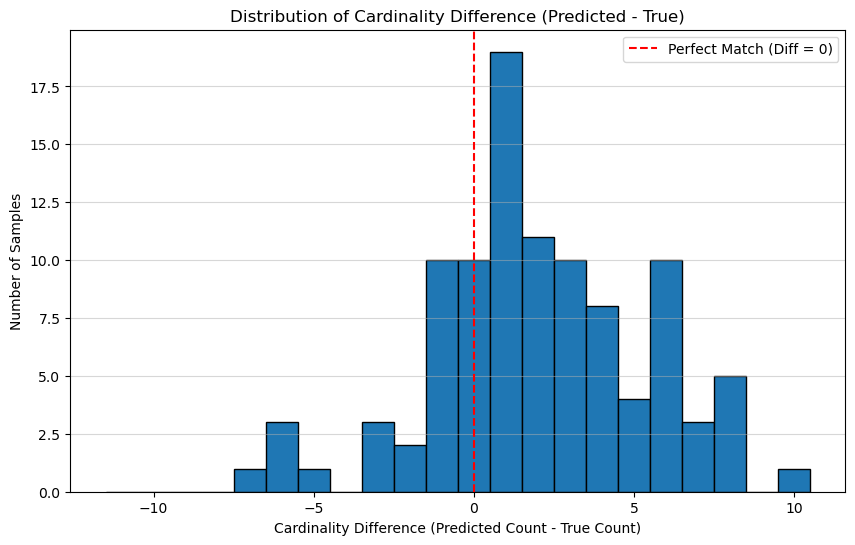

In [125]:
cardinality_true = np.sum(y_test_transformed, axis=1)
cardinality_pred = np.sum(y_pred_test, axis=1)
cardinality_difference = cardinality_pred - cardinality_true

max_abs_diff = np.abs(cardinality_difference).max()
bins = np.arange(-max_abs_diff, max_abs_diff + 1, 1)

plt.figure(figsize=(10, 6))
plt.hist(
    cardinality_difference,
    bins=bins,
    edgecolor='black',
    align='left'
)

plt.axvline(0, color='red', linestyle='--', linewidth=1.5, label='Perfect Match (Diff = 0)')

plt.title('Distribution of Cardinality Difference (Predicted - True)')
plt.xlabel('Cardinality Difference (Predicted Count - True Count)')
plt.ylabel('Number of Samples')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()


We had a decent number of predictions that were close but many that predicted too many labels, as we suspected. We could adjust the positive threshold higher to be more in line with true cardinality.

Next we will take a look at the cardinality distribution for true and predicted labels.

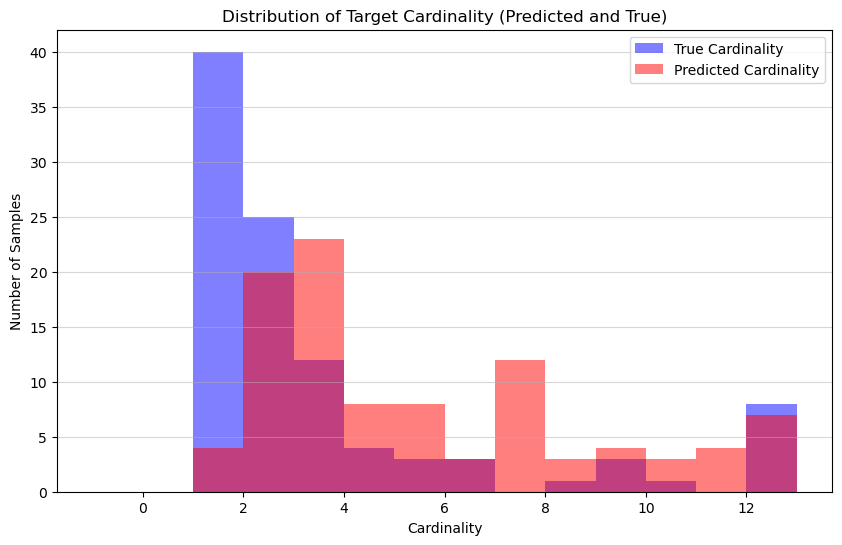

In [162]:
plt.figure(figsize=(10, 6))
bins = np.arange(
    -1,
    max(cardinality_true.max(), cardinality_pred.max()),
    1)

plt.hist(
    cardinality_true,
    bins=bins,
    alpha=0.5,
    color='blue',
    label='True Cardinality',
)
plt.hist(
    cardinality_pred,
    bins=bins,
    alpha=0.5,
    color='red',
    label='Predicted Cardinality'
)
plt.title('Distribution of Target Cardinality (Predicted and True)')
plt.xlabel('Cardinality')
plt.ylabel('Number of Samples')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

It looks like our model overpredicts the number of ESFs required at the low end and levels off a bit at the high end.

Next we will create heatmaps for incorrect and correct predictions, by label and type.

In [126]:
cm_array = multilabel_confusion_matrix(y_test_transformed, y_pred_test)

df_heatmap = pd.DataFrame({
    'True Positives': cm_array[:, 1, 1],
    'False Negatives': cm_array[:, 1, 0],
    'False Positives': cm_array[:, 0, 1],
    'True Negatives': cm_array[:, 0, 0]
})

df_heatmap.index = y_test_transformed.columns.tolist()

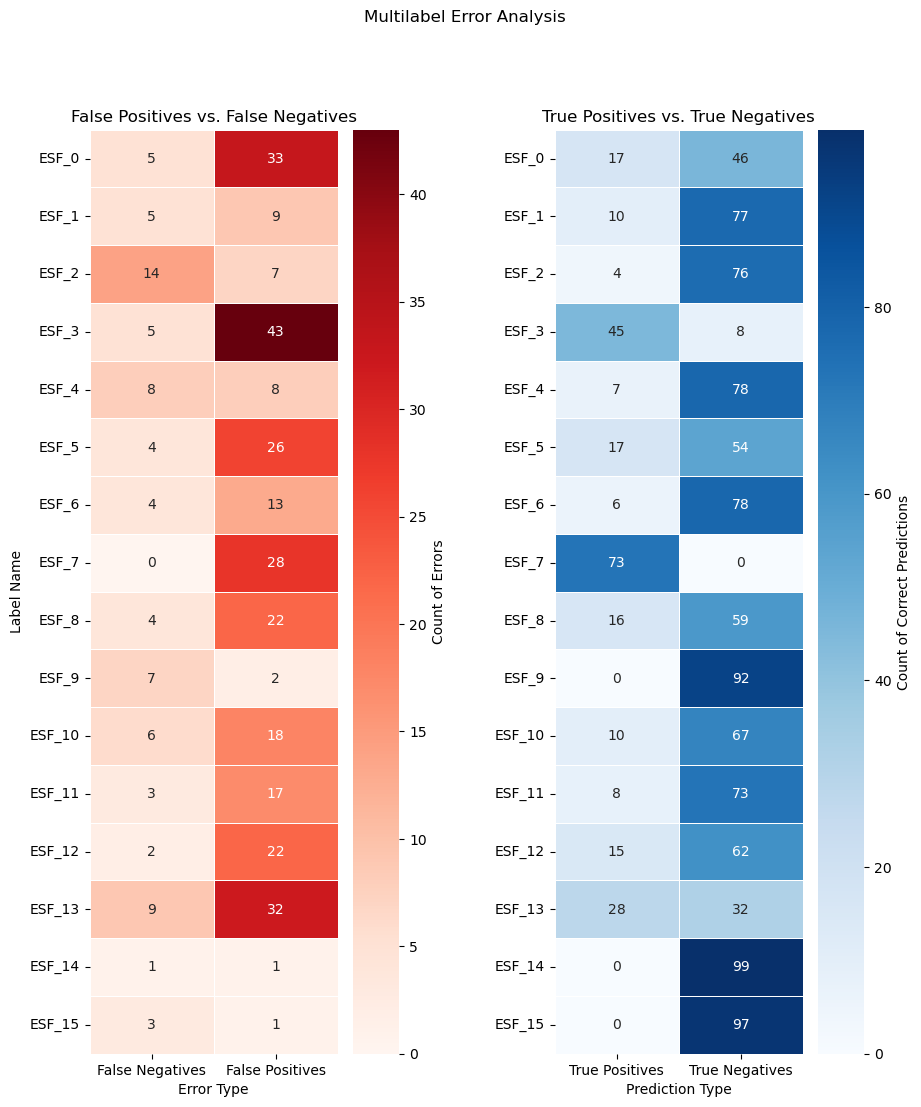

In [127]:
fig, axes = plt.subplots(
    1, 2, 
    figsize=(10, 12), 
)

ax_errors = axes[0]
df_errors = df_heatmap[['False Negatives', 'False Positives']]

sns.heatmap(
    df_errors,
    annot = True,
    fmt = 'd',
    cmap = 'Reds',
    linewidths = .5,
    cbar_kws = {'label': 'Count of Errors'},
    ax = ax_errors,
)

ax_errors.set_title('False Positives vs. False Negatives')
ax_errors.set_ylabel('Label Name')
ax_errors.set_xlabel('Error Type')
current_labels = ax_errors.get_yticklabels()
ax_errors.set_yticklabels(
    current_labels,
    rotation=0,
)

ax_correct = axes[1]
df_correct = df_heatmap[['True Positives', 'True Negatives']]

sns.heatmap(
    df_correct,
    annot = True,
    fmt = 'd',
    cmap = 'Blues',
    linewidths = .5,
    cbar_kws = {'label': 'Count of Correct Predictions'},
    ax = ax_correct
)

ax_correct.set_title('True Positives vs. True Negatives')
ax_correct.set_xlabel('Prediction Type')
ax_correct.set_yticklabels(
    current_labels,
    rotation=0,
)

fig.suptitle('Multilabel Error Analysis')
plt.subplots_adjust(wspace=0.5)
plt.show()

Our model did well by not predicting too many false negatives but did a bad job with false positives. This reflects the earlier plots that pointed to excessive ESF predictions when the true values were much lower.

We will perform a label co-occurence analysis to determine label correlation differences between the test set and our predictions.

In [128]:
# Generate a matrix of label combination counts for the test set
labels = y_test_transformed.columns.tolist()
label_len = len(labels)
true_corr = np.dot(y_test_transformed.T, y_test_transformed)
co_occurrence_df = pd.DataFrame(
    true_corr,
    index=labels,
    columns=labels,
)
co_occurrence_df

,ESF_0,ESF_1,ESF_2,ESF_3,ESF_4,ESF_5,ESF_6,ESF_7,ESF_8,ESF_9,ESF_10,ESF_11,ESF_12,ESF_13,ESF_14,ESF_15
ESF_0,22,11,11,16,7,11,4,19,9,5,12,8,9,11,1,0
ESF_1,11,15,12,15,9,10,5,15,11,6,14,10,12,11,1,3
ESF_2,11,12,18,14,9,9,6,14,13,7,12,9,12,12,1,2
ESF_3,16,15,14,50,13,17,8,33,15,7,16,11,16,23,1,3
ESF_4,7,9,9,13,15,8,5,10,10,6,10,9,11,9,0,3
ESF_5,11,10,9,17,8,21,7,20,10,6,12,7,10,15,1,2
ESF_6,4,5,6,8,5,7,10,10,7,4,6,5,7,9,0,2
ESF_7,19,15,14,33,10,20,10,73,13,7,16,11,14,32,1,3
ESF_8,9,11,13,15,10,10,7,13,20,7,12,9,13,11,1,3
ESF_9,5,6,7,7,6,6,4,7,7,7,7,5,7,7,1,2


In [129]:
# Get a normalized version of the co-occurrence counts
label_counts = np.diag(co_occurrence_df)
normalized_co_occurrence_df = co_occurrence_df.div(
    label_counts,
    axis=0,
    )
normalized_co_occurrence_df


,ESF_0,ESF_1,ESF_2,ESF_3,ESF_4,ESF_5,ESF_6,ESF_7,ESF_8,ESF_9,ESF_10,ESF_11,ESF_12,ESF_13,ESF_14,ESF_15
ESF_0,1.000000,0.500000,0.500000,0.727273,0.318182,0.500000,0.181818,0.863636,0.409091,0.227273,0.545455,0.363636,0.409091,0.500000,0.045455,0.000000
ESF_1,0.733333,1.000000,0.800000,1.000000,0.600000,0.666667,0.333333,1.000000,0.733333,0.400000,0.933333,0.666667,0.800000,0.733333,0.066667,0.200000
ESF_2,0.611111,0.666667,1.000000,0.777778,0.500000,0.500000,0.333333,0.777778,0.722222,0.388889,0.666667,0.500000,0.666667,0.666667,0.055556,0.111111
ESF_3,0.320000,0.300000,0.280000,1.000000,0.260000,0.340000,0.160000,0.660000,0.300000,0.140000,0.320000,0.220000,0.320000,0.460000,0.020000,0.060000
ESF_4,0.466667,0.600000,0.600000,0.866667,1.000000,0.533333,0.333333,0.666667,0.666667,0.400000,0.666667,0.600000,0.733333,0.600000,0.000000,0.200000
ESF_5,0.523810,0.476190,0.428571,0.809524,0.380952,1.000000,0.333333,0.952381,0.476190,0.285714,0.571429,0.333333,0.476190,0.714286,0.047619,0.095238
ESF_6,0.400000,0.500000,0.600000,0.800000,0.500000,0.700000,1.000000,1.000000,0.700000,0.400000,0.600000,0.500000,0.700000,0.900000,0.000000,0.200000
ESF_7,0.260274,0.205479,0.191781,0.452055,0.136986,0.273973,0.136986,1.000000,0.178082,0.095890,0.219178,0.150685,0.191781,0.438356,0.013699,0.041096
ESF_8,0.450000,0.550000,0.650000,0.750000,0.500000,0.500000,0.350000,0.650000,1.000000,0.350000,0.600000,0.450000,0.650000,0.550000,0.050000,0.150000
ESF_9,0.714286,0.857143,1.000000,1.000000,0.857143,0.857143,0.571429,1.000000,1.000000,1.000000,1.000000,0.714286,1.000000,1.000000,0.142857,0.285714


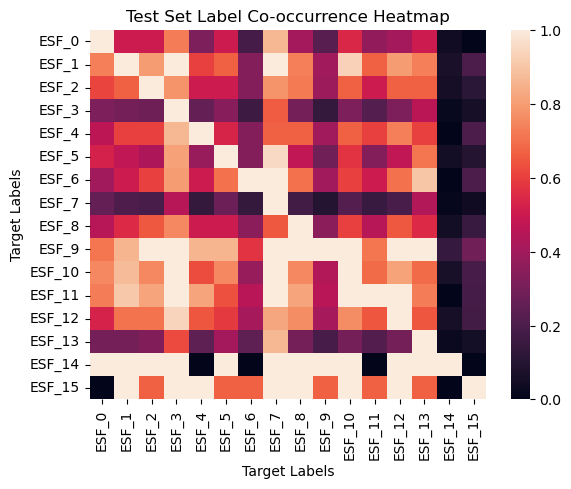

In [130]:
sns.heatmap(
    normalized_co_occurrence_df,
    annot=False,
    )
plt.title('Test Set Label Co-occurrence Heatmap')
plt.xlabel('Target Labels')
plt.ylabel('Target Labels')
plt.show()

In [131]:
# Generate a matrix of label combination counts for the prediction set
pred_corr = np.dot(y_pred_test.T, y_pred_test)
pred_co_occurrence_df = pd.DataFrame(
    pred_corr,
    index=labels,
    columns=labels,
)

pred_co_occurrence_df


,ESF_0,ESF_1,ESF_2,ESF_3,ESF_4,ESF_5,ESF_6,ESF_7,ESF_8,ESF_9,ESF_10,ESF_11,ESF_12,ESF_13,ESF_14,ESF_15
ESF_0,50,17,8,47,13,31,17,50,34,2,21,18,30,37,1,1
ESF_1,17,19,10,19,13,17,12,19,19,2,19,16,16,17,0,1
ESF_2,8,10,11,11,9,10,7,11,10,2,10,9,9,10,0,1
ESF_3,47,19,11,88,15,42,19,88,37,2,27,23,34,56,1,1
ESF_4,13,13,9,15,15,13,11,15,14,2,15,15,13,15,0,1
ESF_5,31,17,10,42,13,43,15,43,33,2,20,20,26,31,0,1
ESF_6,17,12,7,19,11,15,19,19,15,2,16,17,11,17,0,1
ESF_7,50,19,11,88,15,43,19,101,38,2,28,25,37,60,1,1
ESF_8,34,19,10,37,14,33,15,38,38,2,22,19,30,33,1,1
ESF_9,2,2,2,2,2,2,2,2,2,2,2,2,1,2,0,1


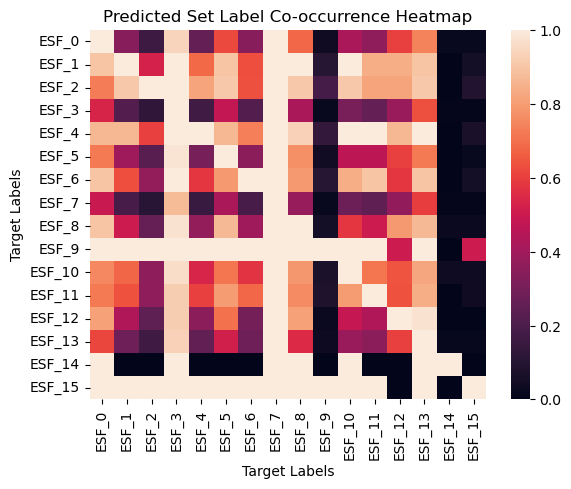

In [132]:
pred_label_counts = np.diag(pred_co_occurrence_df)
normalized_pred_co_occurrence_df = pred_co_occurrence_df.div(
    pred_label_counts,
    axis=0,
    )
sns.heatmap(
    normalized_pred_co_occurrence_df,
    annot=False,
    )
plt.title('Predicted Set Label Co-occurrence Heatmap')
plt.xlabel('Target Labels')
plt.ylabel('Target Labels')
plt.show()

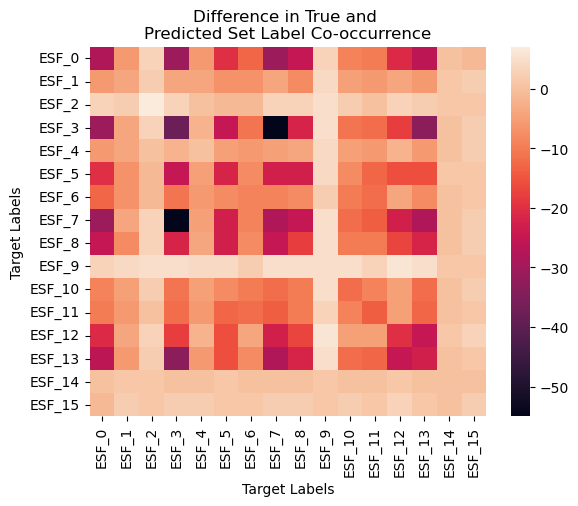

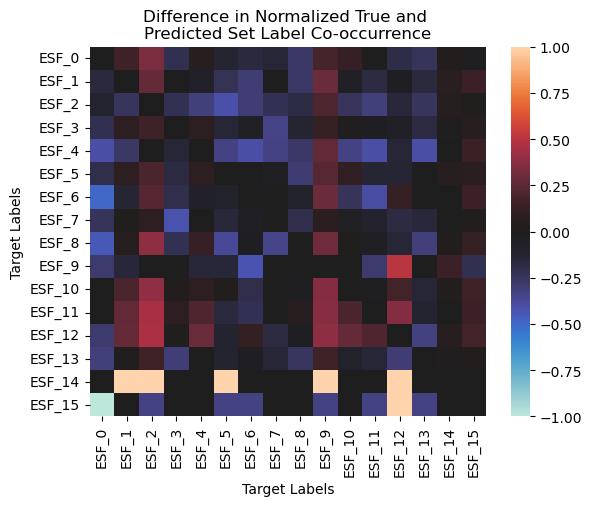

In [133]:
# Compare the differences between the test set and the prediction set

difference_df = co_occurrence_df - pred_co_occurrence_df
sns.heatmap(
    difference_df,
)
plt.title('Difference in True and \nPredicted Set Label Co-occurrence')
plt.xlabel('Target Labels')
plt.ylabel('Target Labels')
plt.show()

norm_difference_df = normalized_co_occurrence_df - normalized_pred_co_occurrence_df
sns.heatmap(
    norm_difference_df,
    center=0
)
plt.title('Difference in Normalized True and \nPredicted Set Label Co-occurrence')
plt.xlabel('Target Labels')
plt.ylabel('Target Labels')
plt.show()

There are definitely combinations of target labels that were underpredicted, with the worst being ESFs 9 and 14. There were other combinations with ESF 14 that also did poorly, both with underpredictions and overpredictions. It appears that ESF 15 and ESF 0 was not a real combination in the test set but is one that was predicted. Overall, our worst performance was on rare events, such as when ESFs 14 and 15 are present, and some of the more frequently occurring ESFs such as 0 and 13, though we did reasonably well when ESFs 3 or 7 were present.

We will now create a dataframe consisting of the label combinations and the error between the test set and the prediction set. Negative values will be overpredictions and positive values will be underpredictions.

In [165]:
difference_stack = (difference_df.stack().reset_index(name='difference').query('level_0 != level_1'))
largest_errors = difference_stack.reindex(difference_stack['difference'].abs().sort_values(ascending=False).index)
largest_errors.head(25)

,level_0,level_1,difference
115,ESF_7,ESF_3,-55
55,ESF_3,ESF_7,-55
61,ESF_3,ESF_13,-33
211,ESF_13,ESF_3,-33
112,ESF_7,ESF_0,-31
7,ESF_0,ESF_7,-31
48,ESF_3,ESF_0,-31
3,ESF_0,ESF_3,-31
125,ESF_7,ESF_13,-28
215,ESF_13,ESF_7,-28


We will also review combinations that worked well for the model by looking at the combinations in the tail.

In [135]:
largest_errors.tail(30)

,level_0,level_1,difference
229,ESF_14,ESF_5,1
249,ESF_15,ESF_9,1
236,ESF_14,ESF_12,1
233,ESF_14,ESF_9,1
246,ESF_15,ESF_6,1
223,ESF_13,ESF_15,1
110,ESF_6,ESF_14,0
62,ESF_3,ESF_14,0
66,ESF_4,ESF_2,0
78,ESF_4,ESF_14,0


Many of our best and worst performances were on rare events, such as when ESFs 14 and/or 15 are present. We did manage to get all seven instances of ESFs 9 and 2 correct.

Let's compare it to the differences in the normalized sets.

In [164]:
normalized_difference_stack = (normalized_co_occurrence_df.stack().reset_index(name='difference').query('level_0 != level_1'))
normalized_largest_errors = normalized_difference_stack.reindex(normalized_difference_stack['difference'].abs().sort_values(ascending=False).index)
normalized_largest_errors.head(30)

,level_0,level_1,difference
23,ESF_1,ESF_7,1.0
19,ESF_1,ESF_3,1.0
103,ESF_6,ESF_7,1.0
247,ESF_15,ESF_7,1.0
167,ESF_10,ESF_7,1.0
179,ESF_11,ESF_3,1.0
186,ESF_11,ESF_10,1.0
183,ESF_11,ESF_7,1.0
154,ESF_9,ESF_10,1.0
156,ESF_9,ESF_12,1.0


In [137]:
normalized_largest_errors.tail(15)

,level_0,level_1,difference
14,ESF_0,ESF_14,0.045455
127,ESF_7,ESF_15,0.041096
222,ESF_13,ESF_14,0.027027
62,ESF_3,ESF_14,0.020000
126,ESF_7,ESF_14,0.013699
15,ESF_0,ESF_15,0.000000
78,ESF_4,ESF_14,0.000000
110,ESF_6,ESF_14,0.000000
190,ESF_11,ESF_14,0.000000
228,ESF_14,ESF_4,0.000000


In [169]:
largest_errors[(largest_errors['level_0']=='ESF_1')&(
    largest_errors['level_1']=='ESF_7'
)]

,level_0,level_1,difference
23,ESF_1,ESF_7,-4


In [170]:
largest_errors[(largest_errors['level_0']=='ESF_1')&(
    largest_errors['level_1']=='ESF_3'
)]

,level_0,level_1,difference
19,ESF_1,ESF_3,-4


In [171]:
largest_errors[(largest_errors['level_0']=='ESF_6')&(
    largest_errors['level_1']=='ESF_7'
)]

,level_0,level_1,difference
103,ESF_6,ESF_7,-9


In [172]:
largest_errors[(largest_errors['level_0']=='ESF_15')&(
    largest_errors['level_1']=='ESF_7'
)]

,level_0,level_1,difference
247,ESF_15,ESF_7,2


In [166]:
normalized_largest_errors[(normalized_largest_errors['level_0']=='ESF_0')&(
    normalized_largest_errors['level_1']=='ESF_3'
)]

,level_0,level_1,difference
3,ESF_0,ESF_3,0.727273


There are some combinations that we predicted very often that did have multiple incorrect instances, such as ESFs 3 and 7, that we were wrong about a majority of the time but not every time. A quick check of those incorrect all of the time showed that the combination could be rarely used (just two to four times for some) but not always (nine times for ESFs 6 and 7).

Next we will look at permutation importance across the feature groups.

In [138]:

groups = {
    'state': state_columns,
    'region': region_columns,
    'declarationType': declaration_columns,
    'designatedIncidentTypes': type_columns
}

def grouped_feature_permutation(
    model,
    X,
    y,
    groups,
    metric_,
):
    baseline = combined_score(y_true=y, y_pred=model.predict(X = X))
    group_importance = {}
    group_importance['baseline'] = baseline
    for group, columns in groups.items():
        score_changes = []
        rng = np.random.default_rng(seed = random_state)
        for i in range(1,11):
            X_perm = X.copy()
            shuffled_ind = rng.permutation(X.index)
            X_perm[columns] = X_perm[columns].values[shuffled_ind]
            perm_score = combined_score(y_true= y, y_pred=model.predict(X_perm),)
            score_changes.append(perm_score)
        group_importance[group] = (f'Mean: {np.mean(score_changes)}', #Mean
                                   f'Max: {np.max(score_changes)}', #Max
                                   f'Min: {np.min(score_changes)}', #Min
                                   f'Std: {np.std(score_changes)}') #Std
    labels = []
    means = []
    errors = []

    for key, value in group_importance.items():
        if key == "baseline":
            y_line = (value)
        else:
            mean_val = float(value[0].split(":")[1])
            std_val = float(value[3].split(":")[1])
            labels.append(key)
            means.append(mean_val)
            errors.append(std_val)
    # Create a plot of values
    plt.figure(figsize=(10,6))
    plt.bar(labels,
            means,
            yerr=errors)
    plt.axhline(y=y_line,
                color='k',
                linestyle='--',
                label='Baseline',
                )
    plt.ylim([0, 1.5])
    plt.ylabel('Combined Metric Score')
    plt.title('Performance Given Permuted Values of Feature Groups')
    plt.tight_layout()
    plt.show()

    return group_importance

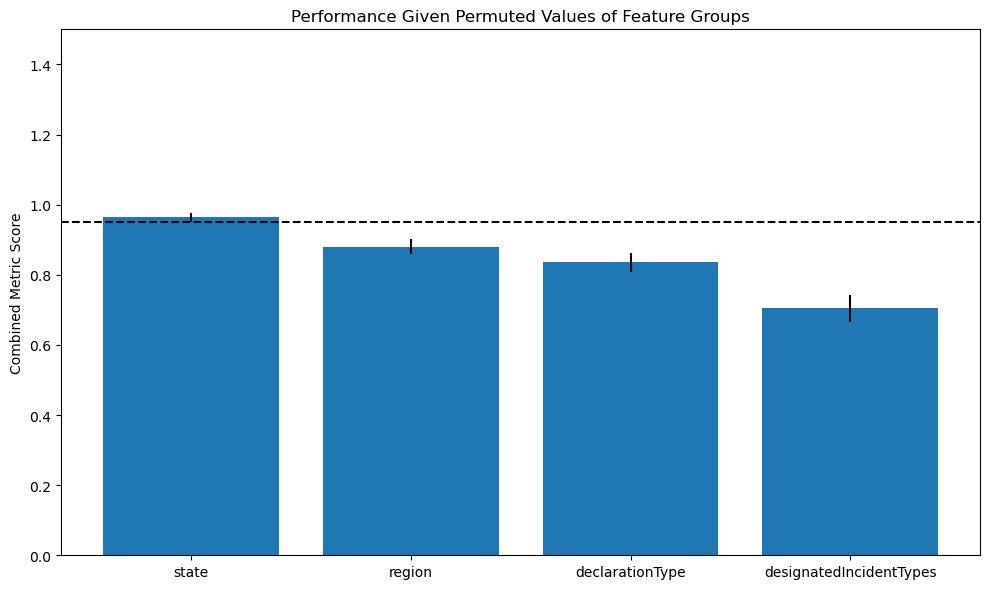

{'baseline': 0.9508134432109682,
 'state': ('Mean: 0.9638298228121982',
  'Max: 0.9906751087271011',
  'Min: 0.9431817369582964',
  'Std: 0.012326114322451273'),
 'region': ('Mean: 0.8803573957379186',
  'Max: 0.9111858437206486',
  'Min: 0.8480680737183479',
  'Std: 0.02101929147094944'),
 'declarationType': ('Mean: 0.8358529573367394',
  'Max: 0.8943711621001927',
  'Min: 0.7960602952089422',
  'Std: 0.026815541070772754'),
 'designatedIncidentTypes': ('Mean: 0.7039000578992616',
  'Max: 0.7563894836772727',
  'Min: 0.629831652054223',
  'Std: 0.038101119117609175')}

In [139]:
perm_scores = grouped_feature_permutation(study_ovrxgb_tuned,
                                          X_test_transformed,
                                          y_test_transformed,
                                          groups,
                                          F1_Macro_Avg)

perm_scores

Permutations of state actually seem to have improved the results over the baseline ever so slightly, whereas every other group results in lower scores. Changing the designatedIncidentTypes has the biggest negative impact on the final metric score compared to the baseline.

Let us start analyzing edge cases. We can begin by picking a few rows from the same incident and comparing outcomes for different states.

In [140]:
X_test['incidentId'].value_counts()

incidentId
2012102505    13
2021082601     8
2020091301     6
2021081902     3
2023081703     3
2018031201     2
2020041101     2
2021081801     2
2020010701     2
2022122101     2
2023030901     2
2024042701     2
2024052402     2
2024080901     2
2013051001     1
2013050601     1
2016092301     1
2016100501     1
2017012001     1
2016100502     1
2013062801     1
2013070101     1
2013070102     1
2013060301     1
2014061802     1
2014071703     1
2015021101     1
2015050801     1
2016012701     1
2016061101     1
2016081301     1
2014020501     1
2019110801     1
2019110101     1
2019101801     1
2018082801     1
2018041602     1
2018022302     1
2017110602     1
2017110601     1
2017021001     1
2017072901     1
2017052601     1
2017031101     1
2021080901     1
2021062401     1
2020082004     1
2020020701     1
2022081903     1
2022070501     1
2022062801     1
2022051202     1
2022010701     1
2022010301     1
2023081101     1
2023030102     1
2023090401     1
2023082901     1
202

In [141]:
X_test[X_test['incidentId']==2012102505]

,incidentId,state,designatedIncidentTypes,declarationType,region,year
0,2012102505,CT,[Hurricane],DR,1,2012.0
1,2012102505,DC,[Hurricane],EM,3,2012.0
2,2012102505,DE,[Hurricane],DR,3,2012.0
3,2012102505,DE,[Hurricane],EM,3,2012.0
4,2012102505,MD,[Hurricane],DR,3,2012.0
5,2012102505,MD,[Hurricane],EM,3,2012.0
6,2012102505,NJ,[Hurricane],DR,2,2012.0
7,2012102505,NY,[Hurricane],DR,2,2012.0
8,2012102505,PA,[Hurricane],EM,3,2012.0
9,2012102505,RI,[Hurricane],DR,1,2012.0


In [ ]:
compare_true_to_pred(8, X_test, y_test_transformed, y_pred_test)

incidentId                  2012102505
state                               PA
designatedIncidentTypes    [Hurricane]
declarationType                     EM
region                               3
year                            2012.0
Name: 8, dtype: object 
         true  predicted
ESF_0      0          1
ESF_4      1          0
ESF_5      0          1
ESF_7      0          1
ESF_12     0          1
ESF_13     0          1 
        true  predicted
ESF_3     1          1
ESF_8     1          1


In [174]:
compare_true_to_pred(1, X_test, y_test_transformed, y_pred_test)


incidentId                  2012102505
state                               DC
designatedIncidentTypes    [Hurricane]
declarationType                     EM
region                               3
year                            2012.0
Name: 1, dtype: object 
         true  predicted
ESF_0      0          1
ESF_3      0          1
ESF_4      1          0
ESF_5      0          1
ESF_7      0          1
ESF_8      0          1
ESF_12     0          1
ESF_13     0          1 
 Empty DataFrame
Columns: [true, predicted]
Index: []


In [175]:
compare_true_to_pred(5, X_test, y_test_transformed, y_pred_test)


incidentId                  2012102505
state                               MD
designatedIncidentTypes    [Hurricane]
declarationType                     EM
region                               3
year                            2012.0
Name: 5, dtype: object 
         true  predicted
ESF_0      0          1
ESF_3      0          1
ESF_4      1          0
ESF_5      0          1
ESF_7      0          1
ESF_8      0          1
ESF_12     0          1
ESF_13     0          1 
 Empty DataFrame
Columns: [true, predicted]
Index: []


In [176]:
compare_true_to_pred(0, X_test, y_test_transformed, y_pred_test)


incidentId                  2012102505
state                               CT
designatedIncidentTypes    [Hurricane]
declarationType                     DR
region                               1
year                            2012.0
Name: 0, dtype: object 
         true  predicted
ESF_1      1          0
ESF_3      1          0
ESF_4      1          0
ESF_8      1          0
ESF_10     1          0
ESF_11     1          0
ESF_13     0          1
ESF_15     1          0 
         true  predicted
ESF_7      1          1
ESF_12     1          1


In [177]:
compare_true_to_pred(10, X_test, y_test_transformed, y_pred_test)


incidentId                  2012102505
state                               VA
designatedIncidentTypes    [Hurricane]
declarationType                     DR
region                               3
year                            2012.0
Name: 10, dtype: object 
         true  predicted
ESF_3      0          1
ESF_12     0          1
ESF_13     0          1 
        true  predicted
ESF_7     1          1


Here we see five match incidentId values with matching designatedIncidentTypes across five different states with varying declarationTypes. This helps show some of the difficulties in predicting ESFs based on very few features. The disaster in Connecticut varies from the disaster in Virginia only by state, but the incident in Connecticut required nine different ESFs while in Virginia is only required one. It is interesting that the event in Connecticut did not result in nearly as many positive predicted labels as the incident in Virgina. Had those been flipped, our outcomes would have improved in both locations.

Lets look at some of the incidents in the test set with large label sets to see how we performed in those cases.

In [178]:
label_set_counts_true = y_test_transformed.sum(axis=1)
edge_cases_large_label_sets = label_set_counts_true.sort_values()
edge_cases_large_label_sets[-10:]

26    10
46    12
89    12
6     13
50    13
81    13
63    13
65    13
64    13
7     14
dtype: int64

In [180]:
compare_true_to_pred(7, X_test, y_test_transformed, y_pred_test)


incidentId                  2012102505
state                               NY
designatedIncidentTypes    [Hurricane]
declarationType                     DR
region                               2
year                            2012.0
Name: 7, dtype: object 
         true  predicted
ESF_0      0          1
ESF_9      1          0
ESF_15     1          0 
         true  predicted
ESF_1      1          1
ESF_2      1          1
ESF_3      1          1
ESF_4      1          1
ESF_5      1          1
ESF_6      1          1
ESF_7      1          1
ESF_8      1          1
ESF_10     1          1
ESF_11     1          1
ESF_12     1          1
ESF_13     1          1


In [181]:
compare_true_to_pred(64, X_test, y_test_transformed, y_pred_test)


incidentId                  2021082601
state                               LA
designatedIncidentTypes    [Hurricane]
declarationType                     DR
region                               6
year                            2021.0
Name: 64, dtype: object 
        true  predicted
ESF_1     0          1
ESF_9     1          0 
         true  predicted
ESF_0      1          1
ESF_2      1          1
ESF_3      1          1
ESF_4      1          1
ESF_5      1          1
ESF_6      1          1
ESF_7      1          1
ESF_8      1          1
ESF_10     1          1
ESF_11     1          1
ESF_12     1          1
ESF_13     1          1


In [182]:
compare_true_to_pred(81, X_test, y_test_transformed, y_pred_test)


incidentId                                                      2023030901
state                                                                   CA
designatedIncidentTypes    [Flood, Snowstorm, Severe Storm, Mud/Landslide]
declarationType                                                         EM
region                                                                   9
year                                                                2023.0
Name: 81, dtype: object 
        true  predicted
ESF_2     1          0
ESF_4     1          0
ESF_9     1          0 
         true  predicted
ESF_0      1          1
ESF_1      1          1
ESF_3      1          1
ESF_5      1          1
ESF_7      1          1
ESF_8      1          1
ESF_10     1          1
ESF_11     1          1
ESF_12     1          1
ESF_13     1          1


In [183]:
compare_true_to_pred(50, X_test, y_test_transformed, y_pred_test)


incidentId                 2020082004
state                              CA
designatedIncidentTypes        [Fire]
declarationType                    DR
region                              9
year                           2020.0
Name: 50, dtype: object 
        true  predicted
ESF_2     1          0 
         true  predicted
ESF_0      1          1
ESF_1      1          1
ESF_3      1          1
ESF_4      1          1
ESF_5      1          1
ESF_6      1          1
ESF_7      1          1
ESF_8      1          1
ESF_10     1          1
ESF_11     1          1
ESF_12     1          1
ESF_13     1          1


In [184]:
compare_true_to_pred(26, X_test, y_test_transformed, y_pred_test)


incidentId                 2016081301
state                              LA
designatedIncidentTypes       [Flood]
declarationType                    DR
region                              6
year                           2016.0
Name: 26, dtype: object 
         true  predicted
ESF_1      1          0
ESF_6      1          0
ESF_8      1          0
ESF_10     1          0
ESF_12     1          0
ESF_13     1          0 
         true  predicted
ESF_3      1          1
ESF_5      1          1
ESF_7      1          1
ESF_11     1          1


We did fairly well on the large datasets. Our worst performance involved a flood in Louisiana, which could easily have been a combination in the training set. Perhaps there were other floods or disasters in Louisiana that required more ESFs.

Let's look for instances with the worst differences in cardinality.

In [153]:
label_set_counts_pred = y_pred_test.sum(axis=1)
label_set_counts_true-label_set_counts_pred


0       6
1      -6
2      -4
3      -6
4      -4
5      -6
6       0
7       1
8      -4
9      -1
10     -3
11     -4
12     -4
13     -6
14     -2
15     -1
16     -2
17     -2
18     -2
19     -3
20     -3
21     -7
22     -1
23      0
24      1
25     -1
26      6
27     -6
28     -1
29     -1
30     -2
31     -1
32      0
33     -1
34      0
35     -1
36     -2
37      0
38      1
39     -1
40     -4
41      0
42     -7
43     -1
44     -1
45      6
46      3
47     -2
48      1
49      0
50      1
51      1
52     -3
53     -8
54    -11
55     -5
56     -4
57     -6
58     -6
59     -4
60     -2
61     -5
62     -6
63      7
64      0
65      2
66     -3
67     -8
68     -3
69     -8
70     -5
71     -3
72      0
73      1
74      1
75     -1
76     -1
77     -2
78     -1
79     -2
80     -5
81      3
82     -6
83     -1
84     -7
85     -8
86     -6
87     -2
88     -8
89      5
90      1
91      3
92     -1
93      2
94      1
95     -1
96     -1
97     -3
98     -3
99     -3


He is one from the large label set series above that we did not check. 

In [185]:
compare_true_to_pred(63, X_test, y_test_transformed, y_pred_test)


incidentId                  2021081902
state                               RI
designatedIncidentTypes    [Hurricane]
declarationType                     EM
region                               1
year                            2021.0
Name: 63, dtype: object 
         true  predicted
ESF_1      1          0
ESF_2      1          0
ESF_3      1          0
ESF_4      1          0
ESF_9      1          0
ESF_10     1          0
ESF_11     1          0 
         true  predicted
ESF_0      1          1
ESF_5      1          1
ESF_7      1          1
ESF_8      1          1
ESF_12     1          1
ESF_13     1          1


Interesting. It is a hurricane like many of the above but the state is Rhode Island. That made the model underpredict the necessary ESFs.

Now we can look at some of the worst overpredictions.

In [186]:
compare_true_to_pred(54, X_test, y_test_transformed, y_pred_test)


incidentId                  2020091301
state                               FL
designatedIncidentTypes    [Hurricane]
declarationType                     EM
region                               4
year                            2020.0
Name: 54, dtype: object 
         true  predicted
ESF_1      0          1
ESF_2      0          1
ESF_3      0          1
ESF_4      0          1
ESF_6      0          1
ESF_8      0          1
ESF_9      0          1
ESF_10     0          1
ESF_11     0          1
ESF_13     0          1
ESF_15     0          1 
        true  predicted
ESF_0     1          1
ESF_5     1          1
ESF_7     1          1


In [187]:
compare_true_to_pred(88, X_test, y_test_transformed, y_pred_test)


incidentId                    2023082901
state                                 WA
designatedIncidentTypes    [Other, Fire]
declarationType                       DR
region                                10
year                              2023.0
Name: 88, dtype: object 
         true  predicted
ESF_0      0          1
ESF_3      0          1
ESF_4      0          1
ESF_6      0          1
ESF_8      0          1
ESF_10     0          1
ESF_11     0          1
ESF_12     0          1 
         true  predicted
ESF_7      1          1
ESF_13     1          1


Here we see a hurricane and a fire that generated very few ESFs in reality but our model predicts the need for many more.

We will round out our error analysis by checking predictions with the worst and best Jaccard similarity scores.

In [188]:
# Calculate Jaccard similarity between the test set and the prediction set by row.

jaccard_series = pd.Series(
    [
        jaccard_score(y_test_transformed.iloc[i], y_pred_test[i], average='macro')
        for i in range(len(y_test_transformed))
    ],
    index=y_test_transformed.index
)
jaccard_series.sort_values()


54     0.184066
85     0.212121
5      0.250000
1      0.250000
84     0.250000
3      0.250000
86     0.288889
56     0.312500
88     0.314286
53     0.314286
0      0.314286
67     0.328671
69     0.328671
42     0.361111
13     0.371429
27     0.371429
62     0.371429
63     0.380769
21     0.390152
55     0.390152
35     0.406250
38     0.406250
12     0.410714
8      0.410714
58     0.410714
82     0.410714
25     0.416667
45     0.435897
57     0.435897
59     0.435897
26     0.450000
61     0.464286
68     0.464286
80     0.464286
70     0.464286
40     0.466667
11     0.466667
6      0.466667
4      0.466667
2      0.466667
89     0.513889
65     0.523810
99     0.525000
95     0.525000
10     0.525000
9      0.525000
20     0.525000
7      0.525000
97     0.525000
98     0.525000
60     0.583333
52     0.592857
66     0.592857
71     0.592857
14     0.600000
47     0.600000
17     0.600000
16     0.600000
23     0.600000
30     0.600000
79     0.600000
87     0.600000
36     0

In [189]:
compare_true_to_pred(3, X_test, y_test_transformed, y_pred_test)


incidentId                  2012102505
state                               DE
designatedIncidentTypes    [Hurricane]
declarationType                     EM
region                               3
year                            2012.0
Name: 3, dtype: object 
         true  predicted
ESF_0      0          1
ESF_2      1          0
ESF_3      0          1
ESF_5      0          1
ESF_7      0          1
ESF_8      0          1
ESF_12     0          1
ESF_13     0          1 
 Empty DataFrame
Columns: [true, predicted]
Index: []


In [190]:
compare_true_to_pred(11, X_test, y_test_transformed, y_pred_test)


incidentId                  2012102505
state                               WV
designatedIncidentTypes    [Hurricane]
declarationType                     DR
region                               3
year                            2012.0
Name: 11, dtype: object 
         true  predicted
ESF_0      0          1
ESF_3      0          1
ESF_12     0          1
ESF_13     0          1 
        true  predicted
ESF_7     1          1


The first two are from the same incidentId as we checked before. Again, changing the state and declaration type results in substantial changes to the ESFs required for this designatedIncidentType and our model falsely predicts the need for many ESFs.

In [191]:
compare_true_to_pred(85, X_test, y_test_transformed, y_pred_test)


incidentId                                             2023081703
state                                                          CA
designatedIncidentTypes    [Flood, Mud/Landslide, Tropical Storm]
declarationType                                                DR
region                                                          9
year                                                       2023.0
Name: 85, dtype: object 
         true  predicted
ESF_0      0          1
ESF_1      0          1
ESF_2      1          0
ESF_3      0          1
ESF_5      0          1
ESF_6      0          1
ESF_7      0          1
ESF_10     0          1
ESF_11     0          1
ESF_13     0          1 
        true  predicted
ESF_8     1          1


In [192]:
compare_true_to_pred(71, X_test, y_test_transformed, y_pred_test)


incidentId                  2021082601
state                               PA
designatedIncidentTypes    [Hurricane]
declarationType                     DR
region                               3
year                            2021.0
Name: 71, dtype: object 
         true  predicted
ESF_0      0          1
ESF_3      0          1
ESF_12     0          1 
         true  predicted
ESF_7      1          1
ESF_13     1          1


These last two again have designatedIncidentTypes that would signify need for significant support according to the model but in reality did not require many Emergency Support Functions at all. There appears to be a feature missing that would indicate severity of the incident in a more nuanced way than declarationType provides.

We will finish by looking at our best performances.

In [193]:
compare_true_to_pred(72, X_test, y_test_transformed, y_pred_test)


incidentId                     2022010301
state                                  KS
designatedIncidentTypes    [Severe Storm]
declarationType                        DR
region                                  7
year                               2021.0
Name: 72, dtype: object 
 Empty DataFrame
Columns: [true, predicted]
Index: [] 
        true  predicted
ESF_7     1          1


In [194]:
compare_true_to_pred(41, X_test, y_test_transformed, y_pred_test)


incidentId                 2018082801
state                              WI
designatedIncidentTypes       [Flood]
declarationType                    DR
region                              5
year                           2018.0
Name: 41, dtype: object 
 Empty DataFrame
Columns: [true, predicted]
Index: [] 
         true  predicted
ESF_3      1          1
ESF_7      1          1
ESF_13     1          1


In [195]:
compare_true_to_pred(32, X_test, y_test_transformed, y_pred_test)


incidentId                 2017031101
state                              WA
designatedIncidentTypes       [Flood]
declarationType                    DR
region                             10
year                           2017.0
Name: 32, dtype: object 
 Empty DataFrame
Columns: [true, predicted]
Index: [] 
        true  predicted
ESF_7     1          1


In [196]:
compare_true_to_pred(34, X_test, y_test_transformed, y_pred_test)


incidentId                     2017072901
state                                  WV
designatedIncidentTypes    [Severe Storm]
declarationType                        DR
region                                  3
year                               2017.0
Name: 34, dtype: object 
 Empty DataFrame
Columns: [true, predicted]
Index: [] 
         true  predicted
ESF_7      1          1
ESF_13     1          1


Very interesting. We did well on two floods but also performed very poorly on a flood in Louisiana. We also did well on two severe storms even though they required different ESFs between the two incidents. 

It appears that we can handle some incidents well but a lack of training data is the likely culprit.